# Download and import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
! git clone https://github.com/aaron-xichen/pytorch-playground.git
# ! pip install utee

fatal: destination path 'pytorch-playground' already exists and is not an empty directory.


In [3]:
#### Install libraries ############
% cd pytorch-playground
# ! ls
! python3 setup.py develop --user
# ! pip install anaconda
# ! pip install torch==1.8.1 torchvision
# ! pip install tqdm
# ! pip install numpy
# ! pip install utee
#! pip uninstall pytorch-playground
# ! pip install --upgrade torchvision
! pip install -U scikit-learn

/content/drive/MyDrive/pytorch-playground
running develop
running egg_info
writing pytorch_playground.egg-info/PKG-INFO
writing dependency_links to pytorch_playground.egg-info/dependency_links.txt
writing entry points to pytorch_playground.egg-info/entry_points.txt
writing requirements to pytorch_playground.egg-info/requires.txt
writing top-level names to pytorch_playground.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'pytorch_playground.egg-info/SOURCES.txt'
running build_ext
Creating /root/.local/lib/python3.7/site-packages/pytorch-playground.egg-link (link to .)
Adding pytorch-playground 1.0.0 to easy-install.pth file
Installing quantize script to /root/.local/bin

Installed /content/drive/MyDrive/pytorch-playground
Processing dependencies for pytorch-playground==1.0.0
Searching for joblib==0.14.1
Reading https://pypi.org/simple/joblib/
Best match: joblib 0.14.1
Processing joblib-0.14.1-py2.py3-none-any.whl
Installing joblib-0.14.1-py2.py3-none-any.whl 

In [4]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image

# Values

In [5]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
print(DEVICE)
batch_size = 100

cuda


# Define adversarial classes and target classifier network

In [6]:

def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return X + epsilon * delta.grad.detach().sign()

def fgsm_L2(model, X, y, epsilon):
    """ Construct FGSM-L2 adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return X + epsilon * delta.grad.detach()/torch.norm(torch.norm((delta.grad.detach()),dim=2,keepdim=True),dim=3,keepdim=True)

def R_fgsm(model, X, y, epsilon, alpha):
    """ Construct R-FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    return fgsm(model, random(X,alpha),y,epsilon)

def R_fgsm_L2(model, X, y, epsilon, alpha):
    """ Construct R-FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    return fgsm_L2(model, random(X,alpha), y, epsilon)

def random(X, epsilon) :
    delta = 2*torch.rand_like(X).to(DEVICE) - 1
    return X + epsilon*delta

def BIM(model, X, y, epsilon, epsilon_step, no_of_steps):
    """ Construct BIM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    Xi = X.clone()
    for i in range(no_of_steps) :
      # delta = torch.zeros_like(X, requires_grad=True)
      loss = nn.CrossEntropyLoss()(model(X + delta), y)
      loss.backward()
      X = torch.clip(X.clone() + epsilon_step * delta.grad.detach().sign(),-1.,1.)
    diff = X - Xi
    return Xi + torch.clip(diff,-epsilon,epsilon)

def BIM_L2(model, X, y, epsilon, epsilon_step, no_of_steps):
    """ Construct BIM-L2 adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    Xi = X.clone()
    for i in range(no_of_steps) :
      loss = nn.CrossEntropyLoss()(model(X + delta), y)
      loss.backward()
      X = torch.clip(X.clone() + epsilon_step * (delta.grad.detach())/torch.norm((delta.grad.detach()),dim=1,keepdim=True),-1.,1.)
    diff = X - Xi
    factor = torch.clip(torch.norm(torch.norm((diff.detach()),dim=2,keepdim=True),\
              dim=3,keepdim=True),0,epsilon)\
              / torch.norm(torch.norm((diff.detach()),dim=2,keepdim=True),\
              dim=3,keepdim=True)
    return Xi + diff*factor

def CW(model,X,y,epsilon,epsilon_step,no_of_steps,c,target):
    """ Construct CW adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    Xn = X.clone()
    # Iterations
    for i in range(no_of_steps) :
      sec_target = []
      A = model(Xn+delta)
      for i in range(A.shape[0]) :
        maxi = -1
        maxval = -10000
        for j in range(A.shape[1]) :
          if A[i,j] > maxval and j!=target[i]:
            maxval = A[i,j]
            maxi = j
        sec_target.append(maxi)
      
      val = torch.diag(A[:,target[:]])
      val_targ = torch.diag(A[:,sec_target[:]])
      # print(val)
      # print(val_targ)
      # for i in range(A.shape[0]) :  
      #   A[i,target[i]] = -1000
      loss = -torch.mean((Xn+delta-X)**2) - torch.mean(c*torch.clip(val_targ-val,-4,1000))
      loss.backward()
      Xn = Xn.clone() + epsilon_step * delta.grad.detach()
    diff = Xn - X
    return X + torch.clip(diff,-epsilon,epsilon) 

def S_BIM(model,model_detector,X,target,epsilon,sigma,epsilon_step,no_of_steps):
    """ Construct S-BIM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    delta_detector = torch.zeros_like(X, requires_grad=True)
    Xn = X.clone()
    for i in range(no_of_steps) :
      sec_target = []
      A = model(Xn+delta)
      for i in range(A.shape[0]) :
        maxi = -1
        maxval = -10000
        for j in range(A.shape[1]) :
          if A[i,j] > maxval and j!=target[i]:
            maxval = A[i,j]
            maxi = j
        sec_target.append(maxi)
      
      val = torch.diag(A[:,target[:]])
      val_targ = torch.diag(A[:,sec_target[:]])
      loss = -sigma*torch.mean((Xn+delta-get_recon(model_detector,Xn+delta,target))**2) - (1-sigma)*torch.mean(torch.clip(val_targ-val,-4,1000))
      loss.backward()
      Xn = Xn.clone() + epsilon_step * delta.grad.detach().sign()
    diff = Xn - X
    return X + torch.clip(diff,-epsilon,epsilon) 


from torch.autograd import Variable
from utee import selector
model_raw, ds_fetcher, is_imagenet = selector.select('mnist')

Building and initializing mnist parameters
Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)
Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth


  0%|          | 0.00/1.03M [00:00<?, ?B/s]

# Download and preprocess dataset

In [7]:
from torchvision.datasets import MNIST,CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {} 
class AugDataset(Dataset):
  def __init__(self,orig_dataset):
    self.dataset = orig_dataset
  
  def __len__(self):
    return 4*self.dataset.__len__()
  
  def __getitem__(self,idx):
    if idx<self.dataset.__len__() :
      return self.dataset.__getitem__(idx)
    
    idx = idx-self.dataset.__len__()
    if idx<self.dataset.__len__() :
      x_in,y = self.dataset.__getitem__(idx)
      x_in = x_in.view(1,x_dim)
      x_in = x_in.to(DEVICE)
      y = torch.tensor(y).unsqueeze(0)
      y = y.to(DEVICE)
      x_out = Ifgsm(model_raw,x_in,y,0.02,5)
      y = 12
      x_out = x_out.view(1,28,28).cpu()
      return x_out, y
    
    idx = idx-self.dataset.__len__()
    if idx<self.dataset.__len__() :
      x_in,y = self.dataset.__getitem__(idx)
      x_in = x_in.view(1,x_dim)
      x_in = x_in.to(DEVICE)
      y = torch.tensor(y).unsqueeze(0)
      y = y.to(DEVICE)
      x_out = Rfgsm(model_raw,x_in,y,0.1,0.01)
      y = 11
      x_out = x_out.view(1,28,28).cpu()
      return x_out, y
    
    idx = idx-self.dataset.__len__()
    if idx<self.dataset.__len__() :
      x_in,y = self.dataset.__getitem__(idx)
      x_in = x_in.view(1,x_dim)
      x_in = x_in.to(DEVICE)
      y = torch.tensor(y).unsqueeze(0)
      y = y.to(DEVICE)
      x_out = fgsm(model_raw,x_in,y,0.1)
      y = 10
      x_out = x_out.view(1,28,28).cpu()
      return x_out, y

def get_same_index(target, label):
    label_indices = []
    for i in range(len(target)):
        if target[i] == label:
            label_indices.append(i)
    return label_indices

train_dataset_raw = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset_raw  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
print(len(test_dataset_raw))
# train_dataset_raw = train_dataset_raw[:30000]
train_dataset = AugDataset(train_dataset_raw)
test_dataset = AugDataset(test_dataset_raw)
print(len(train_dataset_raw))
train_loader = DataLoader(dataset=train_dataset_raw, batch_size=batch_size, shuffle=True, **kwargs)
test_loader1  = DataLoader(dataset=test_dataset_raw,  batch_size=batch_size, shuffle=True,  **kwargs)
label_class = 1 # ones

# Get indices of label_class
train_indices = get_same_index(train_dataset_raw, label_class)

one_set = torch.utils.data.Subset(train_dataset_raw, train_indices)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

10000
60000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Conditional VAE

# Hyperparameters

In [8]:
seed=0
epochs=50
batch_size=16
learning_rate=0.001
latent_size=128
print_every=100
fig_root='figs'
device = 'cuda'
n_labels = 10

def idx2onehot(idx, n):
    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    return onehot

# Define VAE_conv model

In [9]:
class VAE_conv(nn.Module):
    def __init__(self, label, image_size, channel_num, kernel_num, z_size, conditional=False,n_labels=0):
        # configurations
        super().__init__()
        self.label = label
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        # encoder
        self.encoder = nn.Sequential(
            self._conv(channel_num, kernel_num // 4),
            self._conv(kernel_num // 4, kernel_num // 2),
            self._conv(kernel_num // 2, kernel_num, last=True),
        )

        # encoded feature's size and volume
        self.feature_size = (image_size // 8) + 1
        self.feature_volume = kernel_num * (self.feature_size ** 2)
        self.conditional = conditional
        if self.conditional:
            # q
            self.q_mean = self._linear(self.feature_volume+n_labels, z_size, relu=False)
            self.q_logvar = self._linear(self.feature_volume+n_labels, z_size, relu=False)
            print(z_size+n_labels)
            self.project = self._linear(z_size+n_labels, self.feature_volume, relu=False)
        else :
            # q
            self.q_mean = self._linear(self.feature_volume, z_size, relu=False)
            self.q_logvar = self._linear(self.feature_volume, z_size, relu=False)
            self.project = self._linear(z_size, self.feature_volume, relu=False)

        # decoder
        self.decoder = nn.Sequential(
            self._deconv(kernel_num, kernel_num // 2),
            self._deconv(kernel_num // 2, kernel_num // 4),
            self._deconv(kernel_num // 4, channel_num, last=True),
            nn.Sigmoid()
        )

    def forward(self, x, c=None):
        # encode x
        encoded = self.encoder(x)
        if self.conditional:
            c = idx2onehot(c, n=n_labels)
            # encoded = torch.cat((encoded, c), dim=-1)
        # sample latent code z from q given x.
        mean, logvar = self.q(encoded,c)
        z = self.z(mean, logvar)
        if self.conditional:
            # c = idx2onehot(c, n=n_labels)
            z = torch.cat((z, c), dim=-1)
        
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )

        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)[:,:,2:-2,2:-2]

        # return the parameters of distribution of q given x and the
        # reconstructed image.
        return x_reconstructed.contiguous(), mean, logvar, z
    
    def inference(self, z, c=None):
        # c = idx2onehot(c, n=n_labels)
        # z = torch.cat((z, c), dim=-1)
        # print(z.shape)
        # print(self.conditional)
        z_projected = self.project(z)
        z_projected = z_projected.view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        recon_x = self.decoder(z_projected)[:,:,2:-2,2:-2]
        return recon_x.contiguous()
    # ==============
    # VAE components
    # ==============

    def q(self, encoded,c=None):
        if c is None :
          unrolled = encoded.view(-1, self.feature_volume)
        else :
          unrolled = encoded.view(-1, self.feature_volume)
          unrolled = torch.cat((unrolled, c), dim=-1)

        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = (
            Variable(torch.randn(std.size())).cuda() if self._is_on_cuda else
            Variable(torch.randn(std.size()))
        )
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.BCELoss(size_average=False)(x_reconstructed, x) / x.size(0)

    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).sum() / mean.size(0)

    # =====
    # Utils
    # =====

    @property
    def name(self):
        return (
            'VAE'
            '-{kernel_num}k'
            '-{label}'
            '-{channel_num}x{image_size}x{image_size}'
        ).format(
            label=self.label,
            kernel_num=self.kernel_num,
            image_size=self.image_size,
            channel_num=self.channel_num,
        )

    def sample(self, size):
        z = Variable(
            torch.randn(size, self.z_size).cuda() if self._is_on_cuda() else
            torch.randn(size, self.z_size)
        )
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        return self.decoder(z_projected).data

    def _is_on_cuda(self):
        return next(self.parameters()).is_cuda

    # ======
    # Layers
    # ======

    def _conv(self, channel_size, kernel_num, last=False):
        conv = nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=3, stride=2, padding=1,
        )
        return conv if last else nn.Sequential(
            conv,
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num, last=False):
        deconv = nn.ConvTranspose2d(
            channel_num, kernel_num,
            kernel_size=4, stride=2, padding=1,
        )
        return deconv if last else nn.Sequential(
            deconv,
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)

# Training

/content/drive/MyDrive
Epoch 00/50 Batch 0000/624, Loss  744.4642


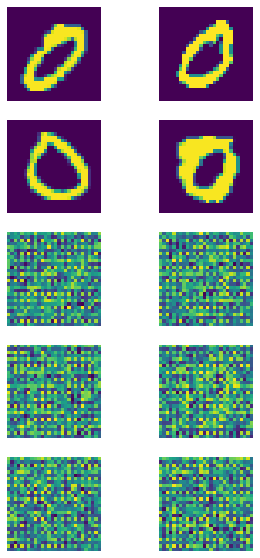

Epoch 01/50 Batch 0000/624, Loss  143.0471


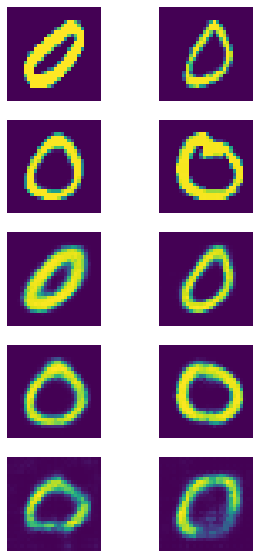

Epoch 02/50 Batch 0000/624, Loss  131.9034


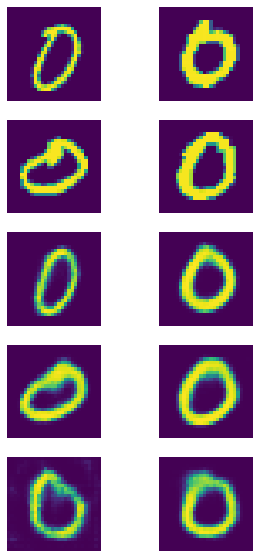

Epoch 03/50 Batch 0000/624, Loss  121.4051


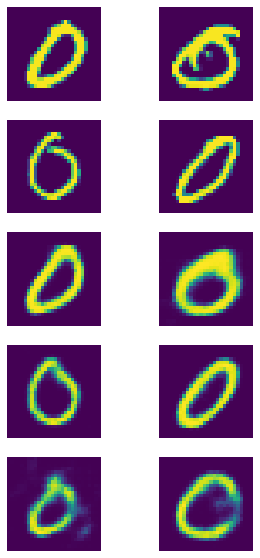

Epoch 04/50 Batch 0000/624, Loss  110.7926


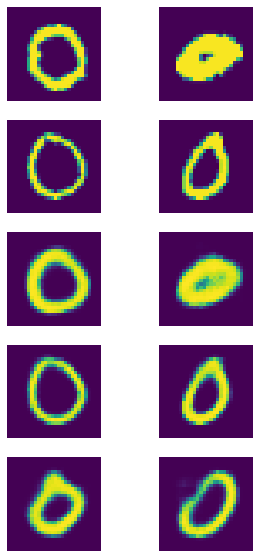

Epoch 05/50 Batch 0000/624, Loss  120.0592


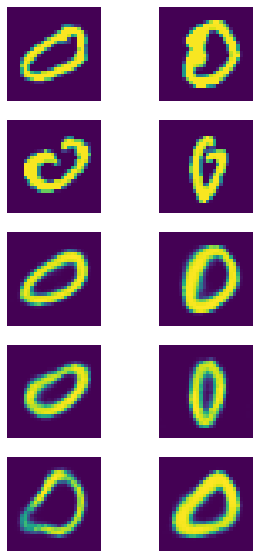

Epoch 06/50 Batch 0000/624, Loss  116.7666


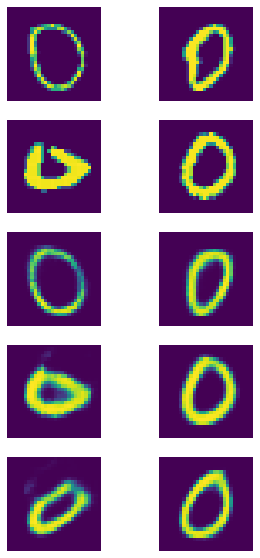

Epoch 07/50 Batch 0000/624, Loss  109.5599


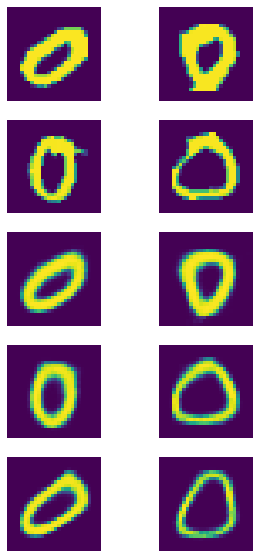

Epoch 08/50 Batch 0000/624, Loss  113.6494


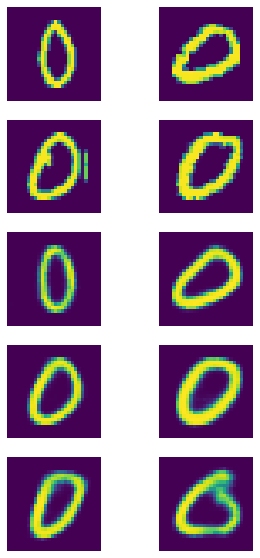

Epoch 09/50 Batch 0000/624, Loss  113.7871


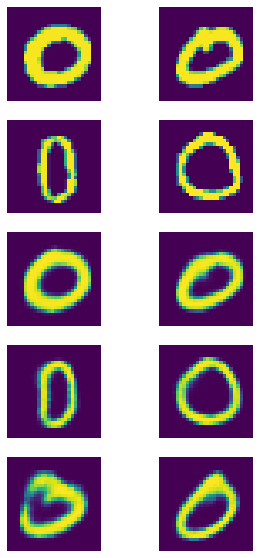

Epoch 10/50 Batch 0000/624, Loss  107.5975


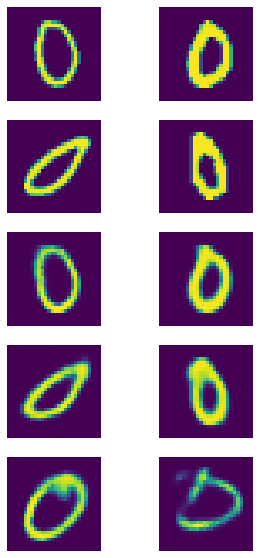

Epoch 11/50 Batch 0000/624, Loss  100.9048


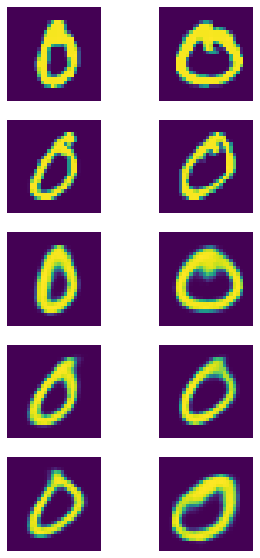

Epoch 12/50 Batch 0000/624, Loss  111.5088


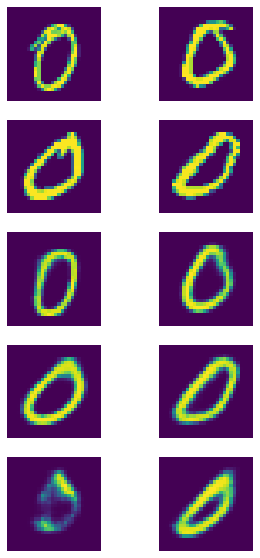

Epoch 13/50 Batch 0000/624, Loss  104.3505


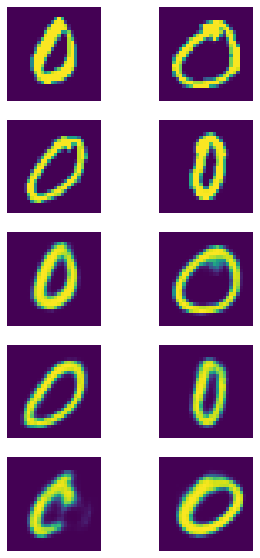

Epoch 14/50 Batch 0000/624, Loss  106.7507


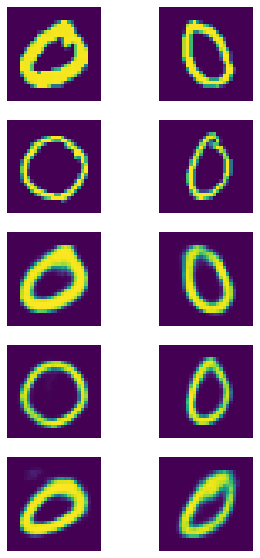

Epoch 15/50 Batch 0000/624, Loss  105.4933


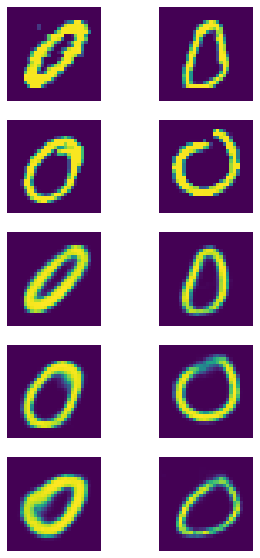

Epoch 16/50 Batch 0000/624, Loss  101.8357


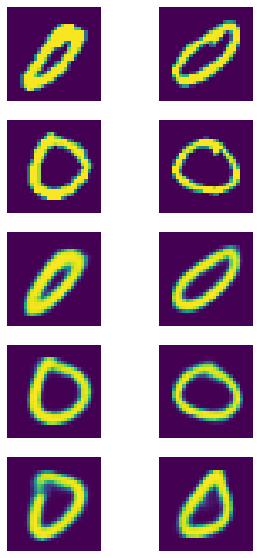

Epoch 17/50 Batch 0000/624, Loss  107.7446


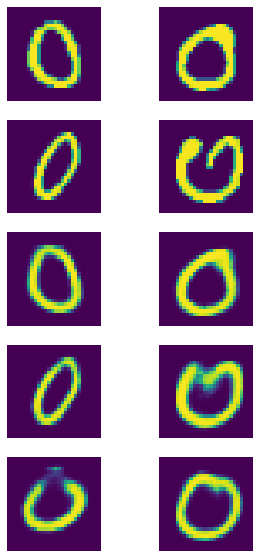

Epoch 18/50 Batch 0000/624, Loss  100.5981


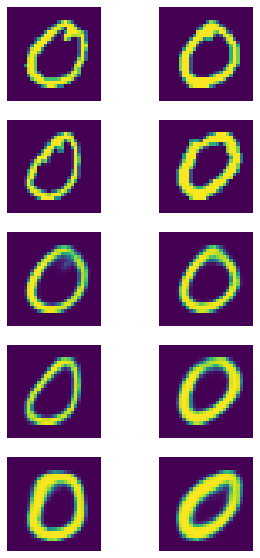

Epoch 19/50 Batch 0000/624, Loss   98.0731


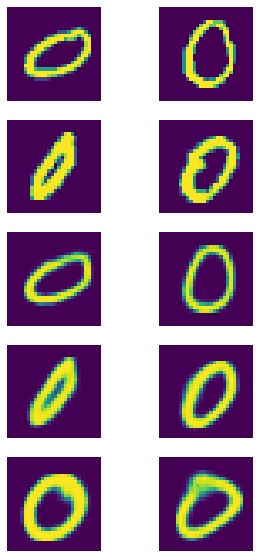

Epoch 20/50 Batch 0000/624, Loss  107.7700


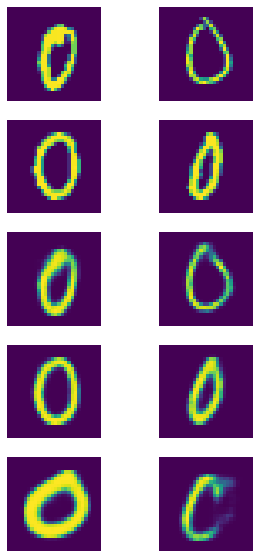

Epoch 21/50 Batch 0000/624, Loss  105.3644


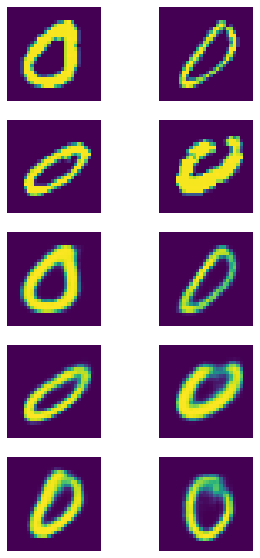

Epoch 22/50 Batch 0000/624, Loss   95.6375


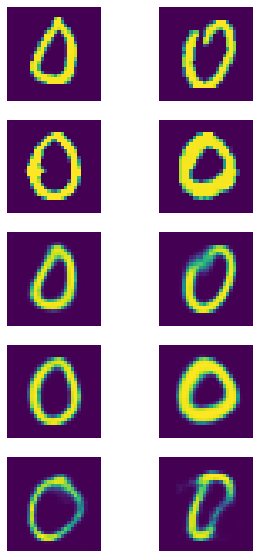

Epoch 23/50 Batch 0000/624, Loss  113.5902


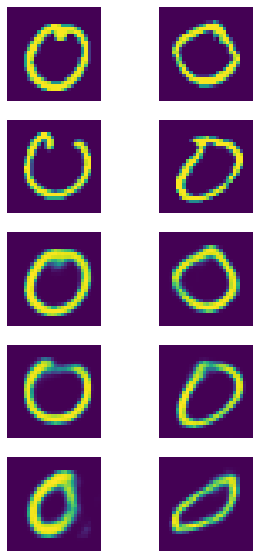

Epoch 24/50 Batch 0000/624, Loss  107.5735


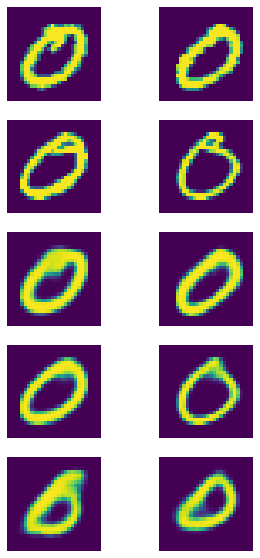

Epoch 25/50 Batch 0000/624, Loss  105.0148


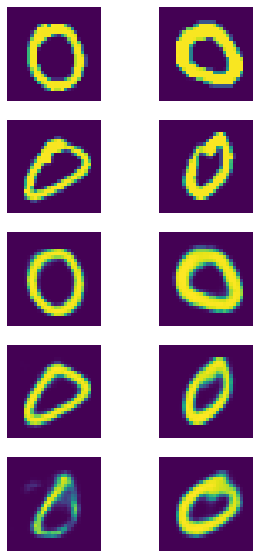

Epoch 26/50 Batch 0000/624, Loss  101.2259


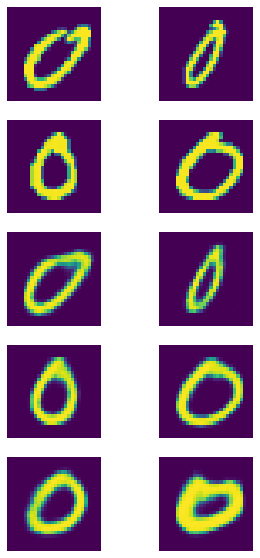

Epoch 27/50 Batch 0000/624, Loss   99.8819


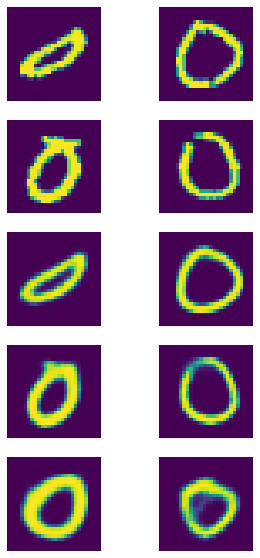

Epoch 28/50 Batch 0000/624, Loss  103.8562


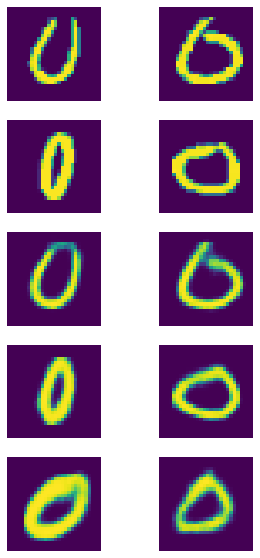

Epoch 29/50 Batch 0000/624, Loss  101.8041


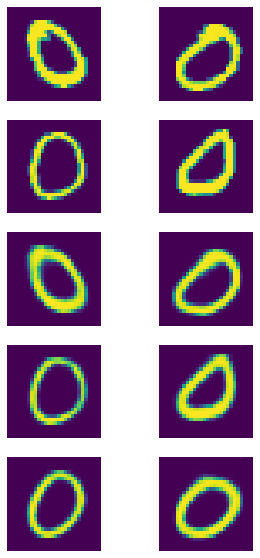

Epoch 30/50 Batch 0000/624, Loss  104.3902


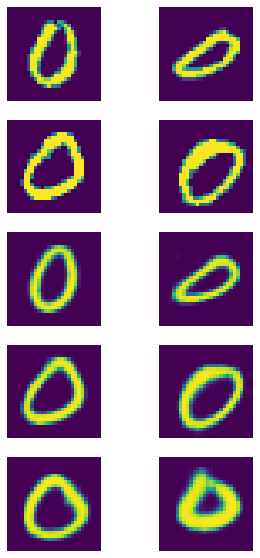

Epoch 31/50 Batch 0000/624, Loss  103.1614


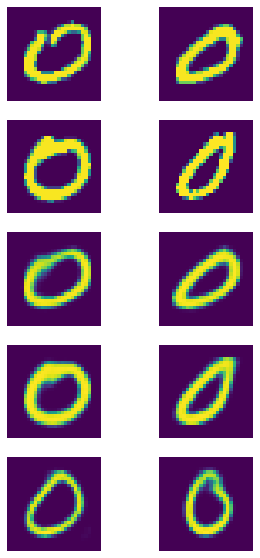

Epoch 32/50 Batch 0000/624, Loss  108.0407


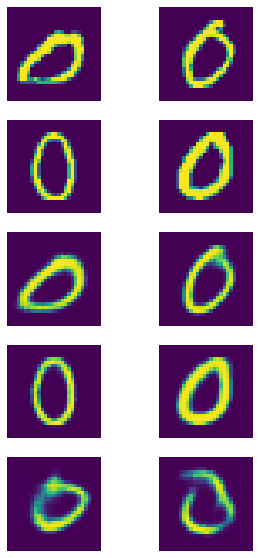

Epoch 33/50 Batch 0000/624, Loss  103.4567


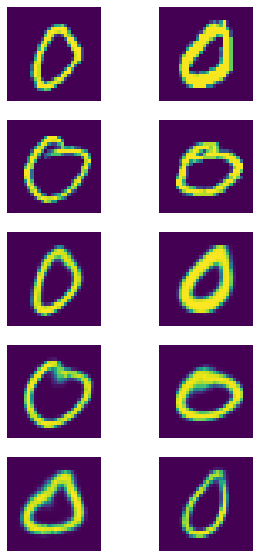

Epoch 34/50 Batch 0000/624, Loss   99.0451


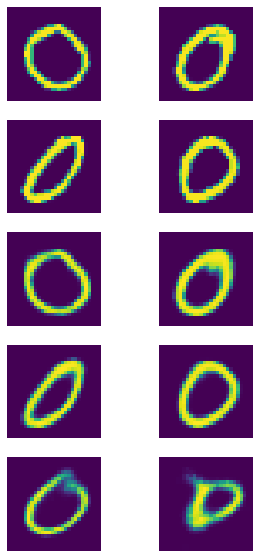

Epoch 35/50 Batch 0000/624, Loss   98.9931


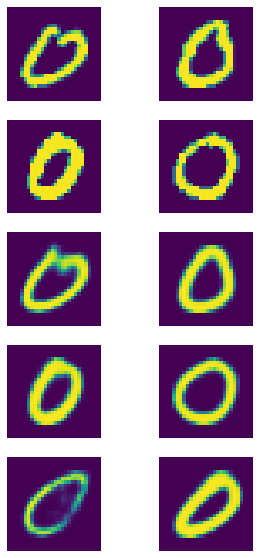

Epoch 36/50 Batch 0000/624, Loss   98.3113


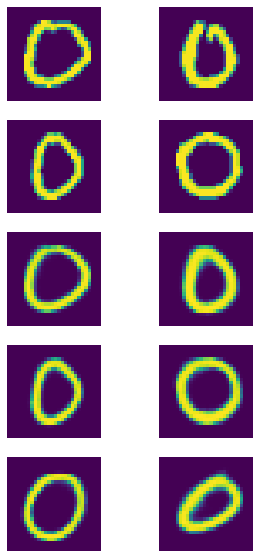

Epoch 37/50 Batch 0000/624, Loss  104.0465


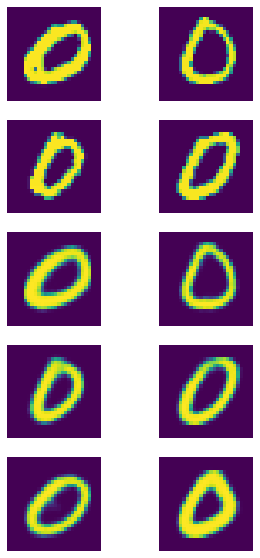

Epoch 38/50 Batch 0000/624, Loss  105.3009


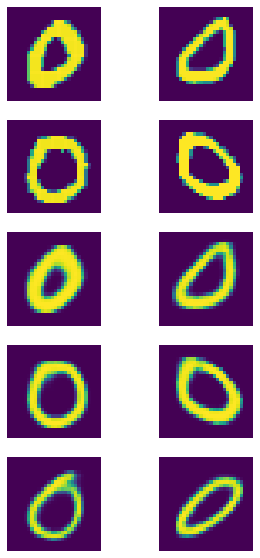

Epoch 39/50 Batch 0000/624, Loss  101.9148


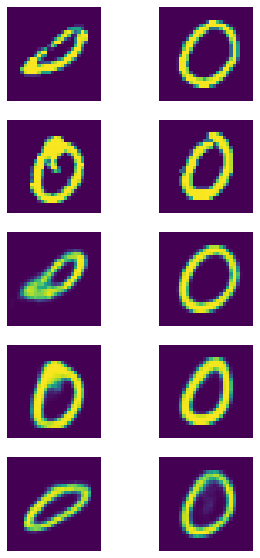

Epoch 40/50 Batch 0000/624, Loss  102.6240


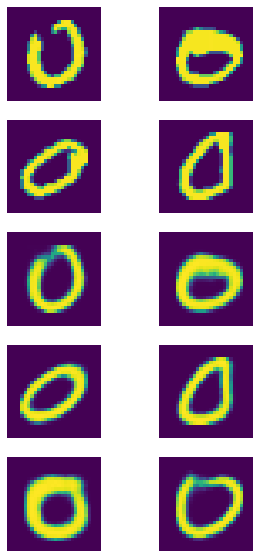

Epoch 41/50 Batch 0000/624, Loss  100.8507


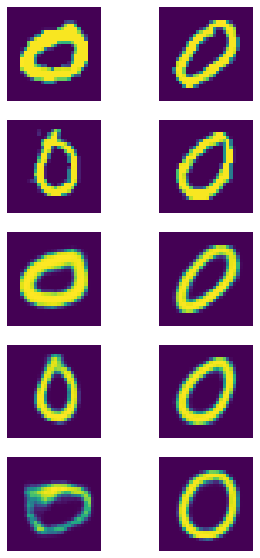

Epoch 42/50 Batch 0000/624, Loss   99.9850


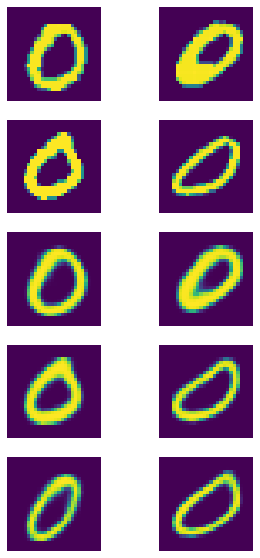

Epoch 43/50 Batch 0000/624, Loss  103.8603


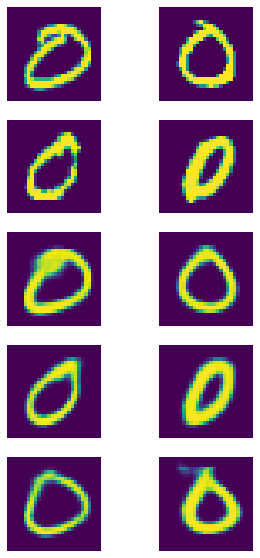

Epoch 44/50 Batch 0000/624, Loss   96.8249


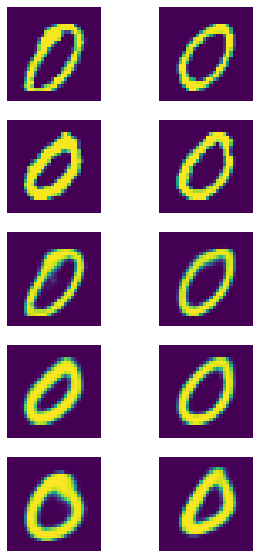

Epoch 45/50 Batch 0000/624, Loss  102.4458


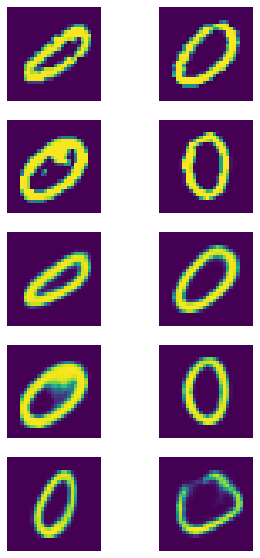

Epoch 46/50 Batch 0000/624, Loss  101.0167


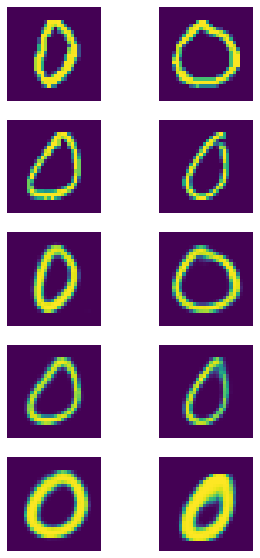

Epoch 47/50 Batch 0000/624, Loss  103.5595


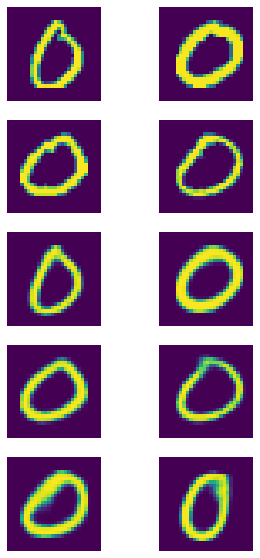

Epoch 48/50 Batch 0000/624, Loss  103.2578


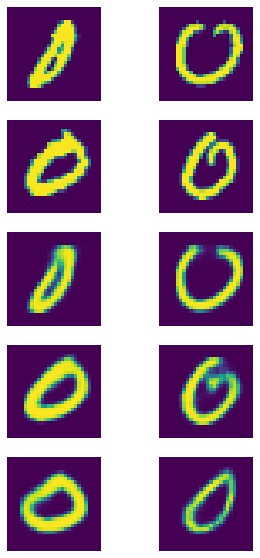

Epoch 49/50 Batch 0000/624, Loss  108.9128


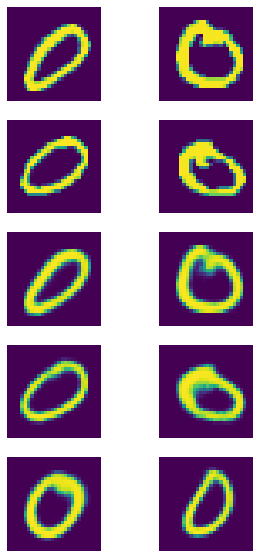

Epoch 00/50 Batch 0000/624, Loss  613.1036


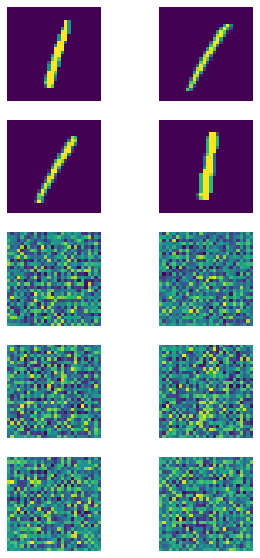

Epoch 01/50 Batch 0000/624, Loss   69.2826


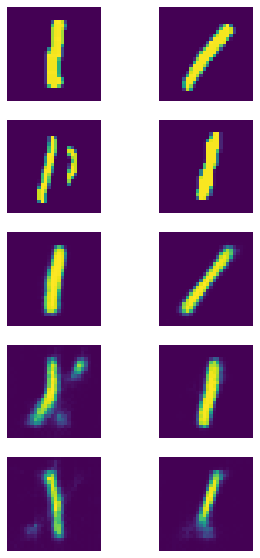

Epoch 02/50 Batch 0000/624, Loss   65.7363


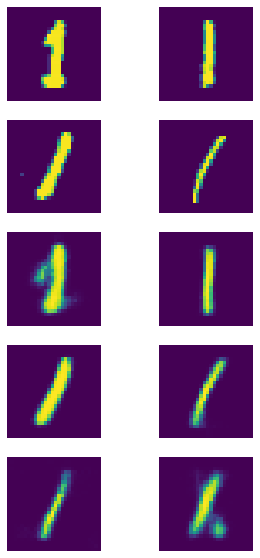

Epoch 03/50 Batch 0000/624, Loss   61.2668


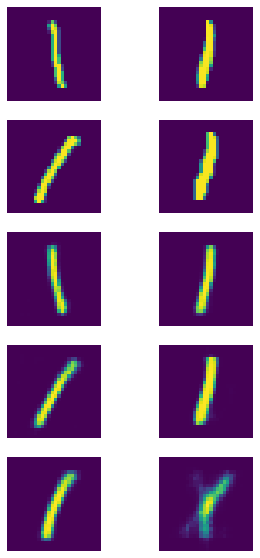

Epoch 04/50 Batch 0000/624, Loss   53.5241


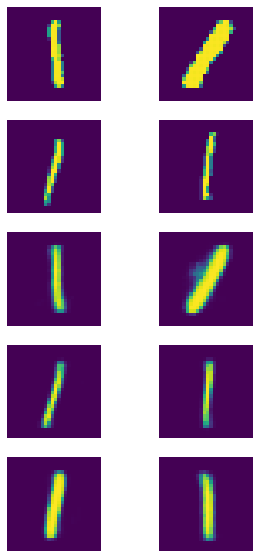

Epoch 05/50 Batch 0000/624, Loss   49.0783


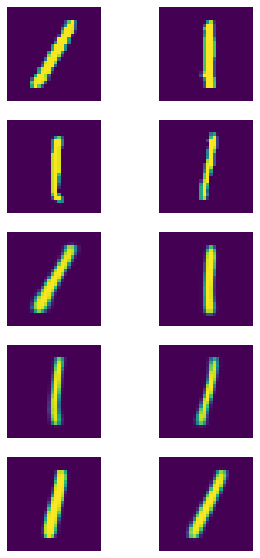

Epoch 06/50 Batch 0000/624, Loss   49.4572


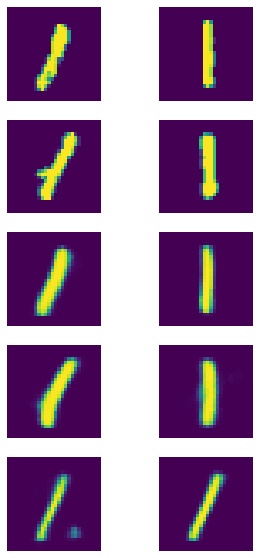

Epoch 07/50 Batch 0000/624, Loss   51.5896


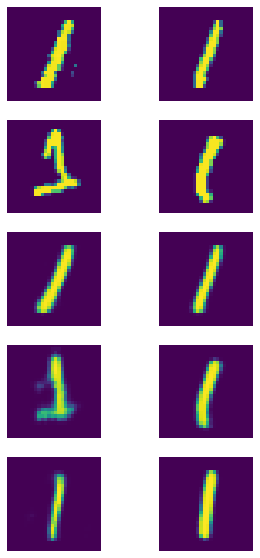

Epoch 08/50 Batch 0000/624, Loss   51.4670


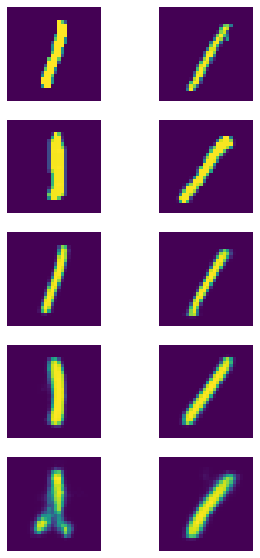

Epoch 09/50 Batch 0000/624, Loss   47.3921


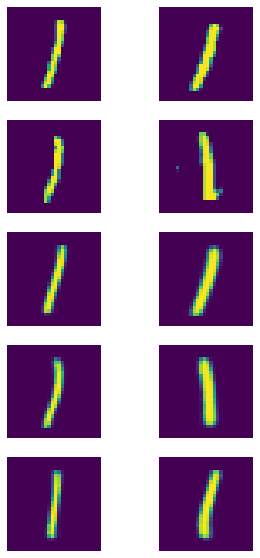

Epoch 10/50 Batch 0000/624, Loss   45.4071


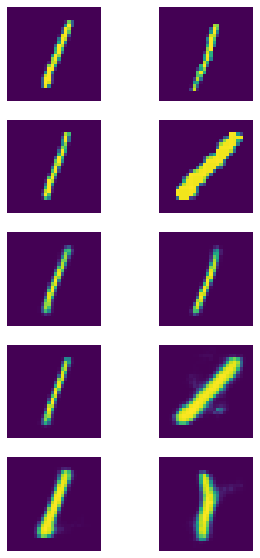

Epoch 11/50 Batch 0000/624, Loss   51.2212


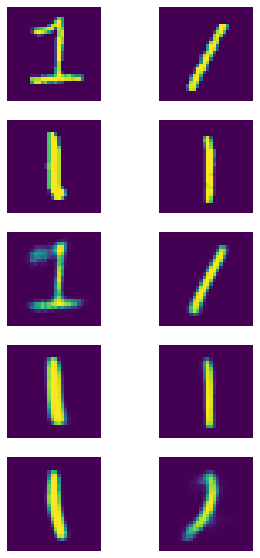

Epoch 12/50 Batch 0000/624, Loss   46.0809


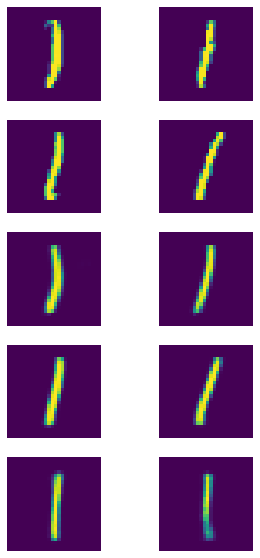

Epoch 13/50 Batch 0000/624, Loss   47.6378


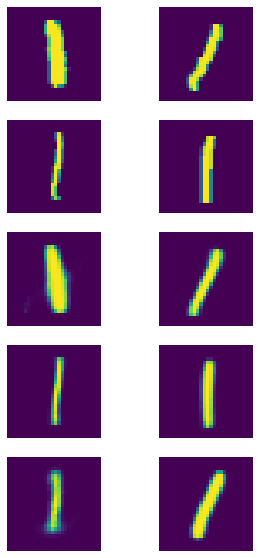

Epoch 14/50 Batch 0000/624, Loss   45.4127


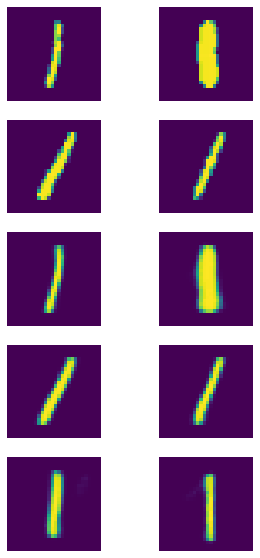

Epoch 15/50 Batch 0000/624, Loss   46.5349


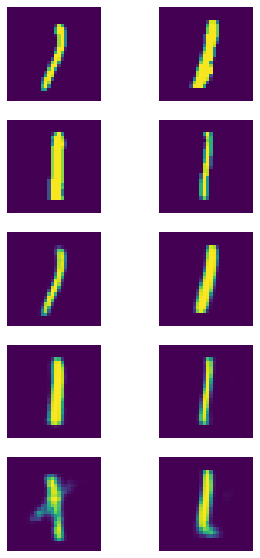

Epoch 16/50 Batch 0000/624, Loss   46.6188


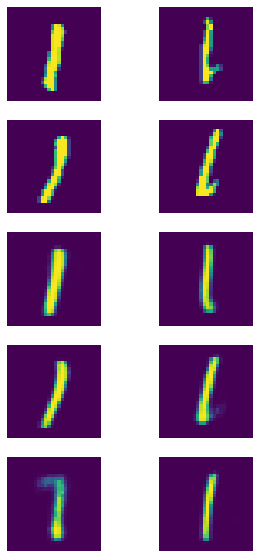

Epoch 17/50 Batch 0000/624, Loss   48.5248


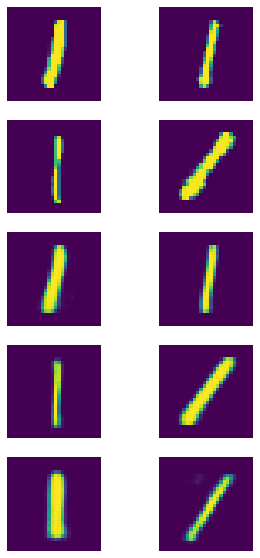

Epoch 18/50 Batch 0000/624, Loss   47.1459


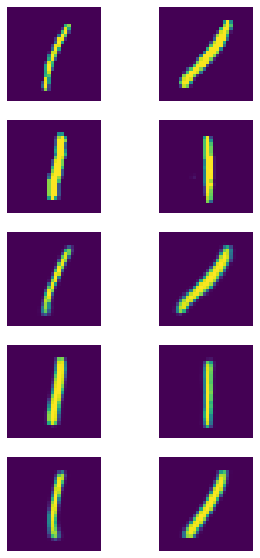

Epoch 19/50 Batch 0000/624, Loss   51.2726


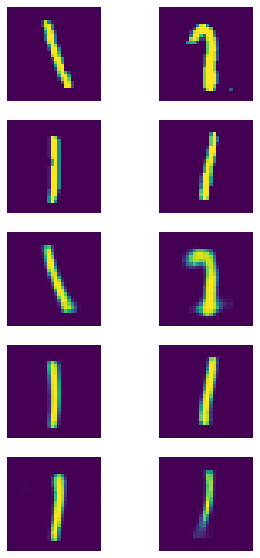

Epoch 20/50 Batch 0000/624, Loss   45.3180


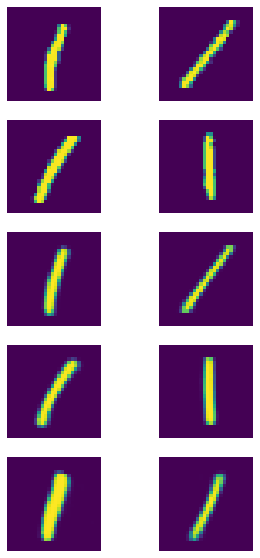

Epoch 21/50 Batch 0000/624, Loss   47.9574


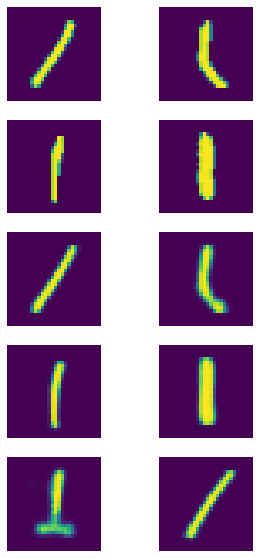

Epoch 22/50 Batch 0000/624, Loss   46.1325


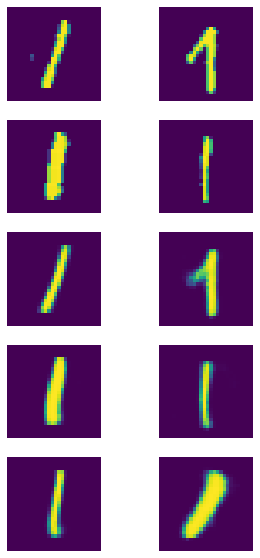

Epoch 23/50 Batch 0000/624, Loss   44.9488


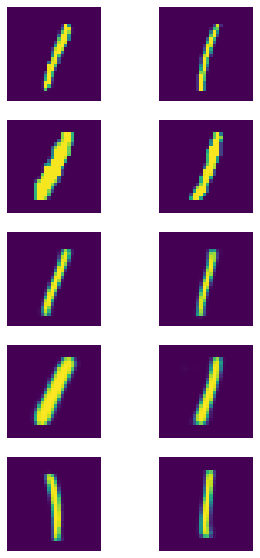

Epoch 24/50 Batch 0000/624, Loss   47.8157


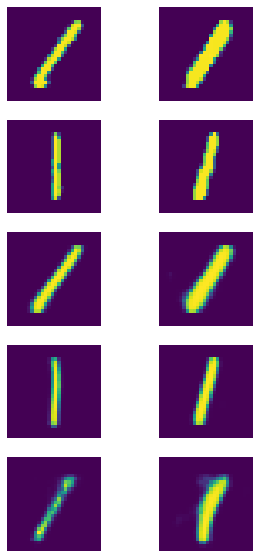

Epoch 25/50 Batch 0000/624, Loss   46.4319


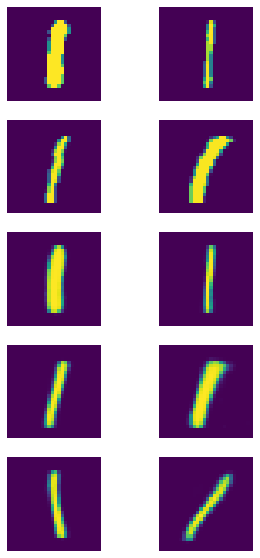

Epoch 26/50 Batch 0000/624, Loss   49.2533


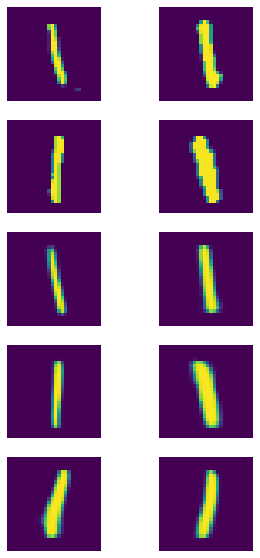

Epoch 27/50 Batch 0000/624, Loss   51.6596


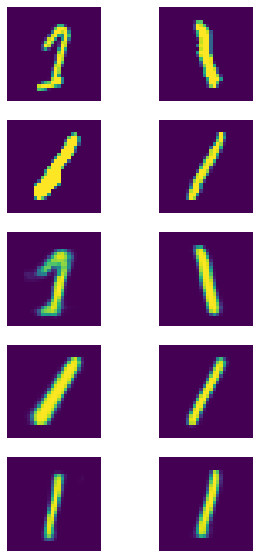

Epoch 28/50 Batch 0000/624, Loss   51.0474


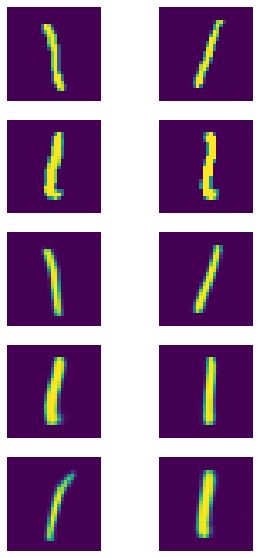

Epoch 29/50 Batch 0000/624, Loss   47.2607


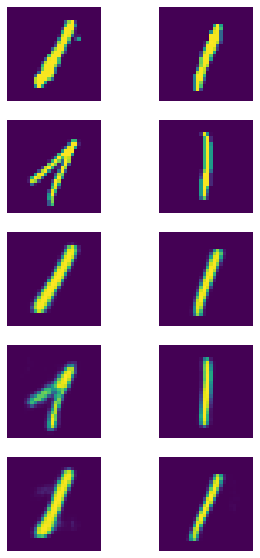

Epoch 30/50 Batch 0000/624, Loss   42.5000


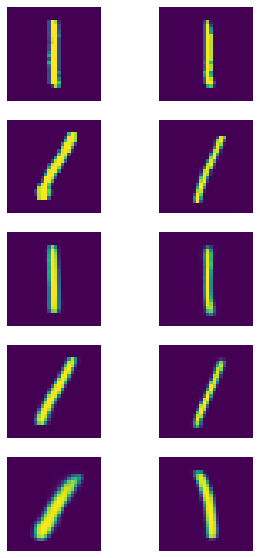

Epoch 31/50 Batch 0000/624, Loss   45.2884


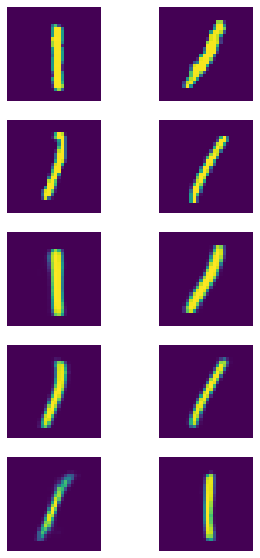

Epoch 32/50 Batch 0000/624, Loss   46.2605


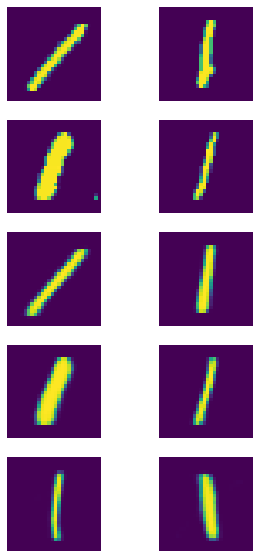

Epoch 33/50 Batch 0000/624, Loss   45.1277


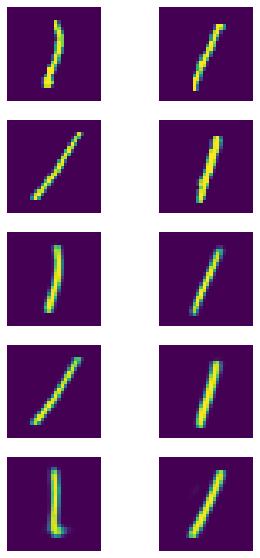

Epoch 34/50 Batch 0000/624, Loss   44.0797


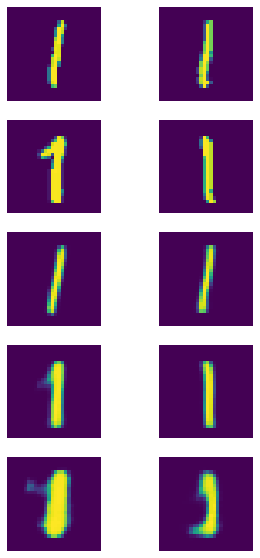

Epoch 35/50 Batch 0000/624, Loss   47.9102


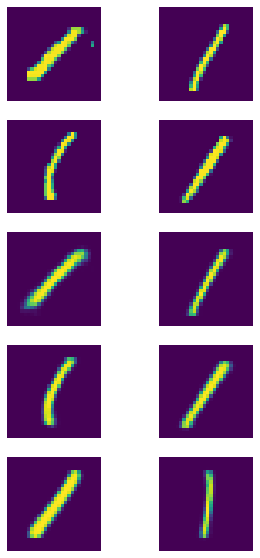

Epoch 36/50 Batch 0000/624, Loss   50.3608


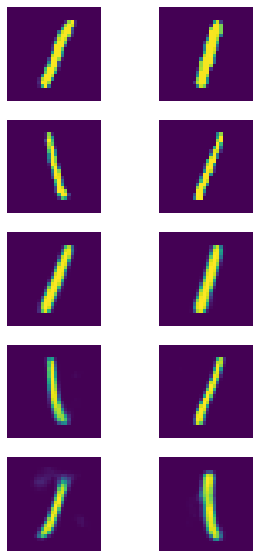

Epoch 37/50 Batch 0000/624, Loss   48.3874


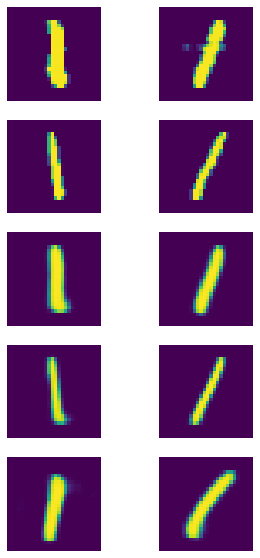

Epoch 38/50 Batch 0000/624, Loss   46.9334


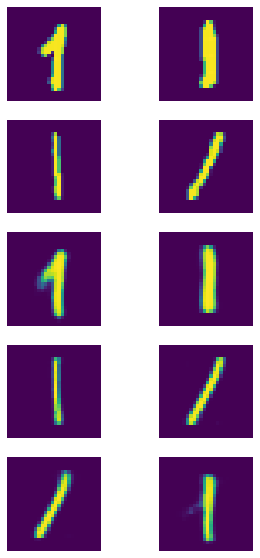

Epoch 39/50 Batch 0000/624, Loss   46.9062


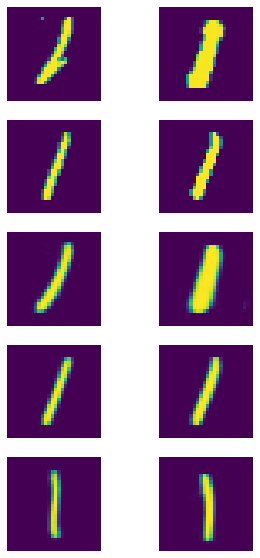

Epoch 40/50 Batch 0000/624, Loss   55.0783


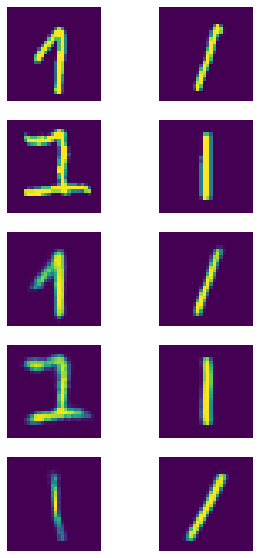

Epoch 41/50 Batch 0000/624, Loss   47.7146


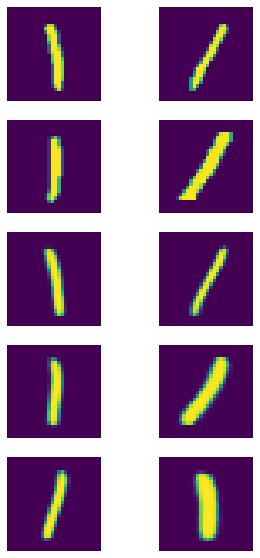

Epoch 42/50 Batch 0000/624, Loss   44.6739


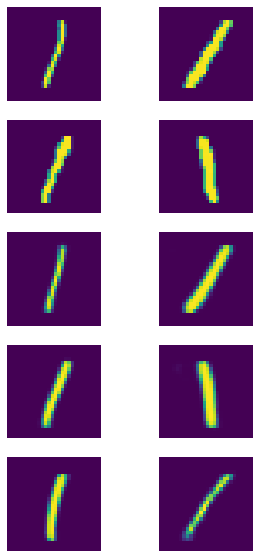

Epoch 43/50 Batch 0000/624, Loss   46.0910


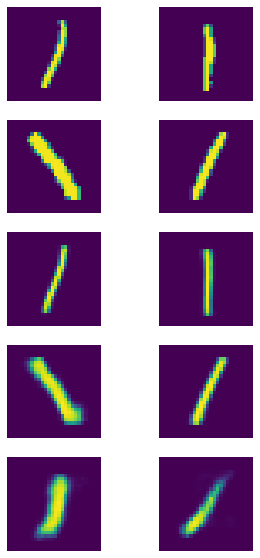

Epoch 44/50 Batch 0000/624, Loss   45.2560


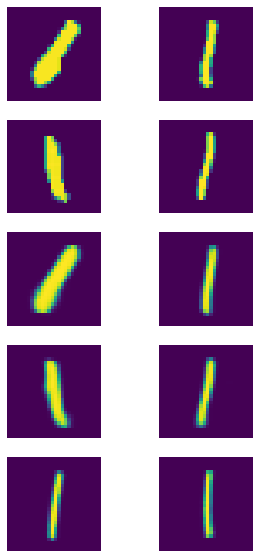

Epoch 45/50 Batch 0000/624, Loss   43.2848


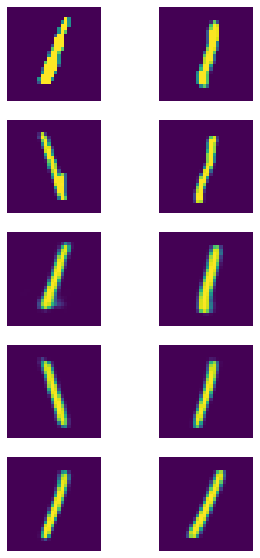

Epoch 46/50 Batch 0000/624, Loss   48.3677


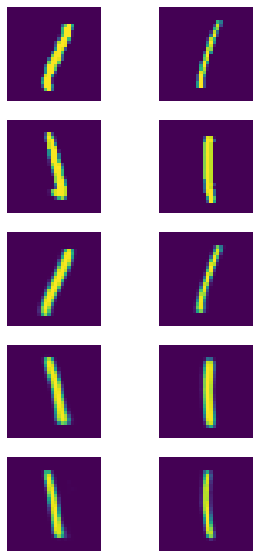

Epoch 47/50 Batch 0000/624, Loss   46.2824


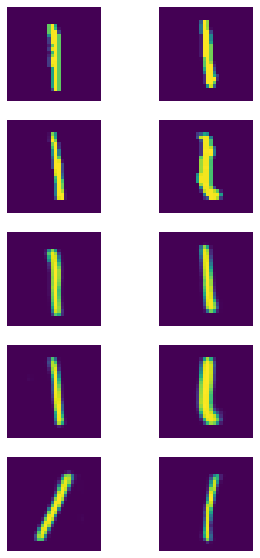

Epoch 48/50 Batch 0000/624, Loss   43.6296


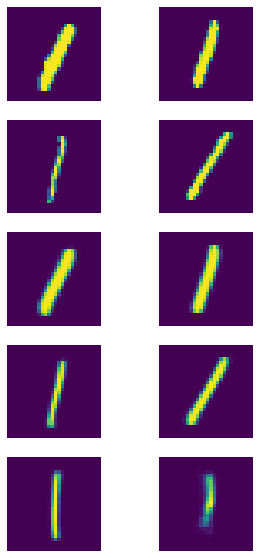

Epoch 49/50 Batch 0000/624, Loss   47.4003


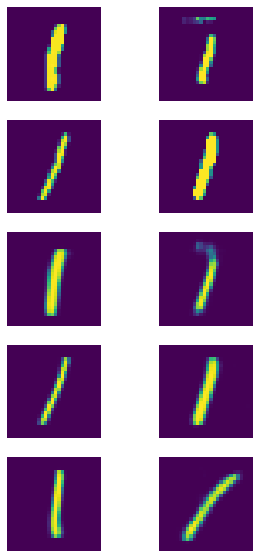

Epoch 00/50 Batch 0000/624, Loss  762.6207


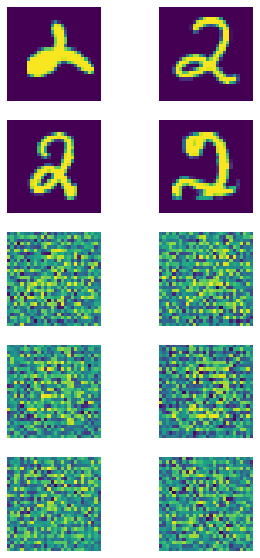

Epoch 01/50 Batch 0000/624, Loss  150.1256


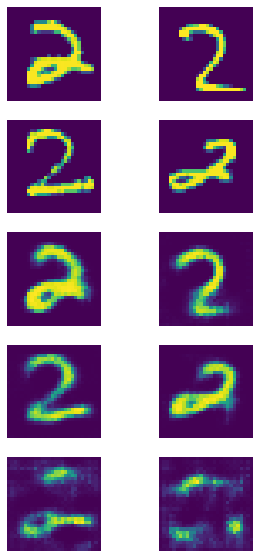

Epoch 02/50 Batch 0000/624, Loss  132.9152


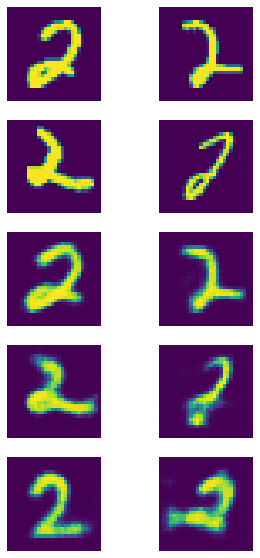

Epoch 03/50 Batch 0000/624, Loss  131.8132


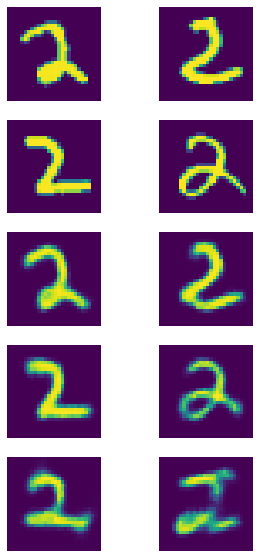

Epoch 04/50 Batch 0000/624, Loss  119.8092


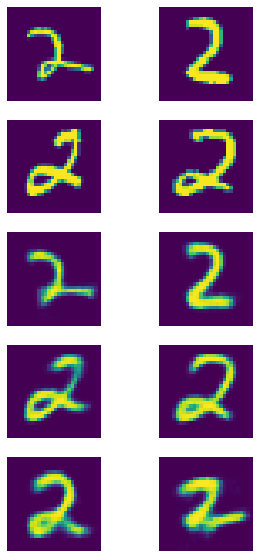

Epoch 05/50 Batch 0000/624, Loss  118.3499


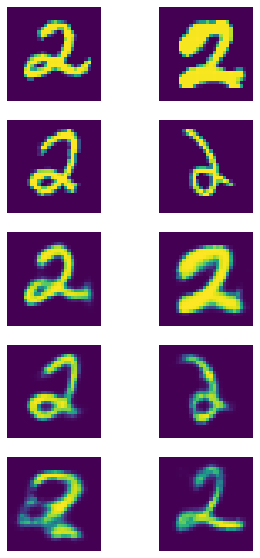

Epoch 06/50 Batch 0000/624, Loss  111.9772


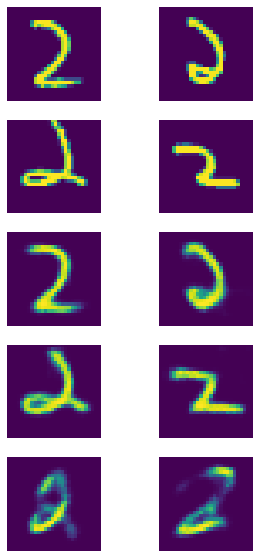

Epoch 07/50 Batch 0000/624, Loss  114.4349


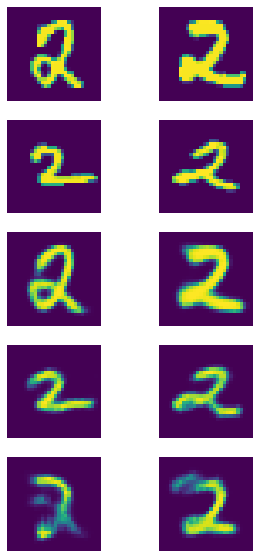

Epoch 08/50 Batch 0000/624, Loss  110.0094


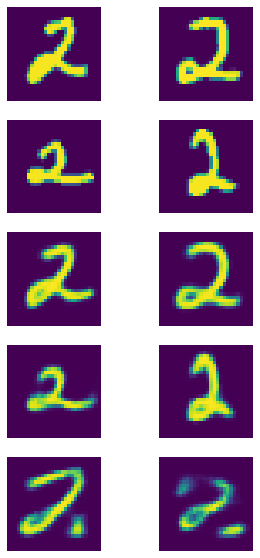

Epoch 09/50 Batch 0000/624, Loss  107.9263


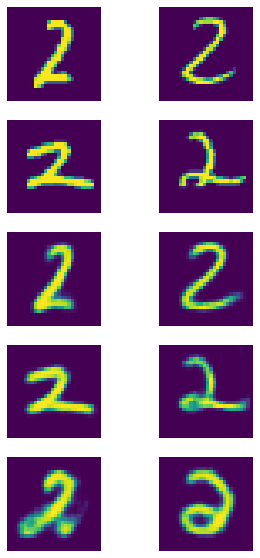

Epoch 10/50 Batch 0000/624, Loss  112.8606


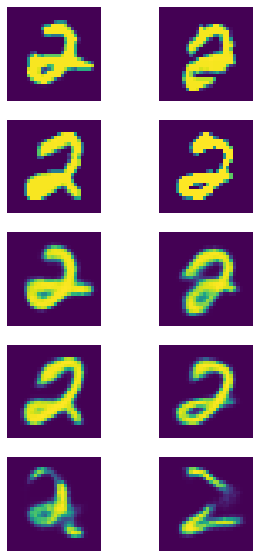

Epoch 11/50 Batch 0000/624, Loss  110.5253


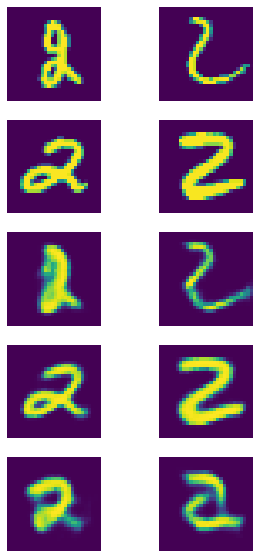

Epoch 12/50 Batch 0000/624, Loss  107.7112


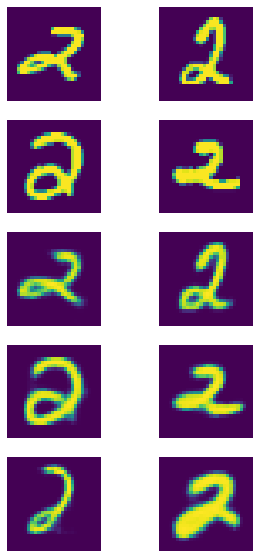

Epoch 13/50 Batch 0000/624, Loss  118.8508


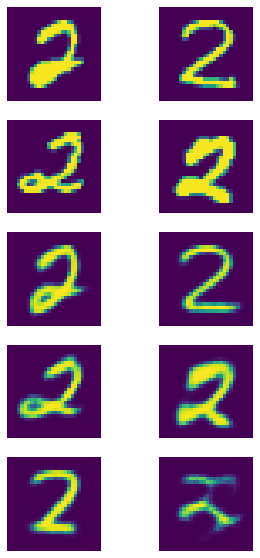

Epoch 14/50 Batch 0000/624, Loss  112.6444


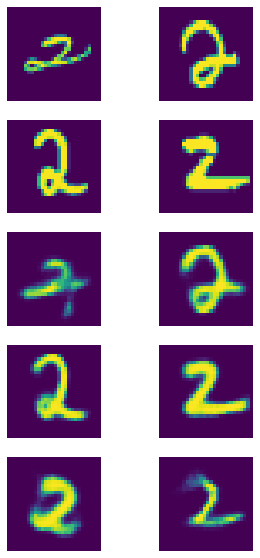

Epoch 15/50 Batch 0000/624, Loss  115.2168


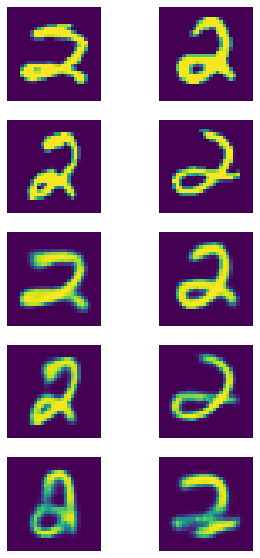

Epoch 16/50 Batch 0000/624, Loss  106.2123


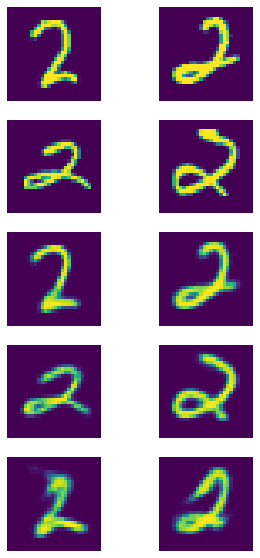

Epoch 17/50 Batch 0000/624, Loss  104.1020


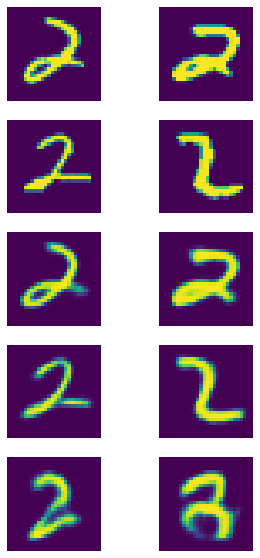

Epoch 18/50 Batch 0000/624, Loss  108.8216


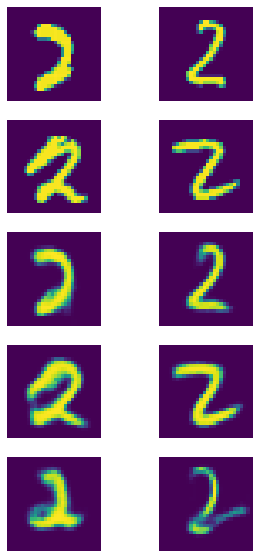

Epoch 19/50 Batch 0000/624, Loss  108.5171


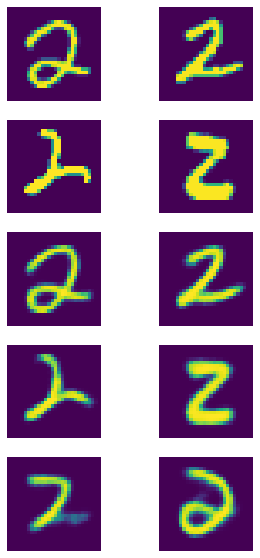

Epoch 20/50 Batch 0000/624, Loss  116.4523


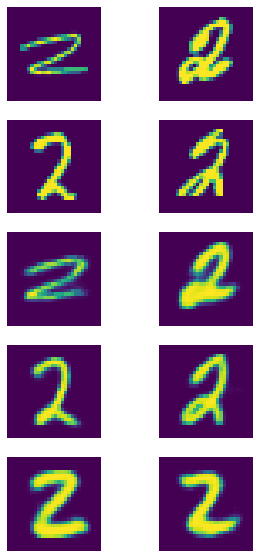

Epoch 21/50 Batch 0000/624, Loss  108.5798


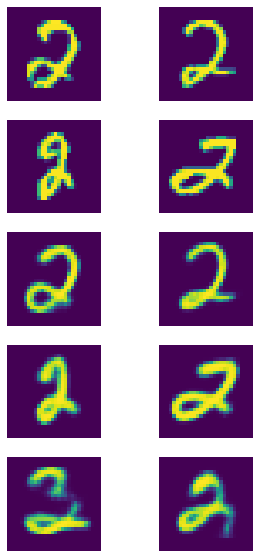

Epoch 22/50 Batch 0000/624, Loss  106.0372


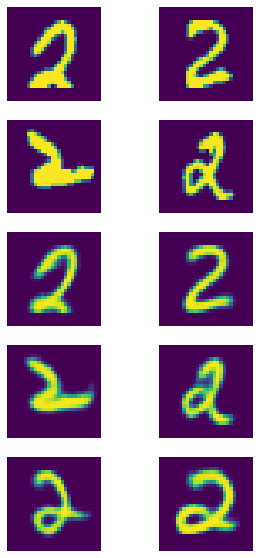

Epoch 23/50 Batch 0000/624, Loss  117.7426


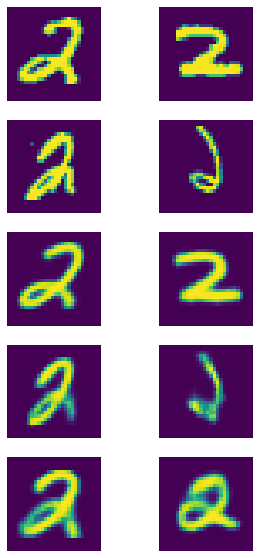

Epoch 24/50 Batch 0000/624, Loss  110.8352


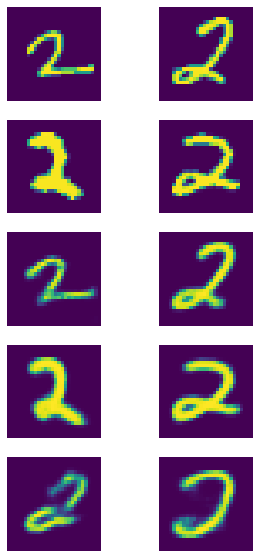

Epoch 25/50 Batch 0000/624, Loss  103.8417


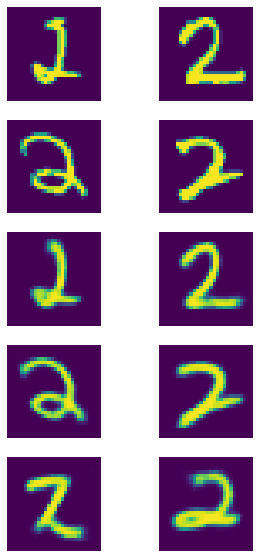

Epoch 26/50 Batch 0000/624, Loss  103.8873


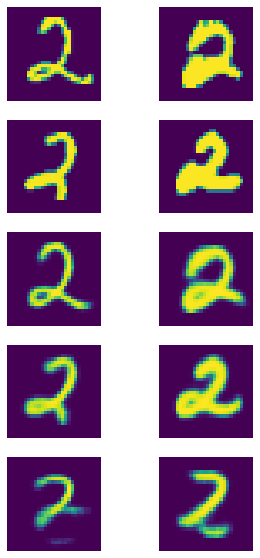

Epoch 27/50 Batch 0000/624, Loss  116.2293


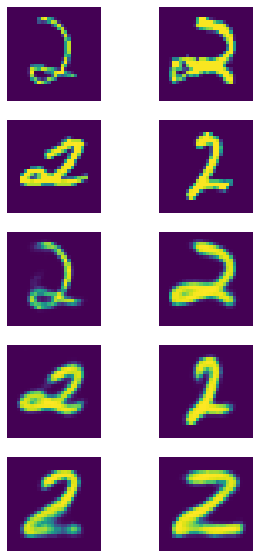

Epoch 28/50 Batch 0000/624, Loss  102.8070


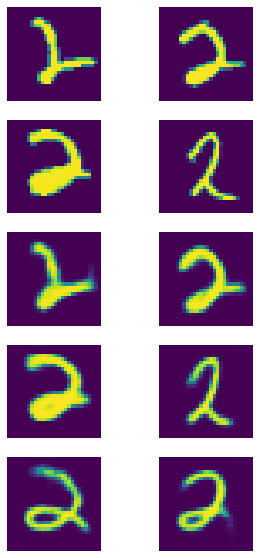

Epoch 29/50 Batch 0000/624, Loss  103.8430


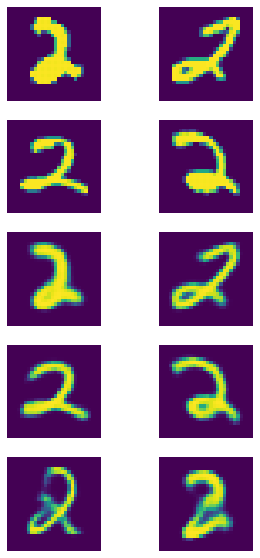

Epoch 30/50 Batch 0000/624, Loss  103.6303


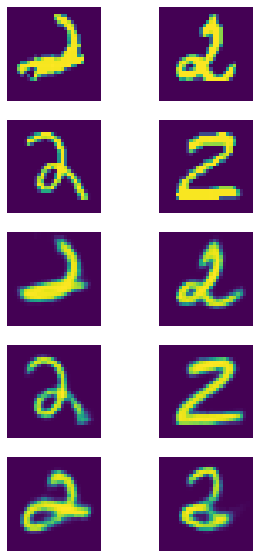

Epoch 31/50 Batch 0000/624, Loss  108.3142


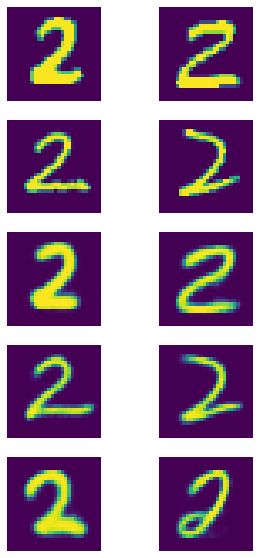

Epoch 32/50 Batch 0000/624, Loss  102.6056


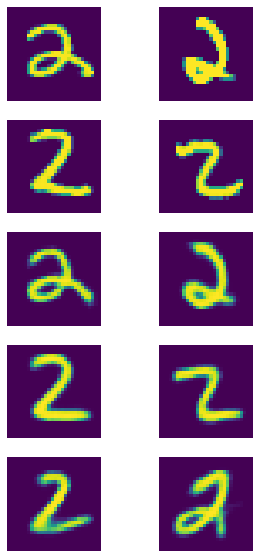

Epoch 33/50 Batch 0000/624, Loss  111.1833


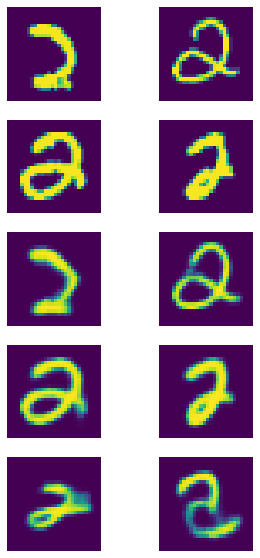

Epoch 34/50 Batch 0000/624, Loss  104.7742


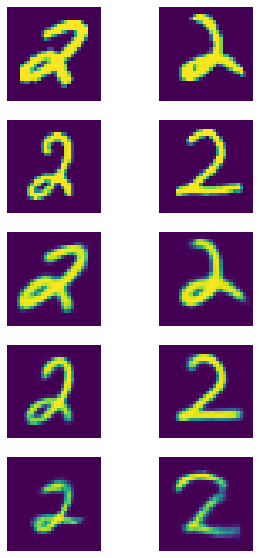

Epoch 35/50 Batch 0000/624, Loss  105.8628


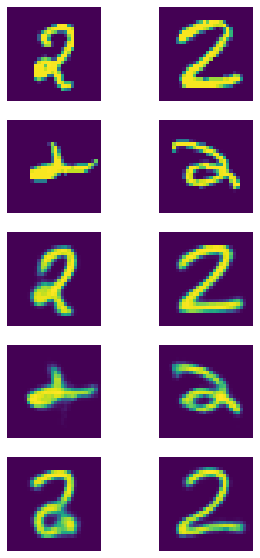

Epoch 36/50 Batch 0000/624, Loss  106.2903


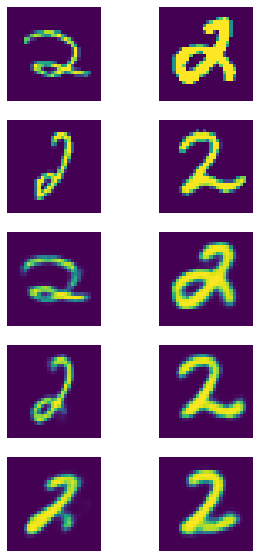

Epoch 37/50 Batch 0000/624, Loss  108.5899


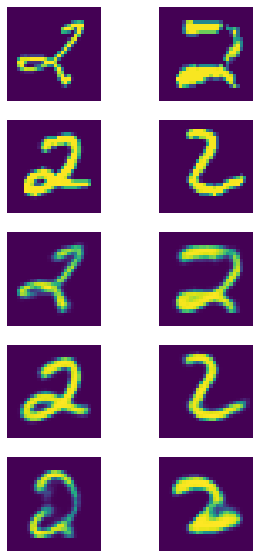

Epoch 38/50 Batch 0000/624, Loss   98.9016


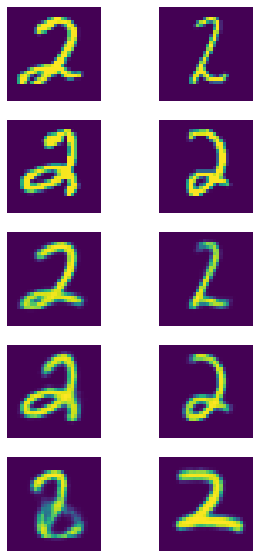

Epoch 39/50 Batch 0000/624, Loss  106.4519


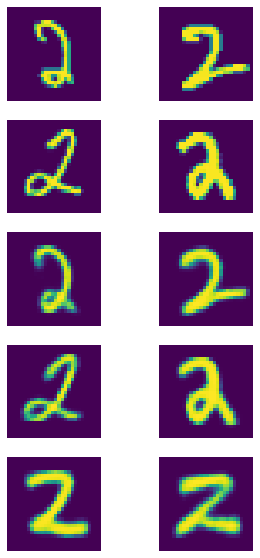

Epoch 40/50 Batch 0000/624, Loss  101.8269


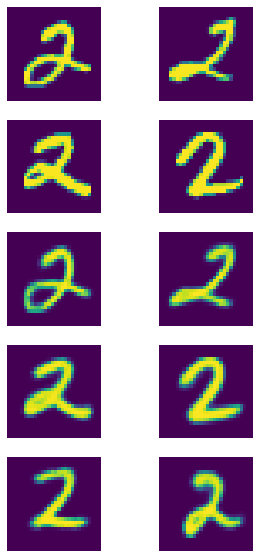

Epoch 41/50 Batch 0000/624, Loss  101.9310


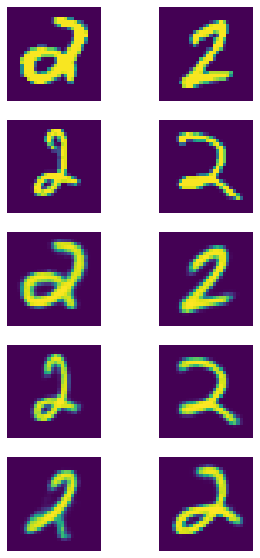

Epoch 42/50 Batch 0000/624, Loss  104.5635


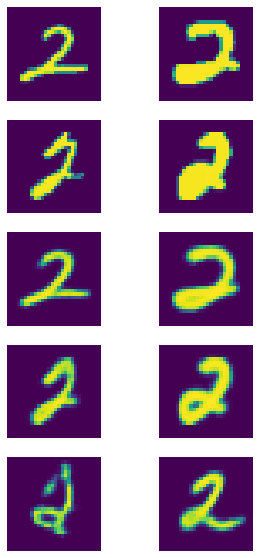

Epoch 43/50 Batch 0000/624, Loss  107.4429


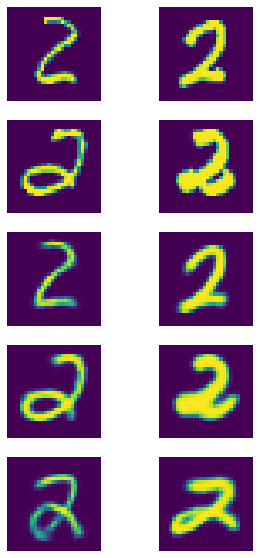

Epoch 44/50 Batch 0000/624, Loss  102.9960


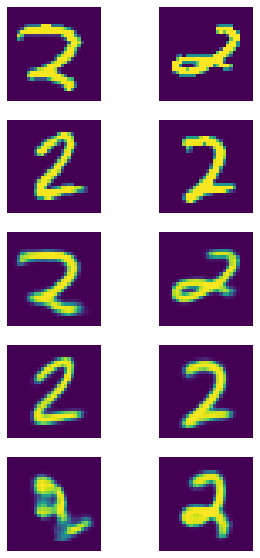

Epoch 45/50 Batch 0000/624, Loss  104.1145


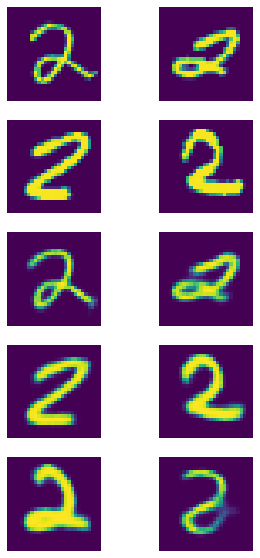

Epoch 46/50 Batch 0000/624, Loss  108.2757


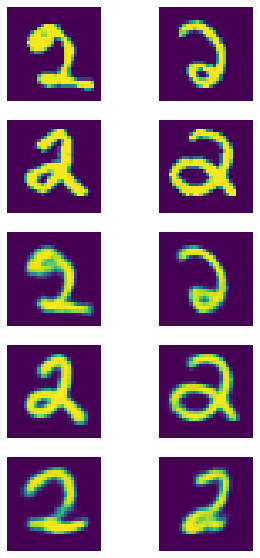

Epoch 47/50 Batch 0000/624, Loss  108.2532


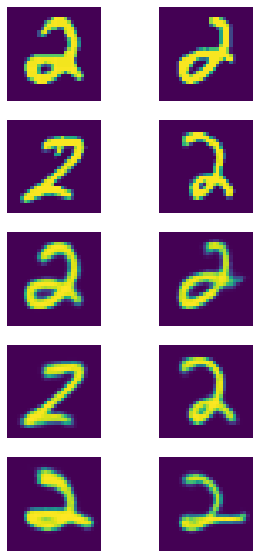

Epoch 48/50 Batch 0000/624, Loss  107.3016


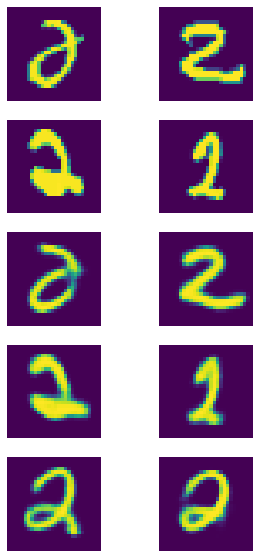

Epoch 49/50 Batch 0000/624, Loss  103.1711


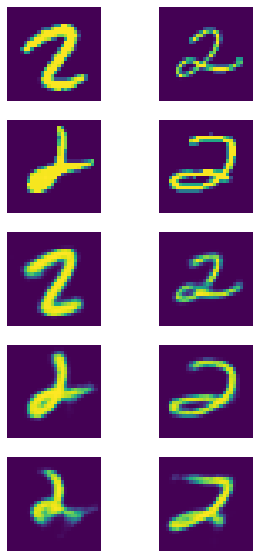

Epoch 00/50 Batch 0000/624, Loss  624.2627


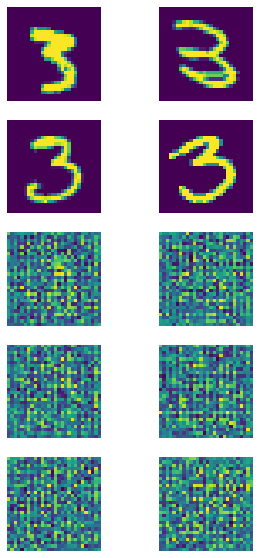

Epoch 01/50 Batch 0000/624, Loss  134.0585


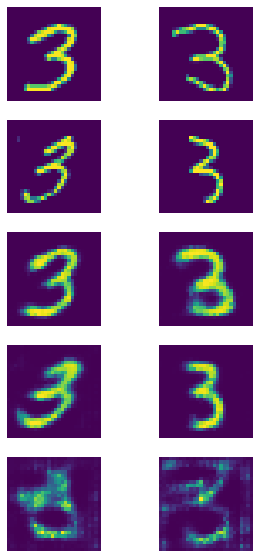

Epoch 02/50 Batch 0000/624, Loss  132.3394


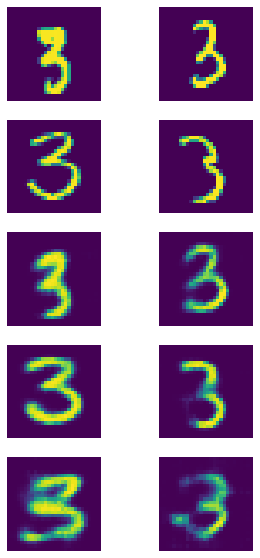

Epoch 03/50 Batch 0000/624, Loss  110.5378


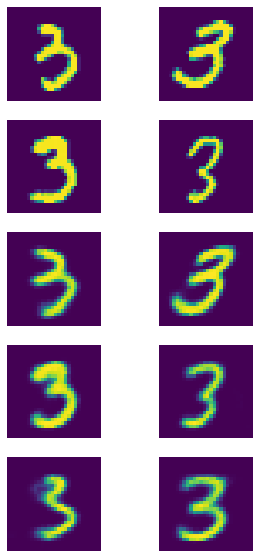

Epoch 04/50 Batch 0000/624, Loss  115.3400


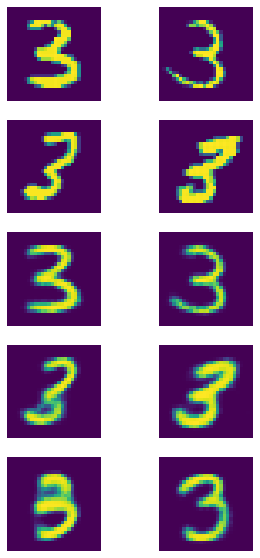

Epoch 05/50 Batch 0000/624, Loss  115.2100


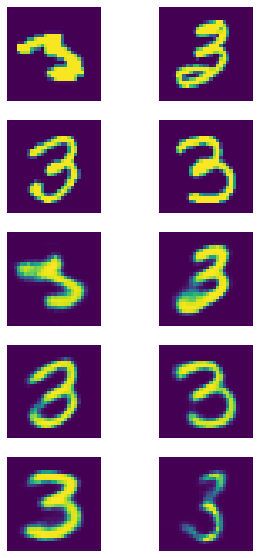

Epoch 06/50 Batch 0000/624, Loss  114.5266


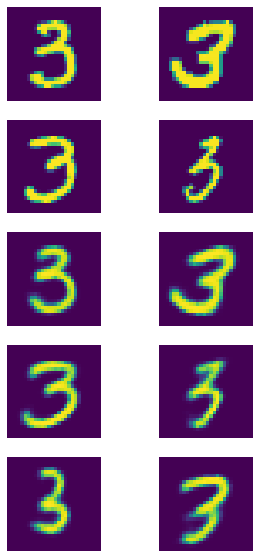

Epoch 07/50 Batch 0000/624, Loss  110.4363


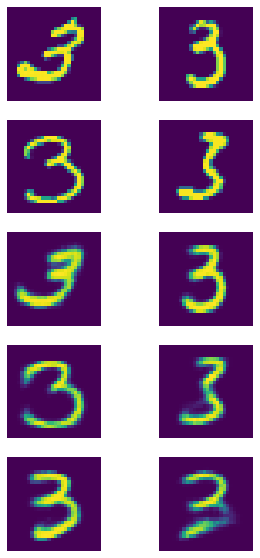

Epoch 08/50 Batch 0000/624, Loss  107.2564


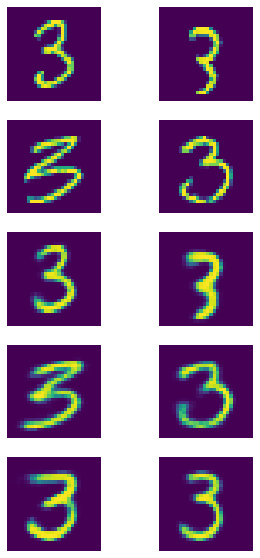

Epoch 09/50 Batch 0000/624, Loss  110.3877


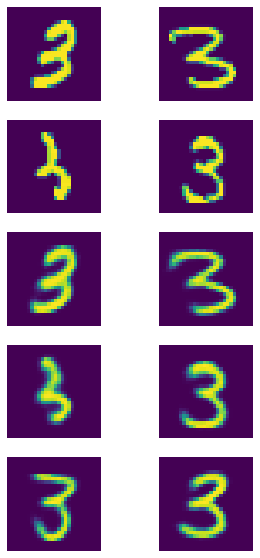

Epoch 10/50 Batch 0000/624, Loss  104.3720


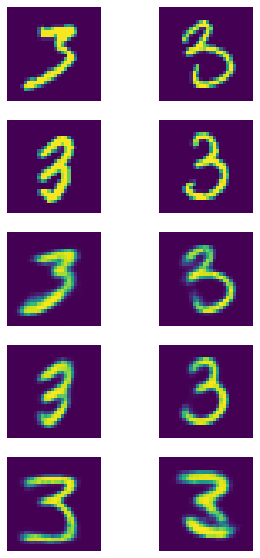

Epoch 11/50 Batch 0000/624, Loss  101.2825


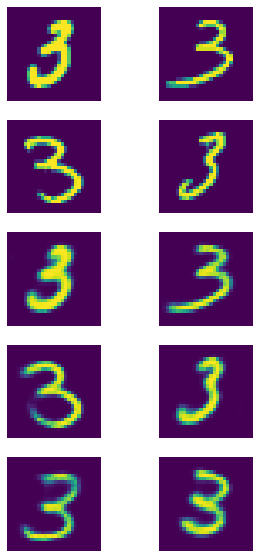

Epoch 12/50 Batch 0000/624, Loss  102.8646


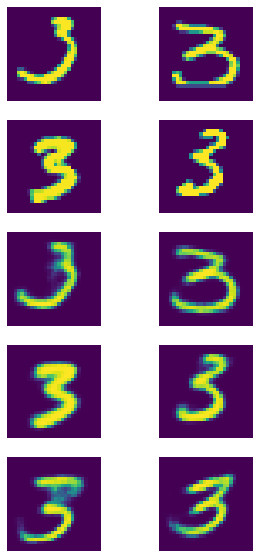

Epoch 13/50 Batch 0000/624, Loss  103.5254


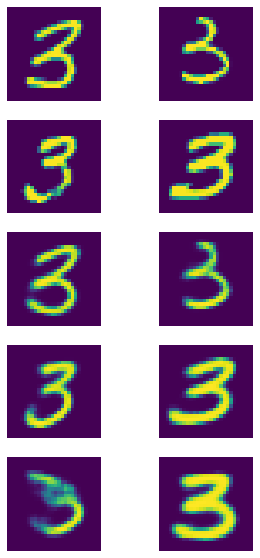

Epoch 14/50 Batch 0000/624, Loss   99.8684


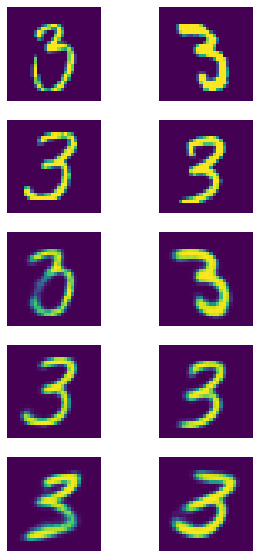

Epoch 15/50 Batch 0000/624, Loss  101.5797


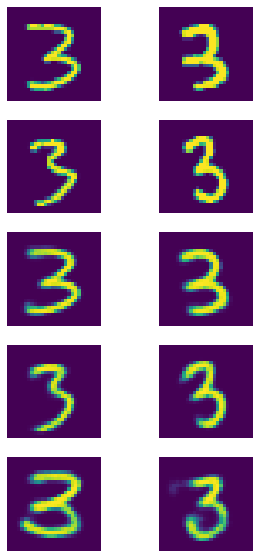

Epoch 16/50 Batch 0000/624, Loss  102.5386


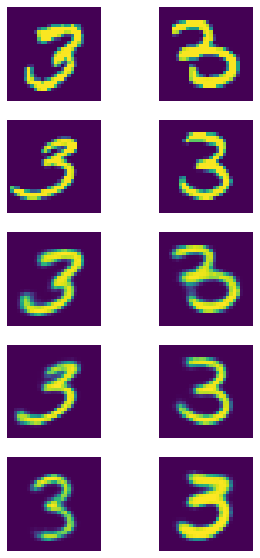

Epoch 17/50 Batch 0000/624, Loss  106.5021


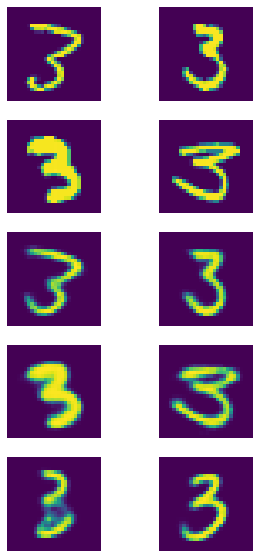

Epoch 18/50 Batch 0000/624, Loss  110.4208


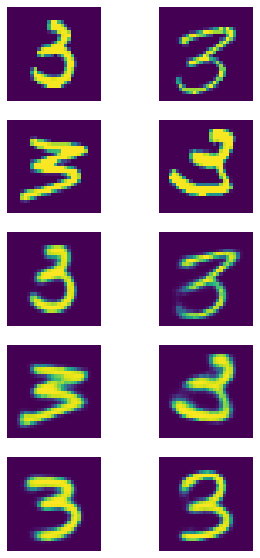

Epoch 19/50 Batch 0000/624, Loss  100.2229


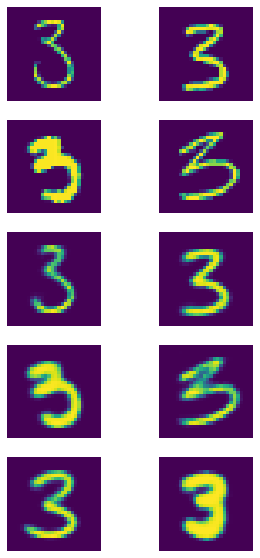

Epoch 20/50 Batch 0000/624, Loss  101.4751


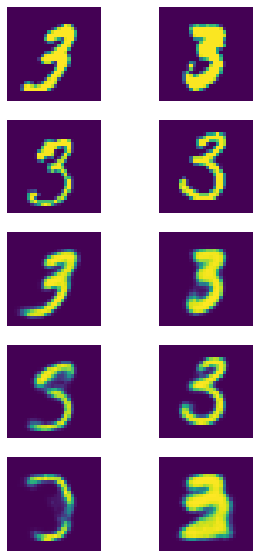

Epoch 21/50 Batch 0000/624, Loss  104.8524


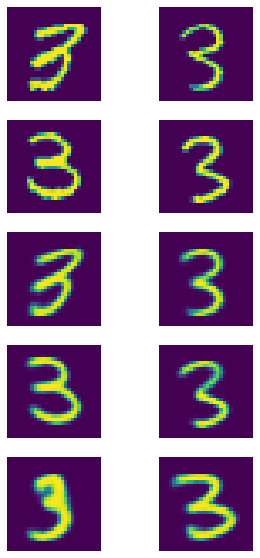

Epoch 22/50 Batch 0000/624, Loss  107.6392


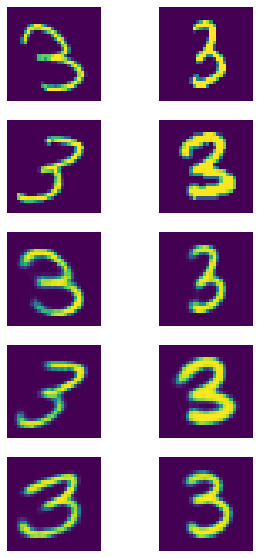

Epoch 23/50 Batch 0000/624, Loss  102.2615


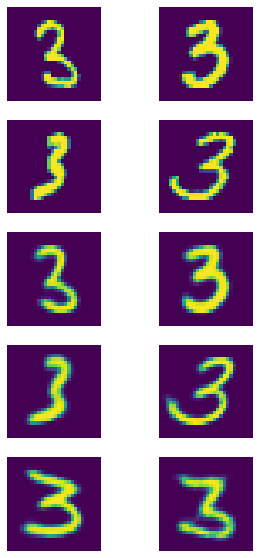

Epoch 24/50 Batch 0000/624, Loss  106.1746


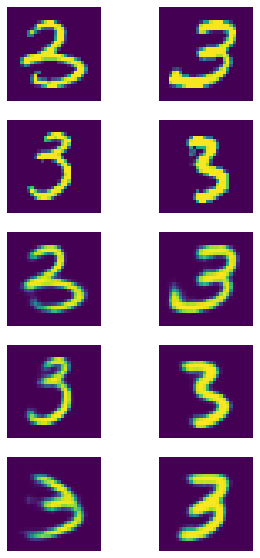

Epoch 25/50 Batch 0000/624, Loss  104.5015


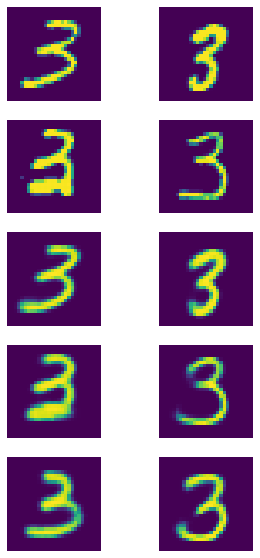

Epoch 26/50 Batch 0000/624, Loss  102.3915


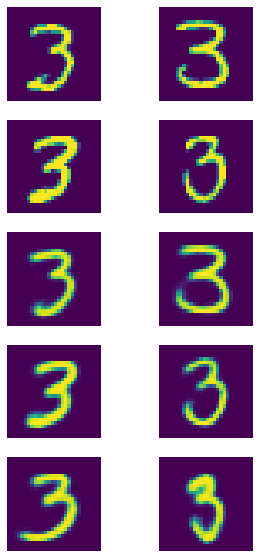

Epoch 27/50 Batch 0000/624, Loss   95.0141


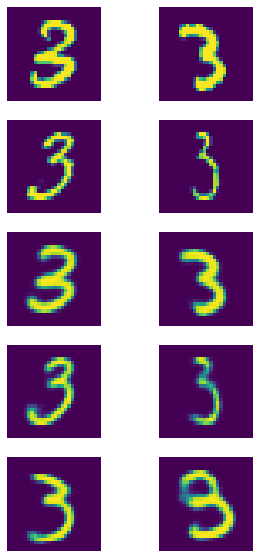

Epoch 28/50 Batch 0000/624, Loss  101.5929


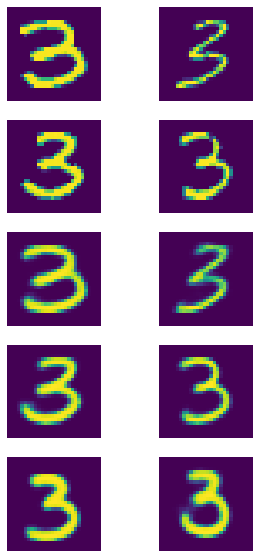

Epoch 29/50 Batch 0000/624, Loss  108.3038


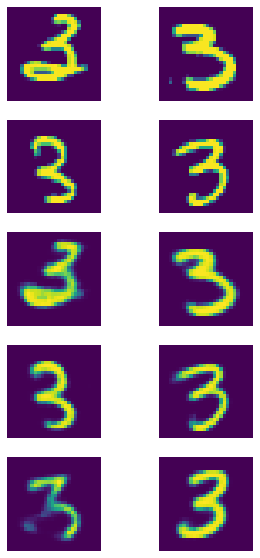

Epoch 30/50 Batch 0000/624, Loss   98.1061


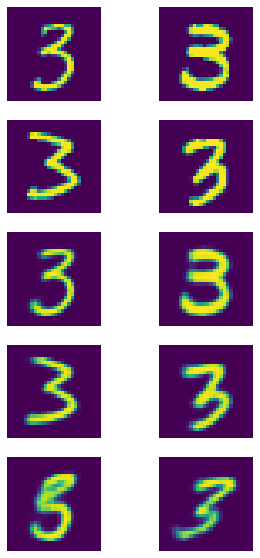

Epoch 31/50 Batch 0000/624, Loss   98.6077


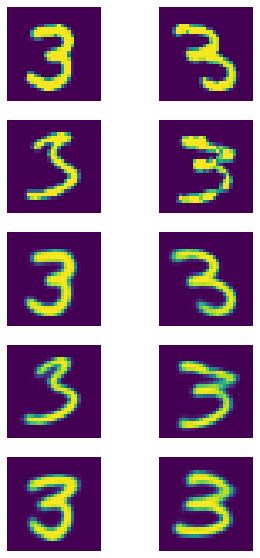

Epoch 32/50 Batch 0000/624, Loss   98.3977


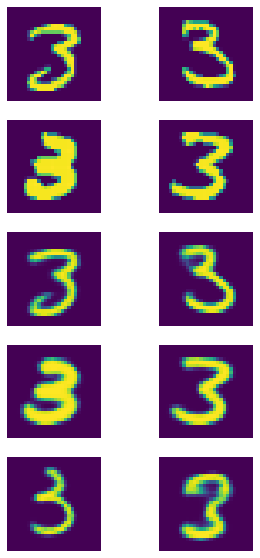

Epoch 33/50 Batch 0000/624, Loss  103.3980


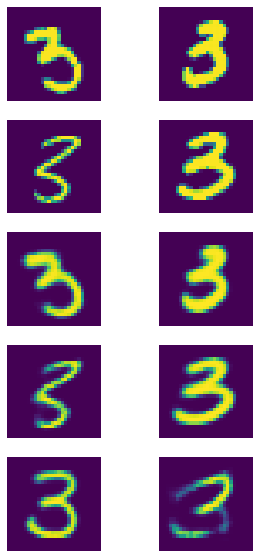

Epoch 34/50 Batch 0000/624, Loss   98.1212


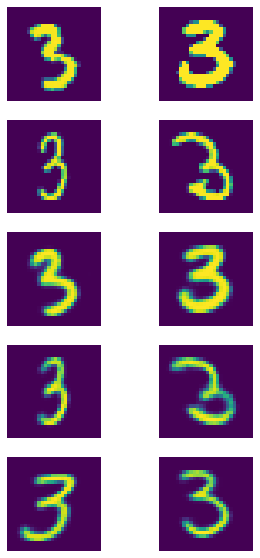

Epoch 35/50 Batch 0000/624, Loss  105.9208


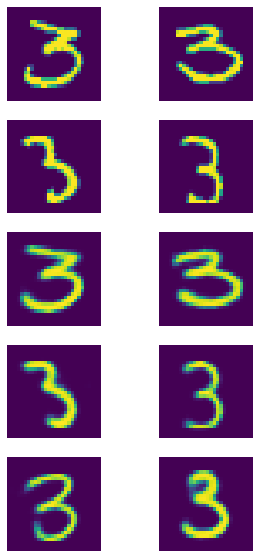

Epoch 36/50 Batch 0000/624, Loss  101.3303


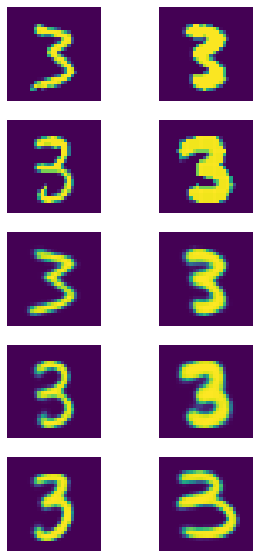

Epoch 37/50 Batch 0000/624, Loss  102.9426


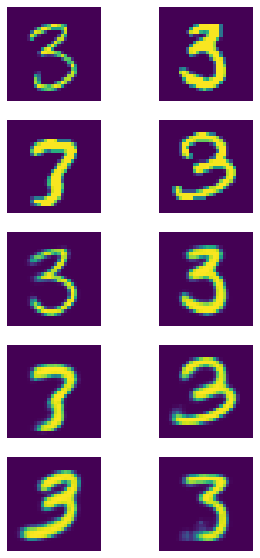

Epoch 38/50 Batch 0000/624, Loss  105.4706


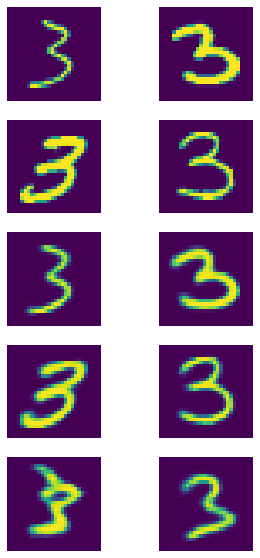

Epoch 39/50 Batch 0000/624, Loss  107.5278


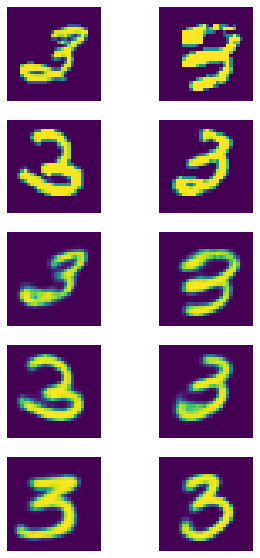

Epoch 40/50 Batch 0000/624, Loss   99.3846


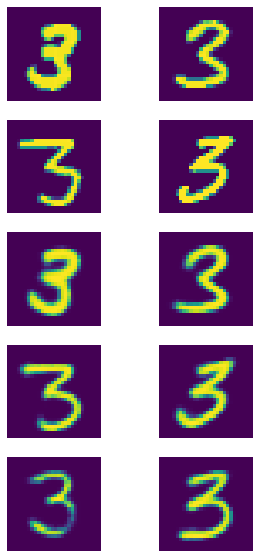

Epoch 41/50 Batch 0000/624, Loss   98.6259


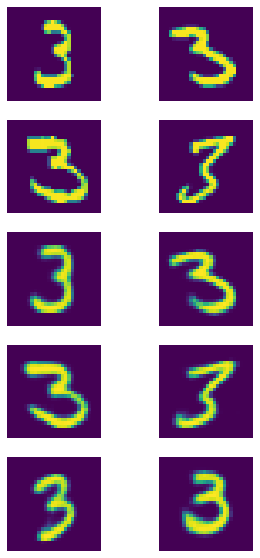

Epoch 42/50 Batch 0000/624, Loss  106.1083


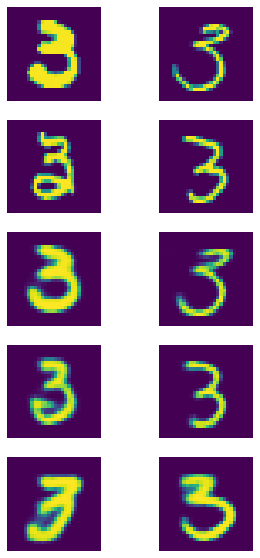

Epoch 43/50 Batch 0000/624, Loss  102.2768


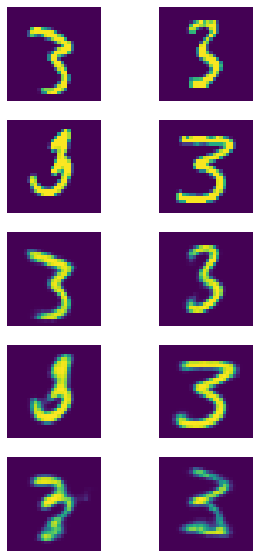

Epoch 44/50 Batch 0000/624, Loss   99.1878


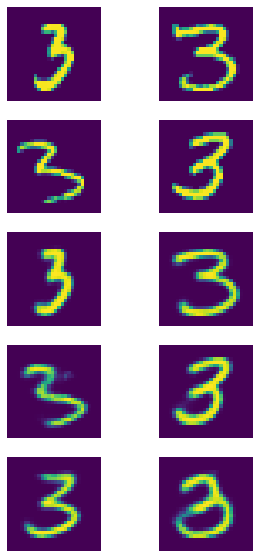

Epoch 45/50 Batch 0000/624, Loss   99.6677


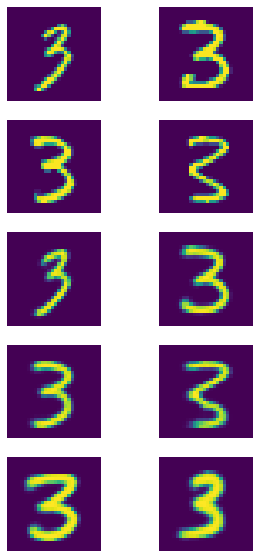

Epoch 46/50 Batch 0000/624, Loss  100.6462


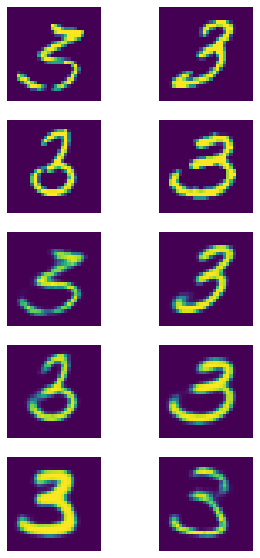

Epoch 47/50 Batch 0000/624, Loss   97.9110


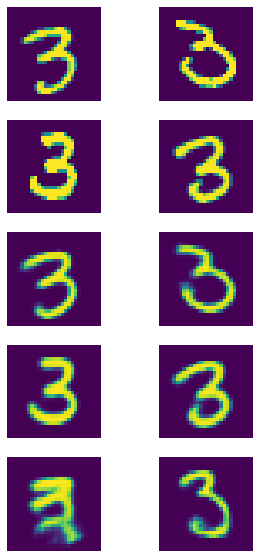

Epoch 48/50 Batch 0000/624, Loss   97.2527


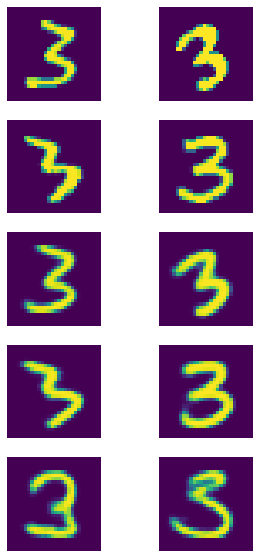

Epoch 49/50 Batch 0000/624, Loss  100.2696


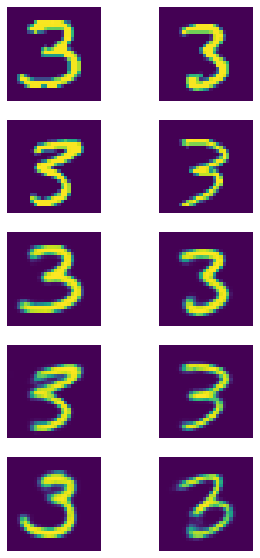

Epoch 00/50 Batch 0000/624, Loss  523.1286


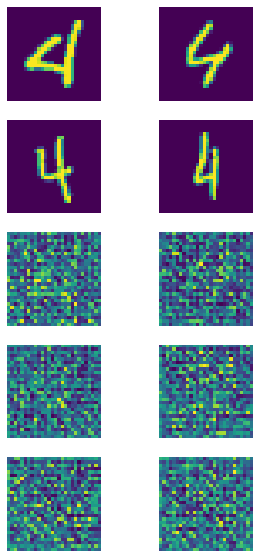

Epoch 01/50 Batch 0000/624, Loss  125.0549


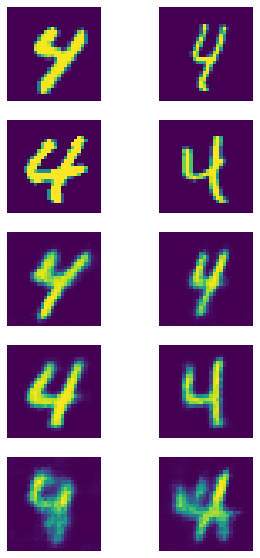

Epoch 02/50 Batch 0000/624, Loss  117.9638


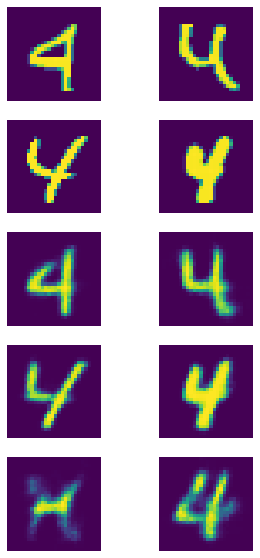

Epoch 03/50 Batch 0000/624, Loss  109.3255


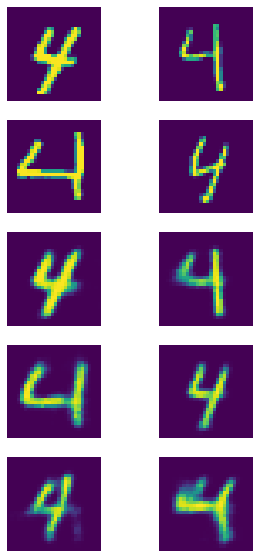

Epoch 04/50 Batch 0000/624, Loss  100.5186


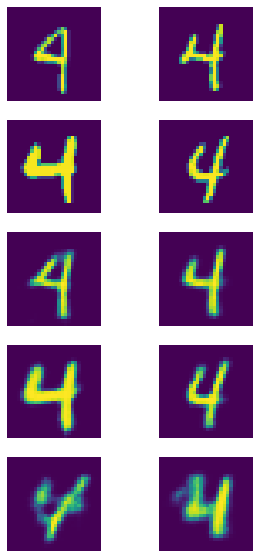

Epoch 05/50 Batch 0000/624, Loss   96.7617


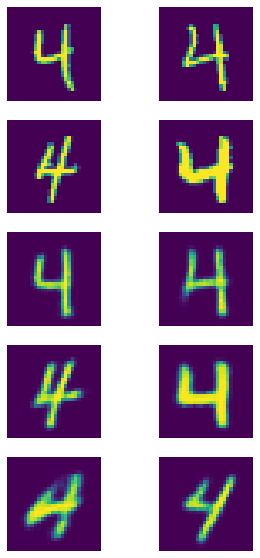

Epoch 06/50 Batch 0000/624, Loss   97.4299


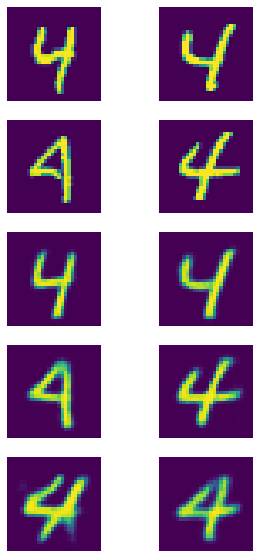

Epoch 07/50 Batch 0000/624, Loss   95.1823


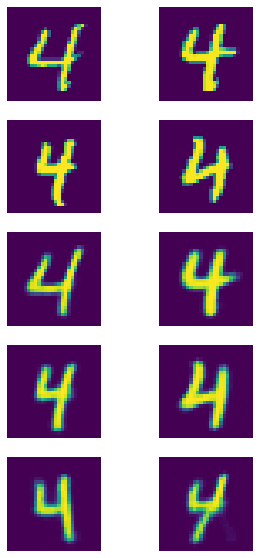

Epoch 08/50 Batch 0000/624, Loss   92.4129


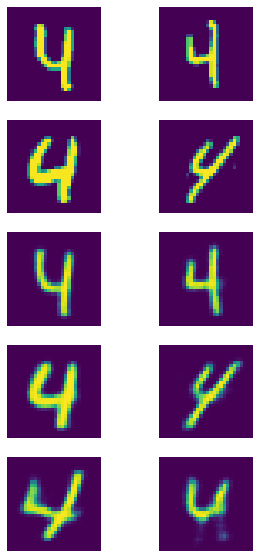

Epoch 09/50 Batch 0000/624, Loss   97.0352


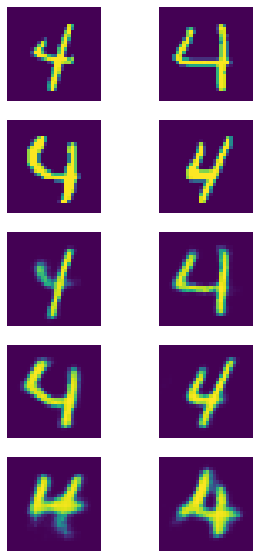

Epoch 10/50 Batch 0000/624, Loss   99.7500


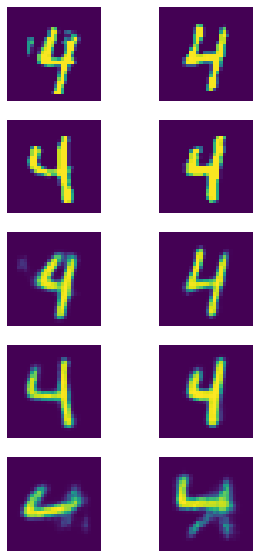

Epoch 11/50 Batch 0000/624, Loss   95.0791


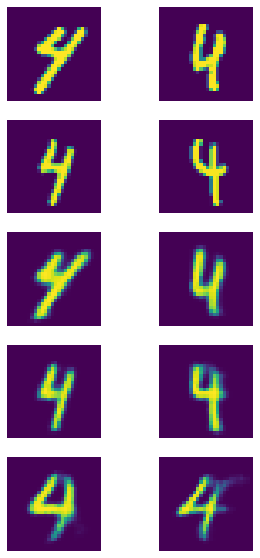

Epoch 12/50 Batch 0000/624, Loss   95.4431


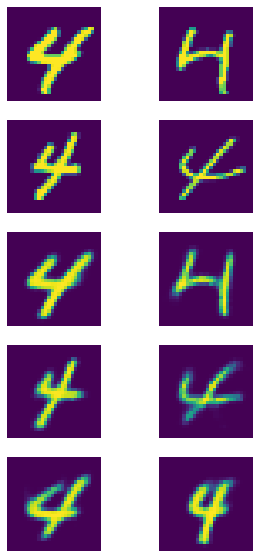

Epoch 13/50 Batch 0000/624, Loss   94.0209


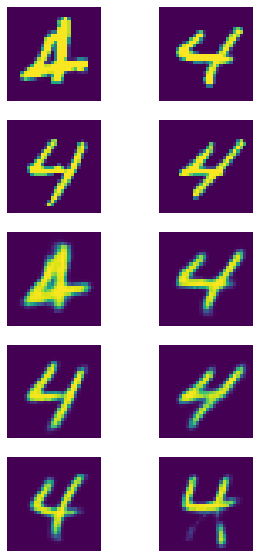

Epoch 14/50 Batch 0000/624, Loss   92.4920


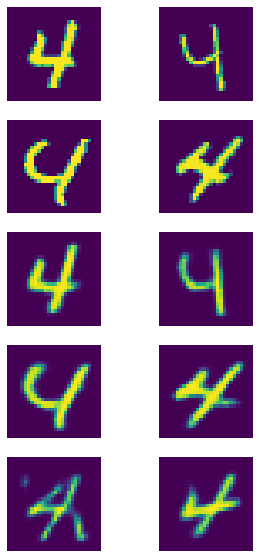

Epoch 15/50 Batch 0000/624, Loss   90.7129


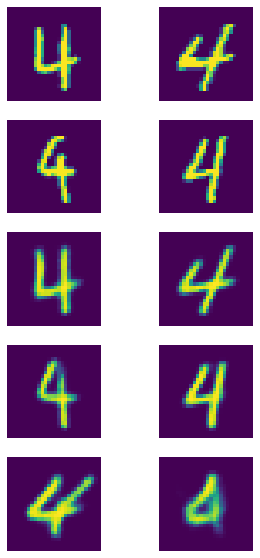

Epoch 16/50 Batch 0000/624, Loss   97.3316


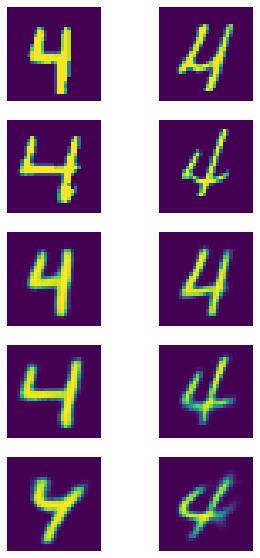

Epoch 17/50 Batch 0000/624, Loss   93.6546


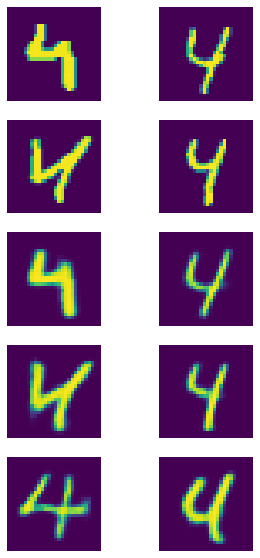

Epoch 18/50 Batch 0000/624, Loss   95.6535


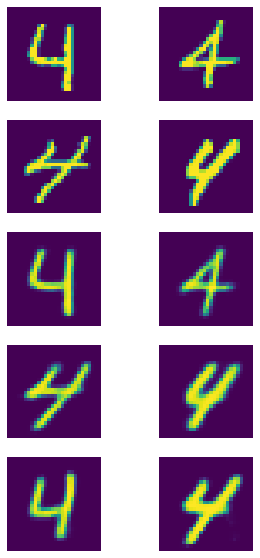

Epoch 19/50 Batch 0000/624, Loss   94.6684


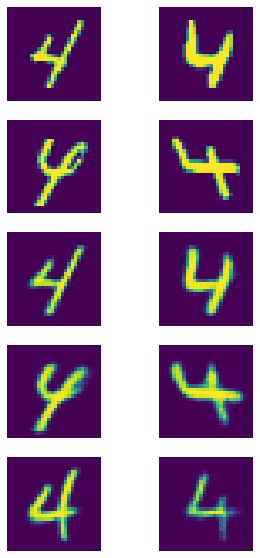

Epoch 20/50 Batch 0000/624, Loss   96.6830


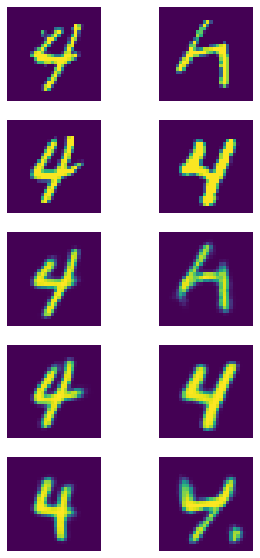

Epoch 21/50 Batch 0000/624, Loss   93.5666


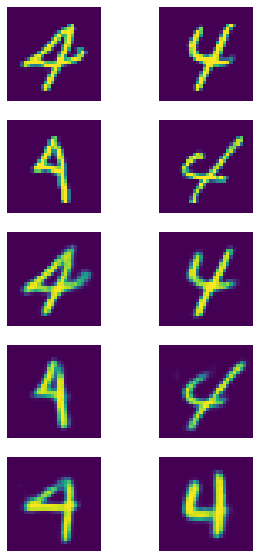

Epoch 22/50 Batch 0000/624, Loss   90.2808


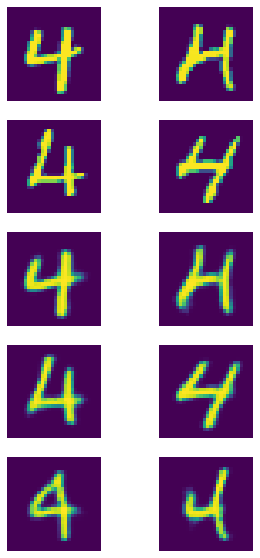

Epoch 23/50 Batch 0000/624, Loss   94.0292


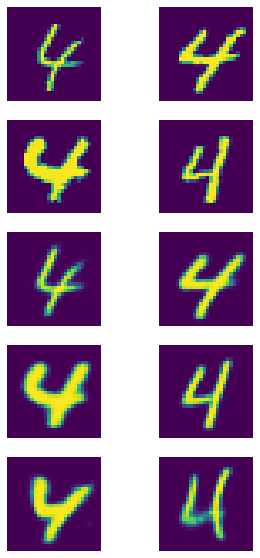

Epoch 24/50 Batch 0000/624, Loss   94.1773


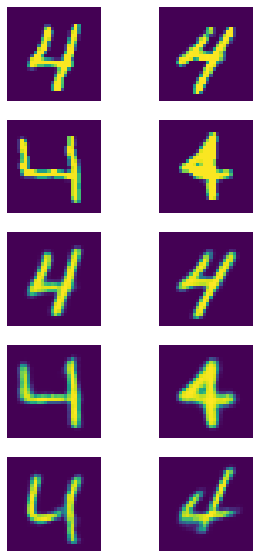

Epoch 25/50 Batch 0000/624, Loss   91.8086


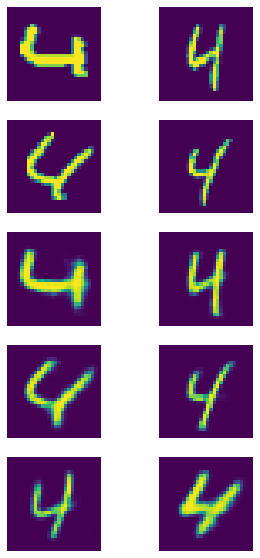

Epoch 26/50 Batch 0000/624, Loss   91.4543


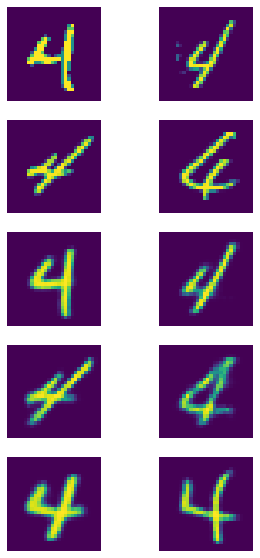

Epoch 27/50 Batch 0000/624, Loss   87.5984


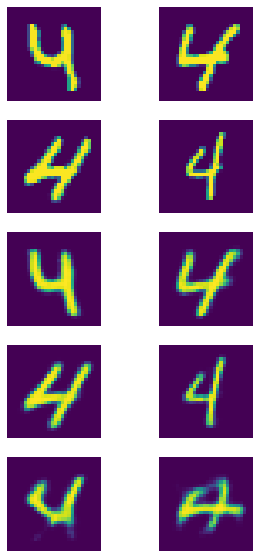

Epoch 28/50 Batch 0000/624, Loss   91.3403


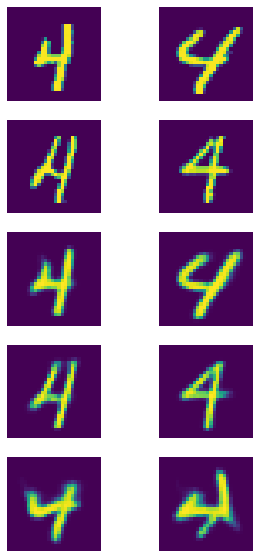

Epoch 29/50 Batch 0000/624, Loss   86.7393


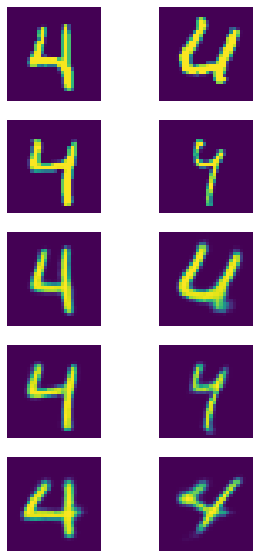

Epoch 30/50 Batch 0000/624, Loss   95.7246


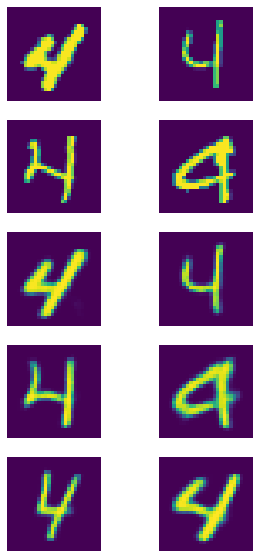

Epoch 31/50 Batch 0000/624, Loss   90.5610


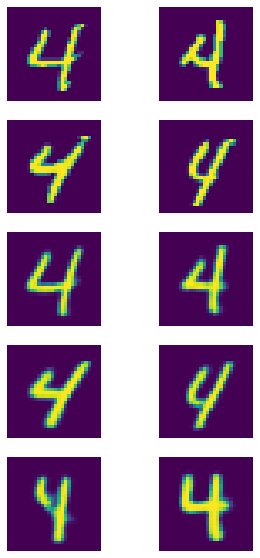

Epoch 32/50 Batch 0000/624, Loss   95.0725


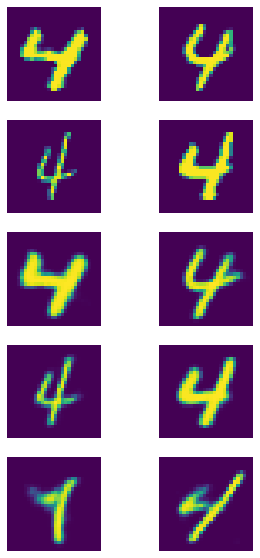

Epoch 33/50 Batch 0000/624, Loss   91.0756


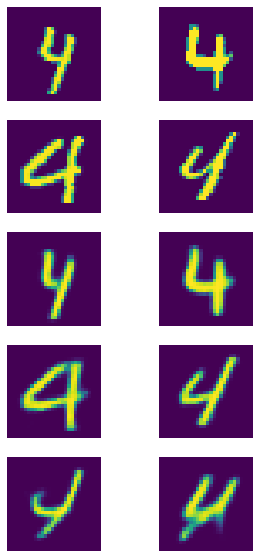

Epoch 34/50 Batch 0000/624, Loss   84.3692


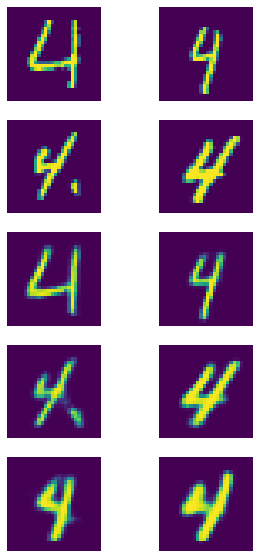

Epoch 35/50 Batch 0000/624, Loss   86.6775


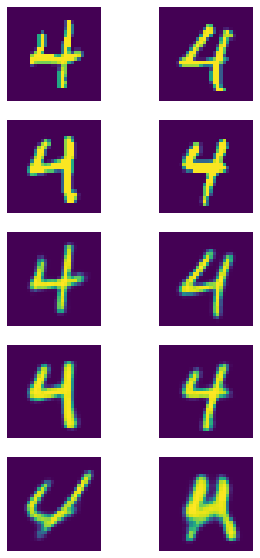

Epoch 36/50 Batch 0000/624, Loss   86.7977


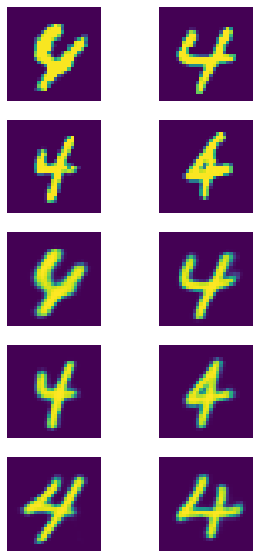

Epoch 37/50 Batch 0000/624, Loss   95.1852


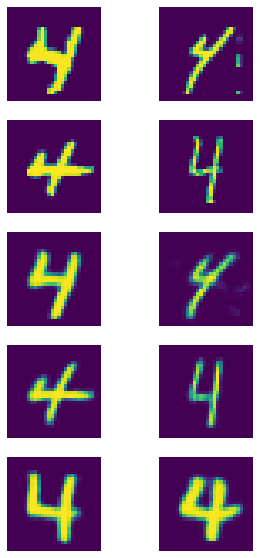

Epoch 38/50 Batch 0000/624, Loss   92.4582


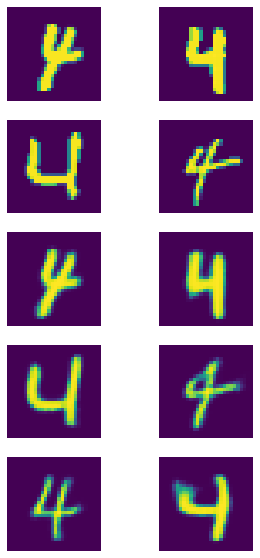

Epoch 39/50 Batch 0000/624, Loss   92.5432


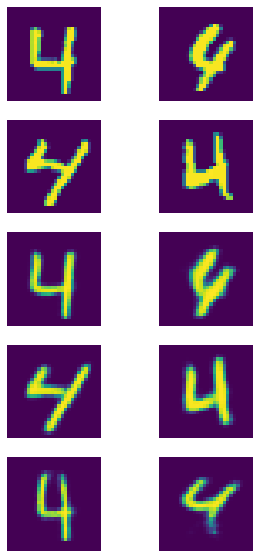

Epoch 40/50 Batch 0000/624, Loss   92.6426


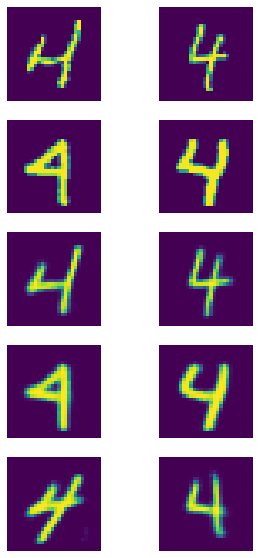

Epoch 41/50 Batch 0000/624, Loss   89.8674


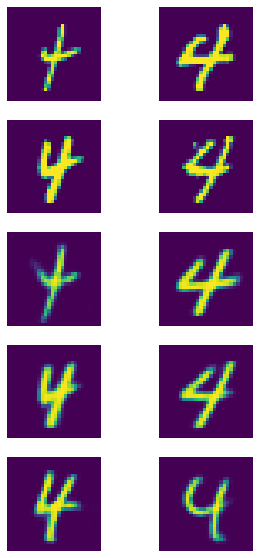

Epoch 42/50 Batch 0000/624, Loss   90.0280


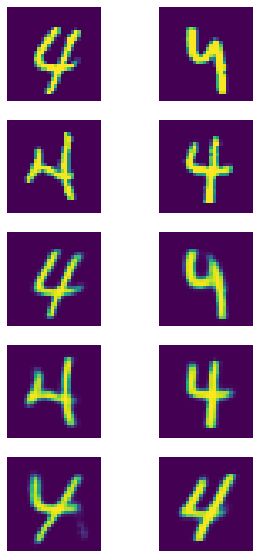

Epoch 43/50 Batch 0000/624, Loss   87.6968


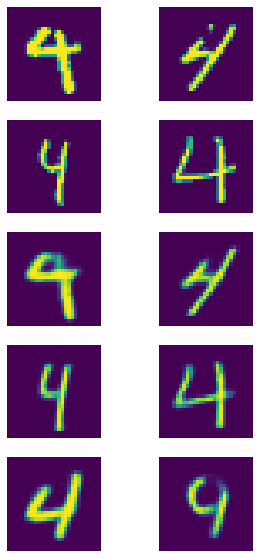

Epoch 44/50 Batch 0000/624, Loss   87.0804


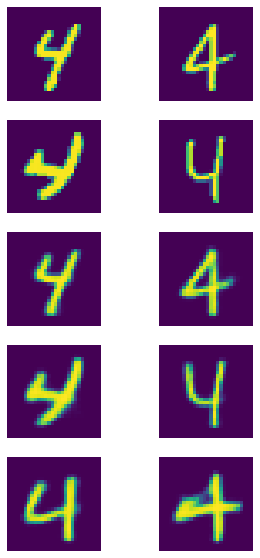

Epoch 45/50 Batch 0000/624, Loss   88.2906


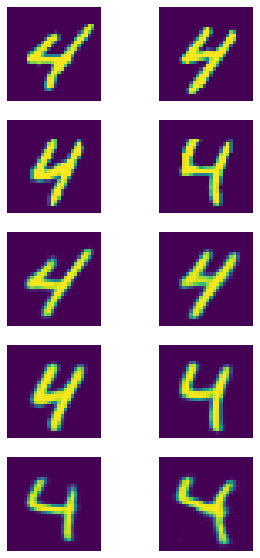

Epoch 46/50 Batch 0000/624, Loss   90.2613


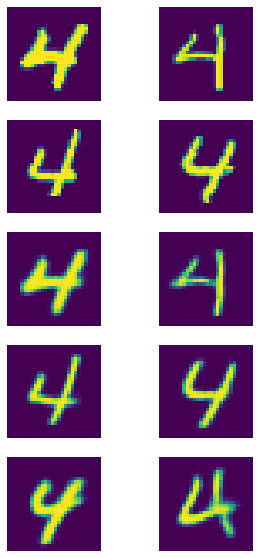

Epoch 47/50 Batch 0000/624, Loss   95.5197


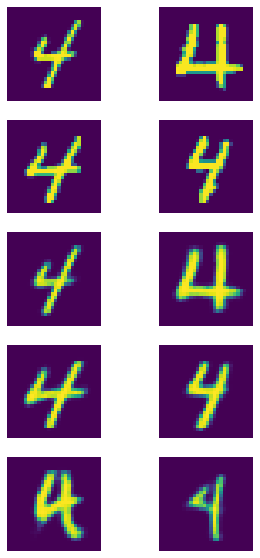

Epoch 48/50 Batch 0000/624, Loss   96.2123


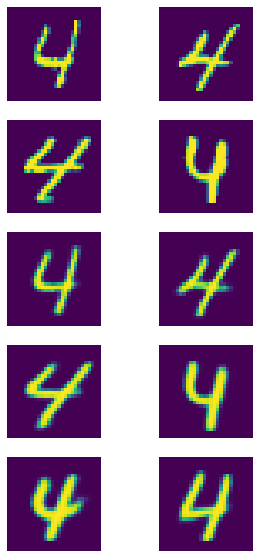

Epoch 49/50 Batch 0000/624, Loss   90.1043


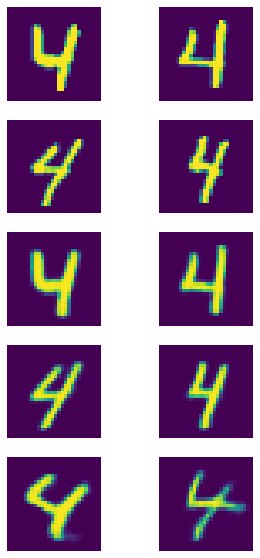

Epoch 00/50 Batch 0000/624, Loss  620.4384


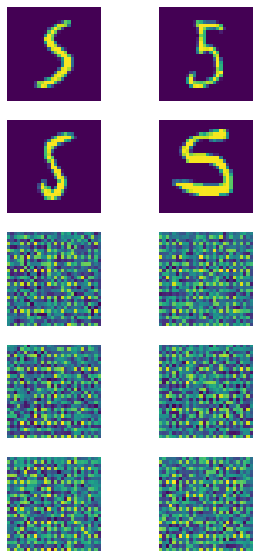

Epoch 01/50 Batch 0000/624, Loss  132.0162


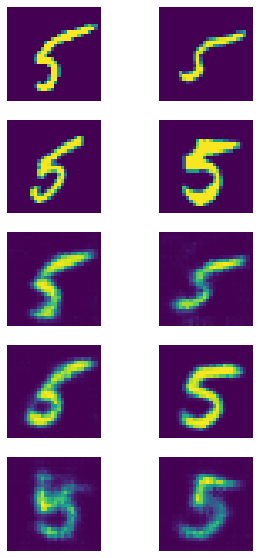

Epoch 02/50 Batch 0000/624, Loss  130.8560


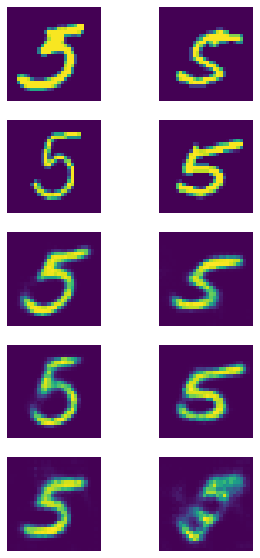

Epoch 03/50 Batch 0000/624, Loss  125.5722


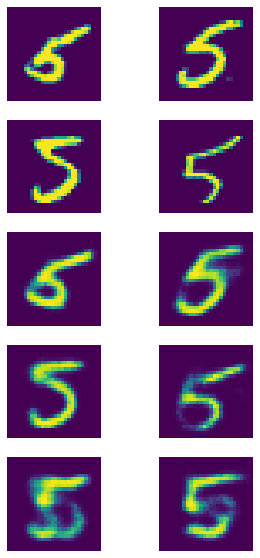

Epoch 04/50 Batch 0000/624, Loss  115.1008


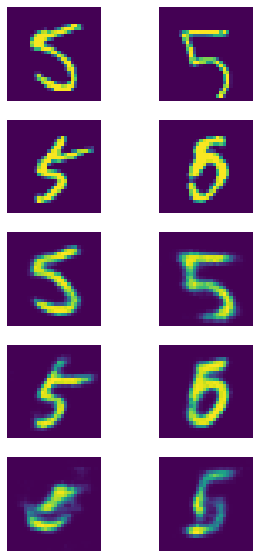

Epoch 05/50 Batch 0000/624, Loss  111.0278


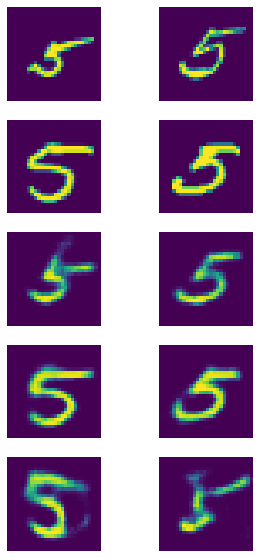

Epoch 06/50 Batch 0000/624, Loss  112.4439


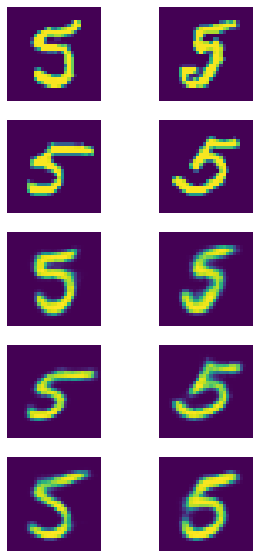

Epoch 07/50 Batch 0000/624, Loss  115.9496


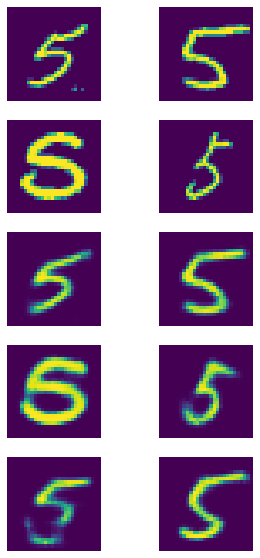

Epoch 08/50 Batch 0000/624, Loss  109.4637


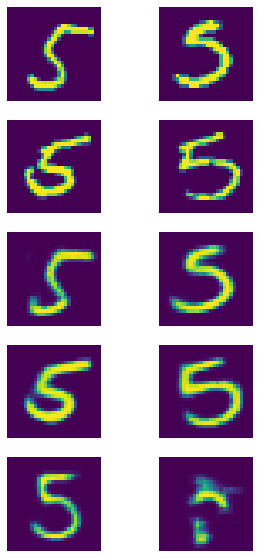

Epoch 09/50 Batch 0000/624, Loss   98.2237


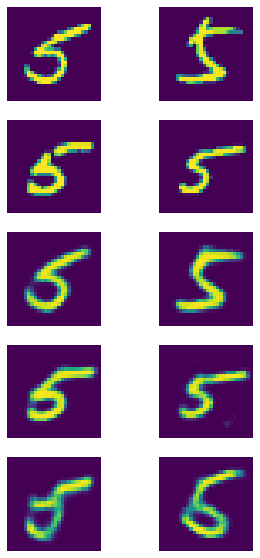

Epoch 10/50 Batch 0000/624, Loss  113.6122


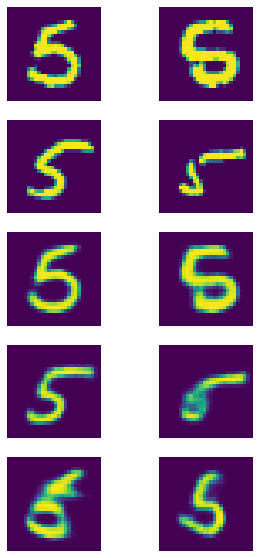

Epoch 11/50 Batch 0000/624, Loss  109.3782


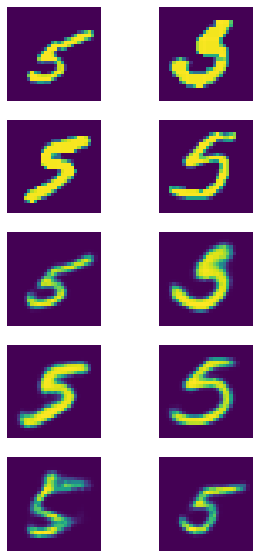

Epoch 12/50 Batch 0000/624, Loss  111.1033


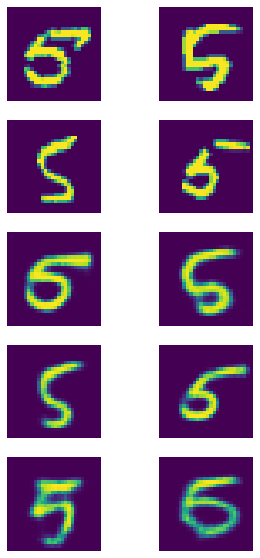

Epoch 13/50 Batch 0000/624, Loss  105.3227


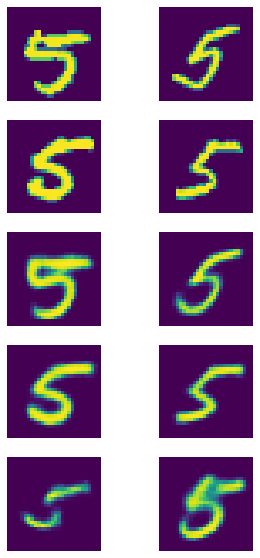

Epoch 14/50 Batch 0000/624, Loss  103.0989


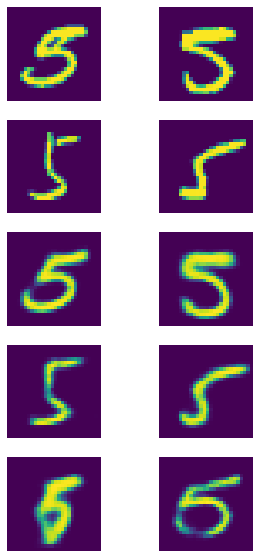

Epoch 15/50 Batch 0000/624, Loss  102.4867


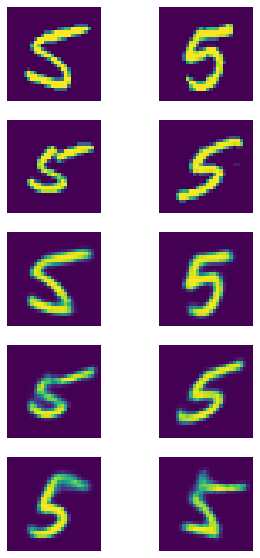

Epoch 16/50 Batch 0000/624, Loss  105.5593


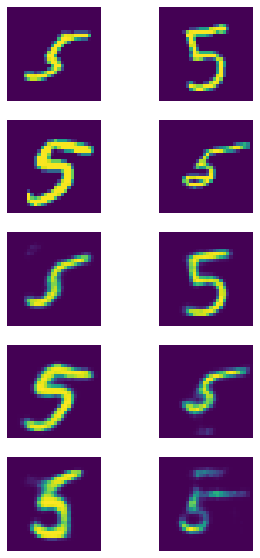

Epoch 17/50 Batch 0000/624, Loss  103.7118


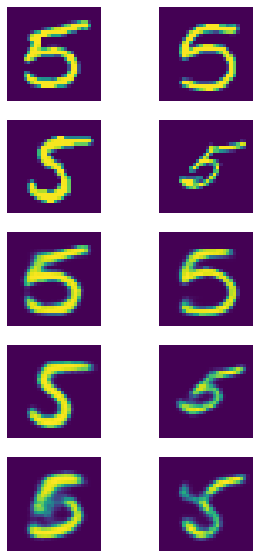

Epoch 18/50 Batch 0000/624, Loss  117.0198


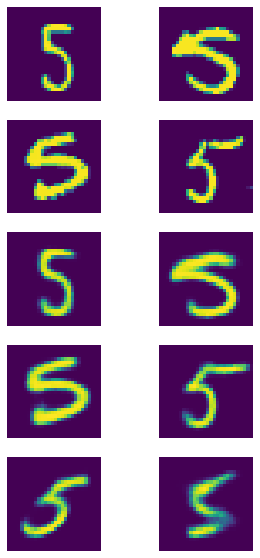

Epoch 19/50 Batch 0000/624, Loss  108.9097


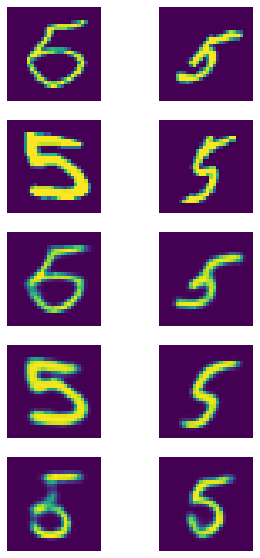

Epoch 20/50 Batch 0000/624, Loss  100.1576


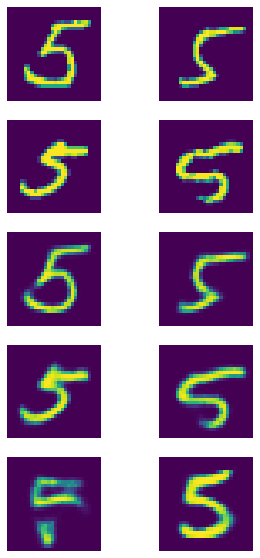

Epoch 21/50 Batch 0000/624, Loss  107.8350


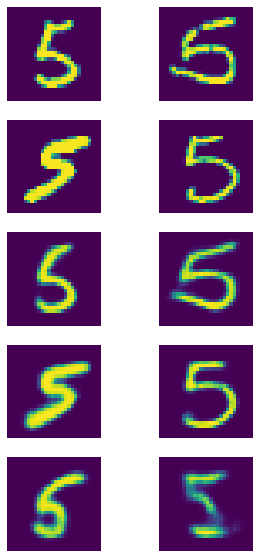

Epoch 22/50 Batch 0000/624, Loss  106.2410


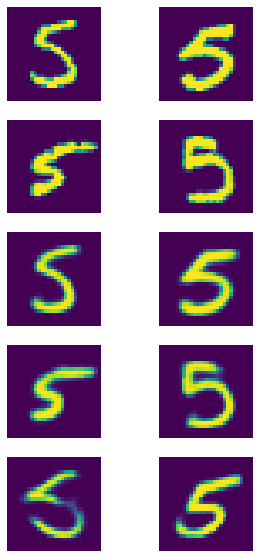

Epoch 23/50 Batch 0000/624, Loss  102.3617


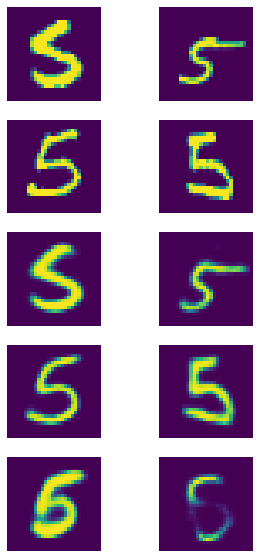

Epoch 24/50 Batch 0000/624, Loss   99.2542


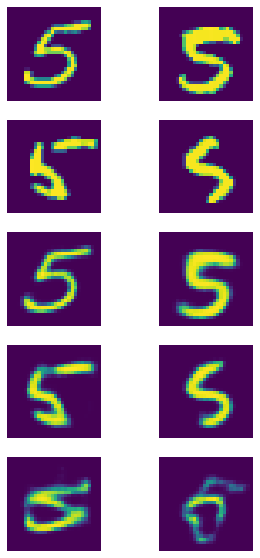

Epoch 25/50 Batch 0000/624, Loss  105.5958


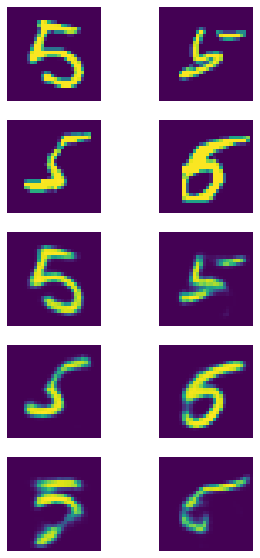

Epoch 26/50 Batch 0000/624, Loss   97.6201


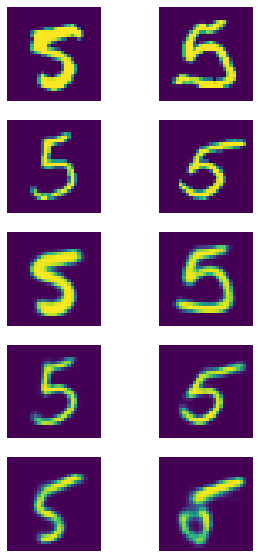

Epoch 27/50 Batch 0000/624, Loss   97.8160


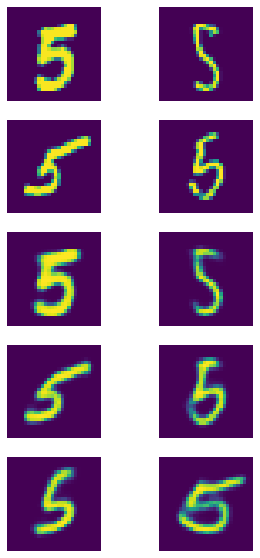

Epoch 28/50 Batch 0000/624, Loss  106.5824


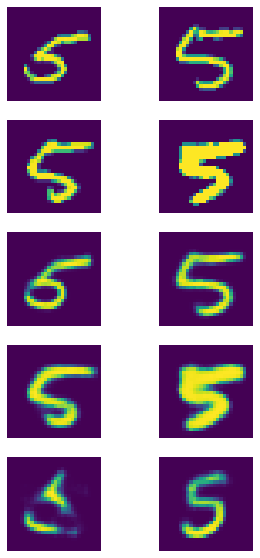

Epoch 29/50 Batch 0000/624, Loss  103.5758


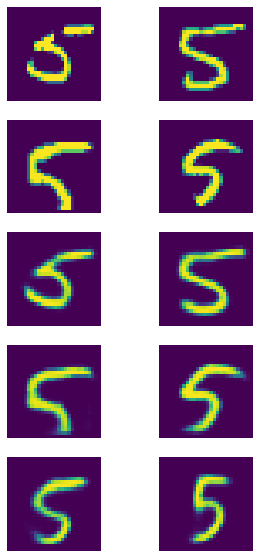

Epoch 30/50 Batch 0000/624, Loss  107.8509


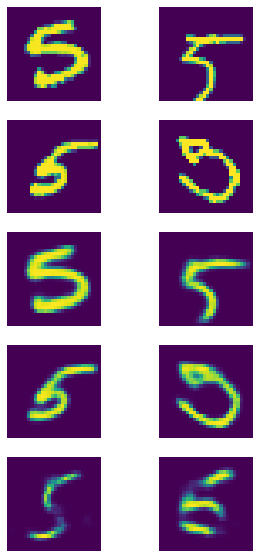

Epoch 31/50 Batch 0000/624, Loss   99.9288


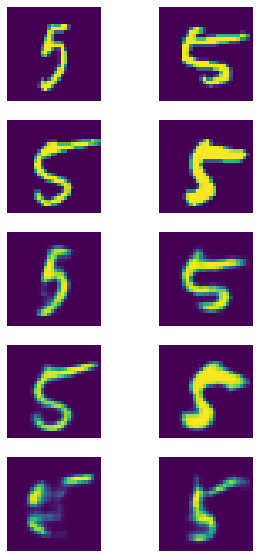

Epoch 32/50 Batch 0000/624, Loss  103.1629


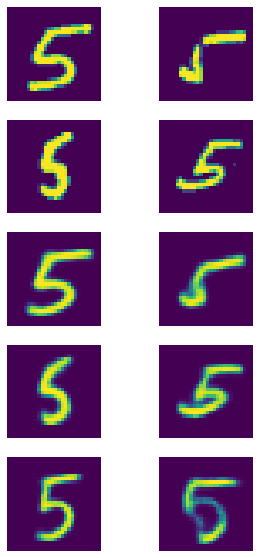

Epoch 33/50 Batch 0000/624, Loss  109.1938


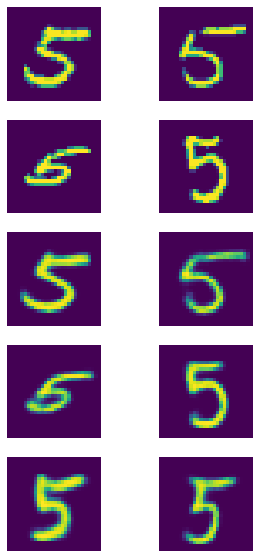

Epoch 34/50 Batch 0000/624, Loss   99.7361


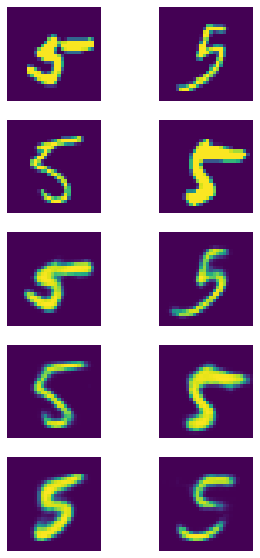

Epoch 35/50 Batch 0000/624, Loss  105.0960


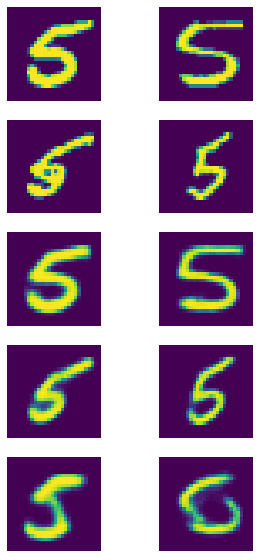

Epoch 36/50 Batch 0000/624, Loss  101.2738


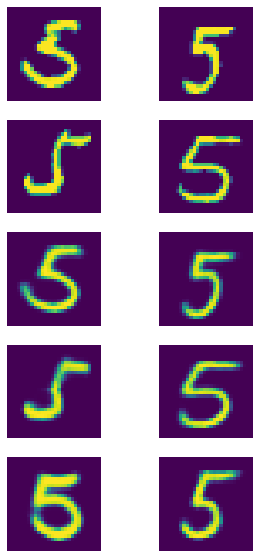

Epoch 37/50 Batch 0000/624, Loss  101.4583


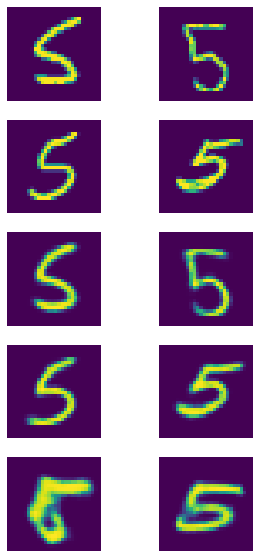

Epoch 38/50 Batch 0000/624, Loss  100.5693


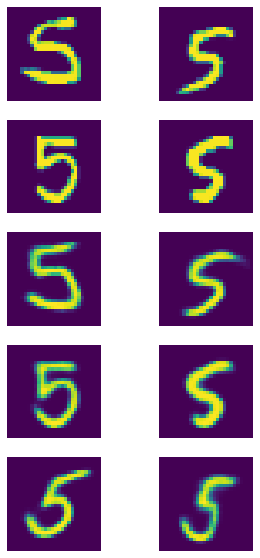

Epoch 39/50 Batch 0000/624, Loss  101.7430


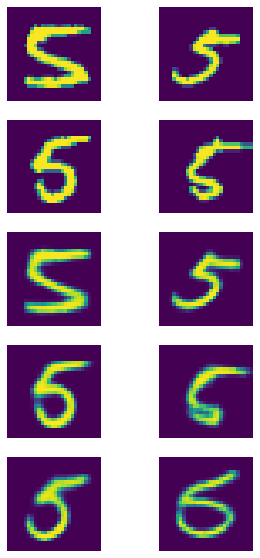

Epoch 40/50 Batch 0000/624, Loss  100.7793


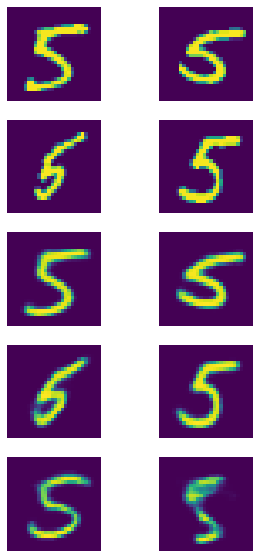

Epoch 41/50 Batch 0000/624, Loss   96.7357


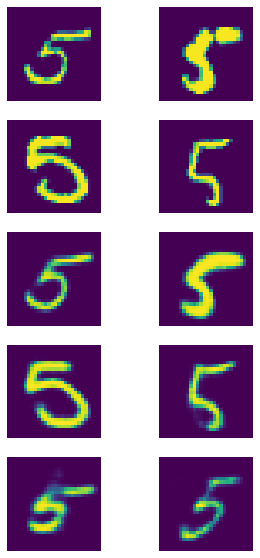

Epoch 42/50 Batch 0000/624, Loss  101.5698


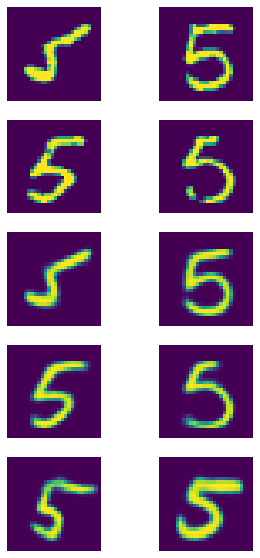

Epoch 43/50 Batch 0000/624, Loss  102.2045


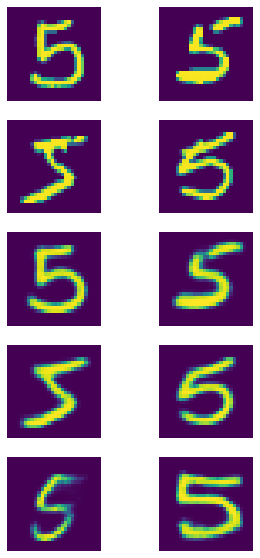

Epoch 44/50 Batch 0000/624, Loss   99.0569


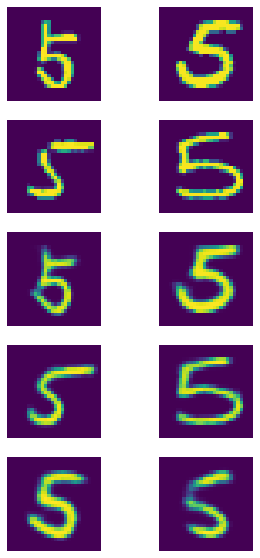

Epoch 45/50 Batch 0000/624, Loss   97.0683


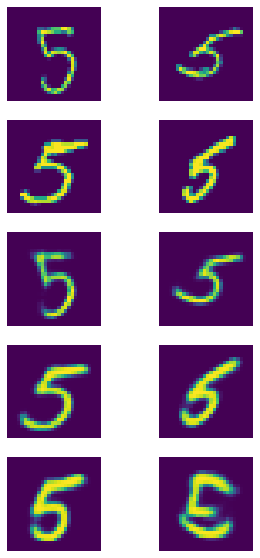

Epoch 46/50 Batch 0000/624, Loss  102.5383


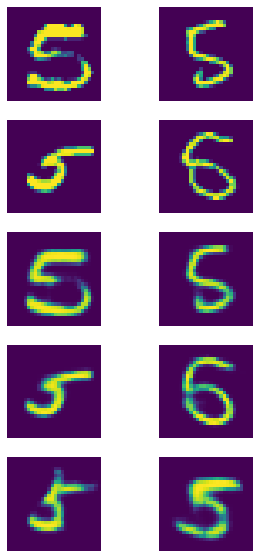

Epoch 47/50 Batch 0000/624, Loss  101.6526


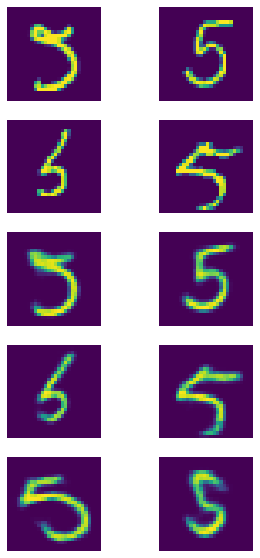

Epoch 48/50 Batch 0000/624, Loss  101.1777


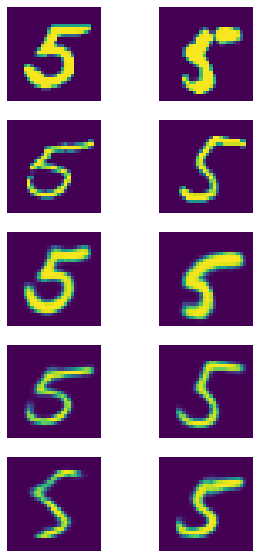

Epoch 49/50 Batch 0000/624, Loss   97.9262


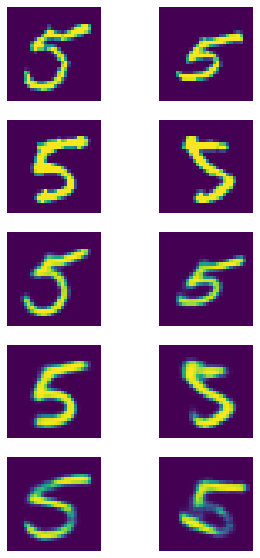

Epoch 00/50 Batch 0000/624, Loss  545.8820


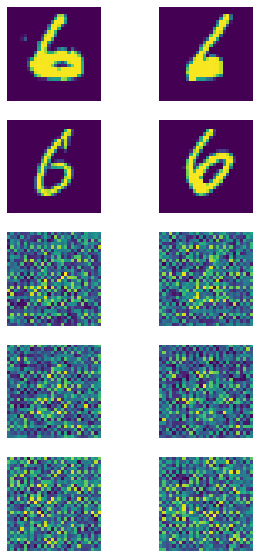

Epoch 01/50 Batch 0000/624, Loss  119.8386


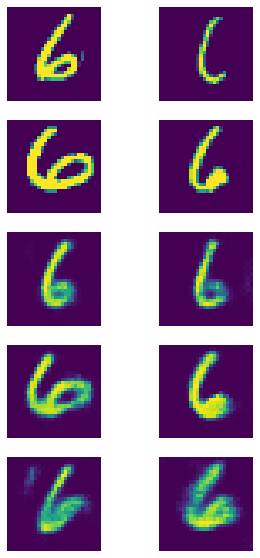

Epoch 02/50 Batch 0000/624, Loss  104.0059


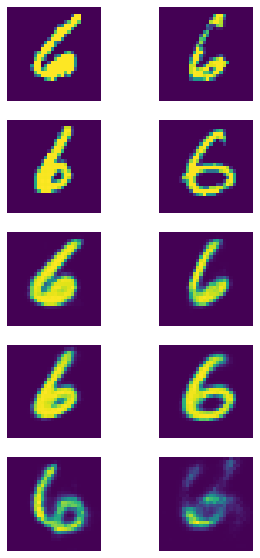

Epoch 03/50 Batch 0000/624, Loss   99.0002


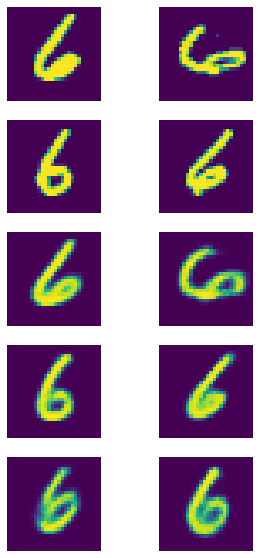

Epoch 04/50 Batch 0000/624, Loss  103.8581


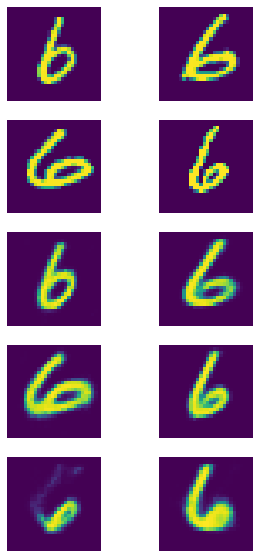

Epoch 05/50 Batch 0000/624, Loss   97.5291


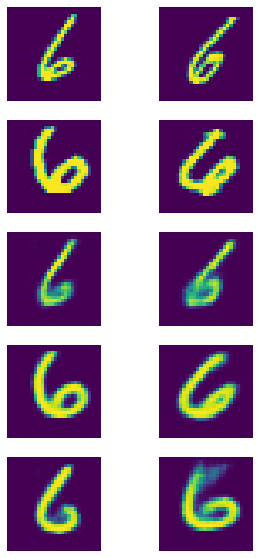

Epoch 06/50 Batch 0000/624, Loss   92.0180


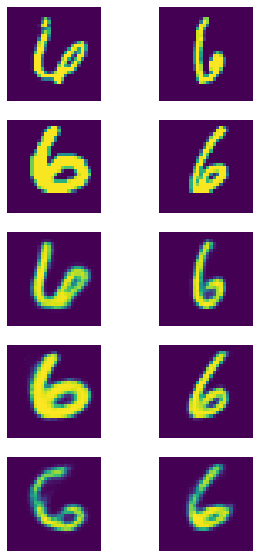

Epoch 07/50 Batch 0000/624, Loss   97.3102


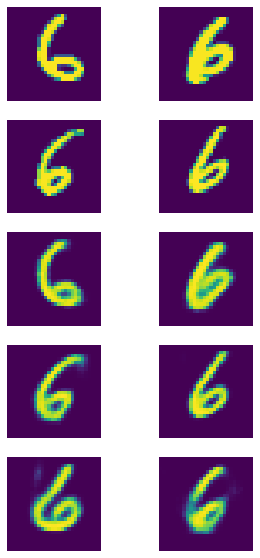

Epoch 08/50 Batch 0000/624, Loss   94.6447


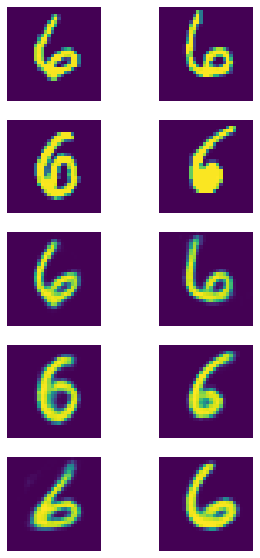

Epoch 09/50 Batch 0000/624, Loss  102.6032


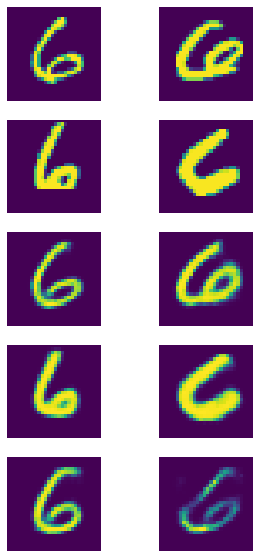

Epoch 10/50 Batch 0000/624, Loss  101.1986


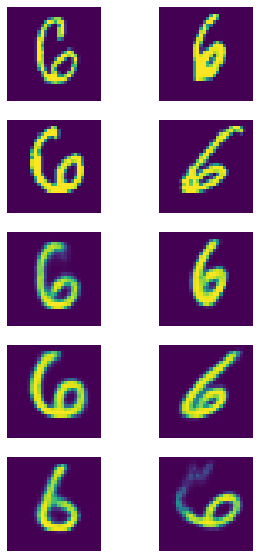

Epoch 11/50 Batch 0000/624, Loss   96.1422


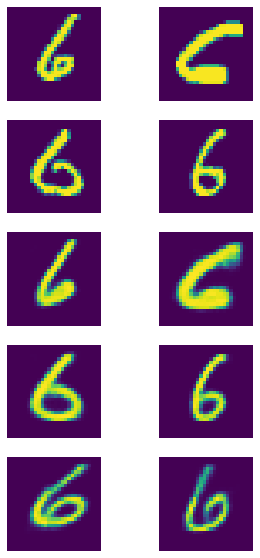

Epoch 12/50 Batch 0000/624, Loss   95.0553


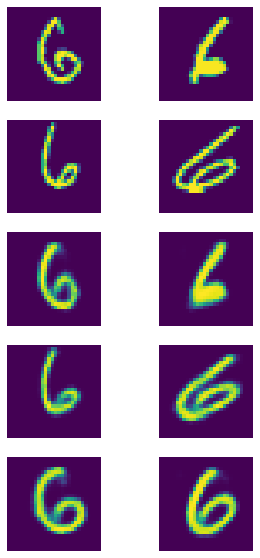

Epoch 13/50 Batch 0000/624, Loss   93.8032


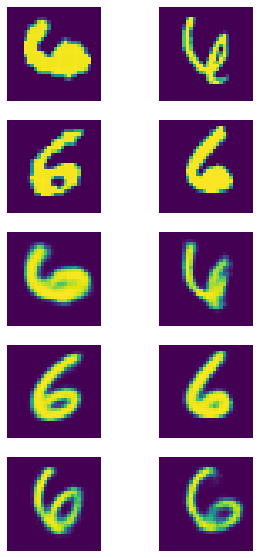

Epoch 14/50 Batch 0000/624, Loss   92.8112


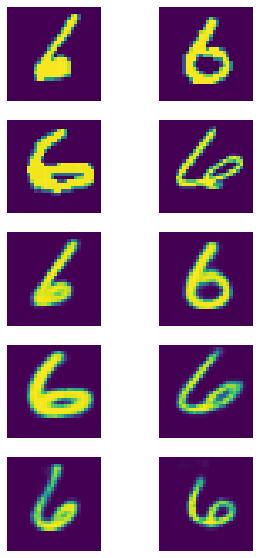

Epoch 15/50 Batch 0000/624, Loss   96.0286


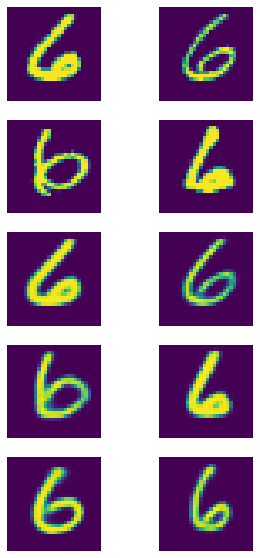

Epoch 16/50 Batch 0000/624, Loss   92.3829


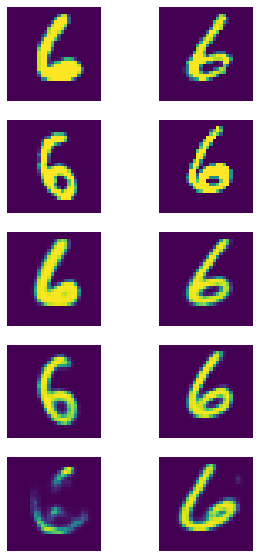

Epoch 17/50 Batch 0000/624, Loss   93.7769


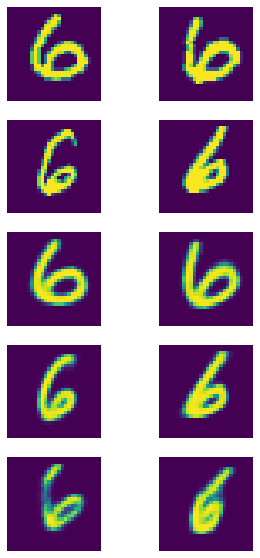

Epoch 18/50 Batch 0000/624, Loss   94.6964


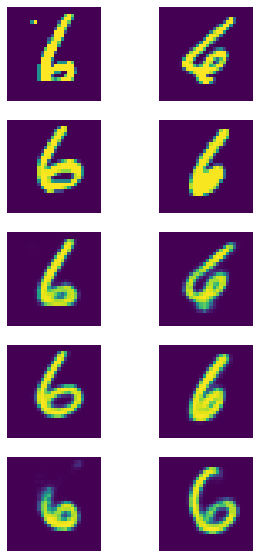

Epoch 19/50 Batch 0000/624, Loss   92.5172


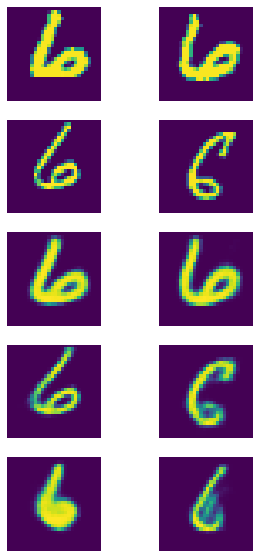

Epoch 20/50 Batch 0000/624, Loss   95.3203


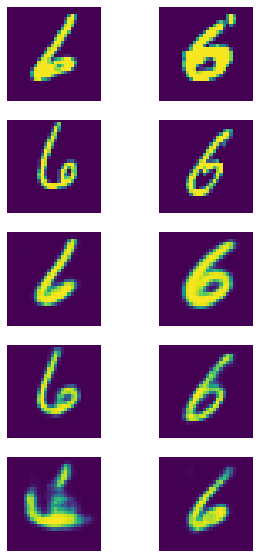

Epoch 21/50 Batch 0000/624, Loss   97.1817


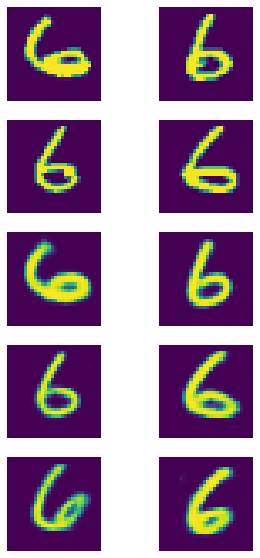

Epoch 22/50 Batch 0000/624, Loss   90.9356


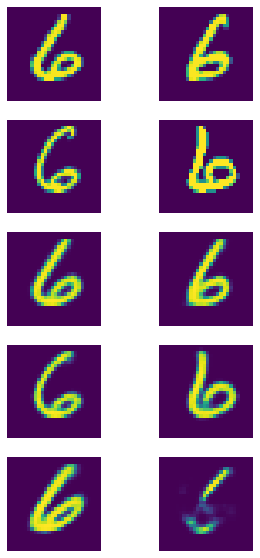

Epoch 23/50 Batch 0000/624, Loss   92.5666


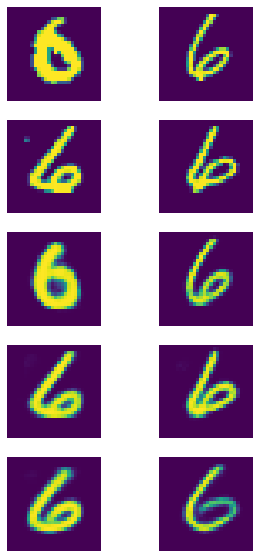

Epoch 24/50 Batch 0000/624, Loss   88.9725


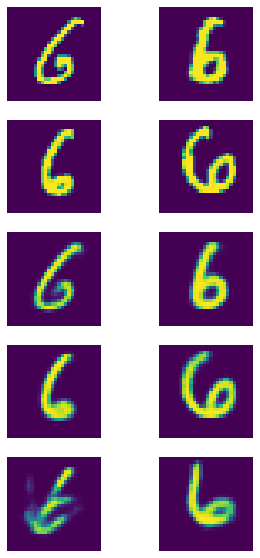

Epoch 25/50 Batch 0000/624, Loss   89.6983


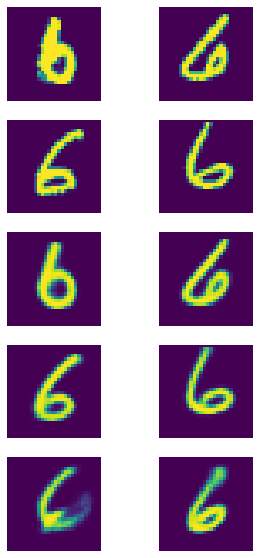

Epoch 26/50 Batch 0000/624, Loss   90.5518


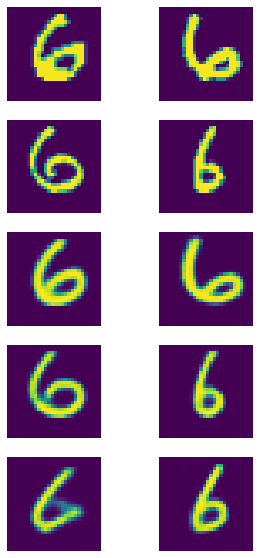

Epoch 27/50 Batch 0000/624, Loss   87.3488


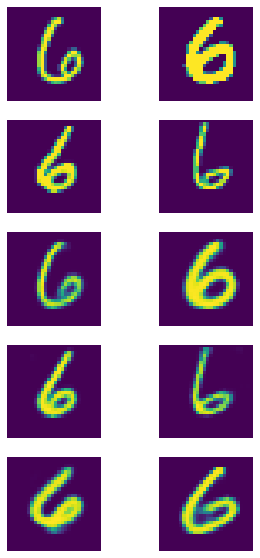

Epoch 28/50 Batch 0000/624, Loss   81.5792


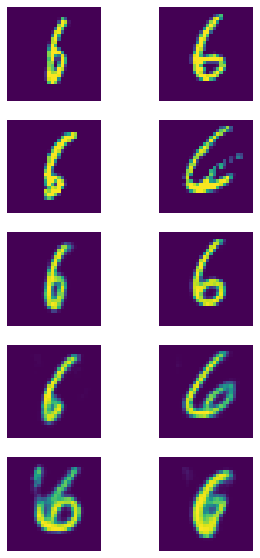

Epoch 29/50 Batch 0000/624, Loss   98.4671


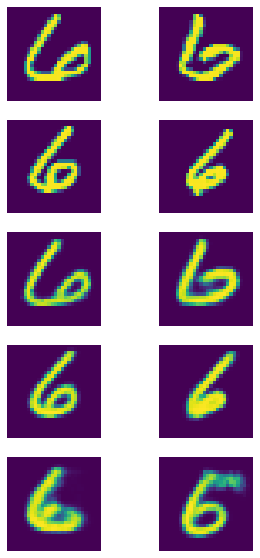

Epoch 30/50 Batch 0000/624, Loss   88.7647


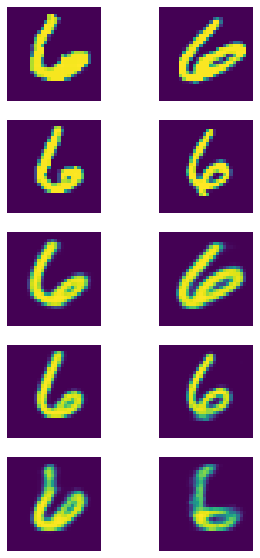

Epoch 31/50 Batch 0000/624, Loss   90.6528


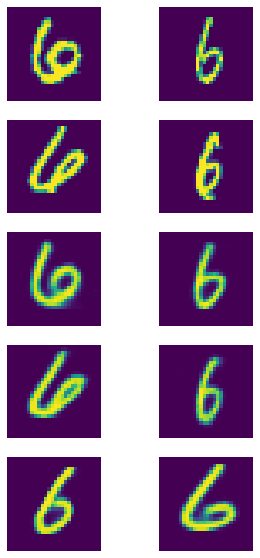

Epoch 32/50 Batch 0000/624, Loss   87.8427


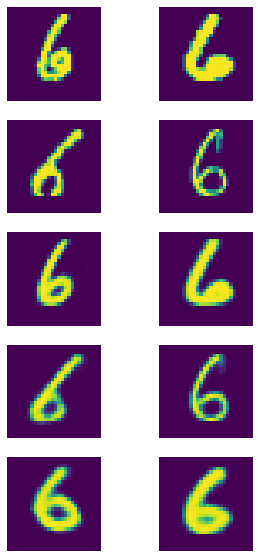

Epoch 33/50 Batch 0000/624, Loss   94.5757


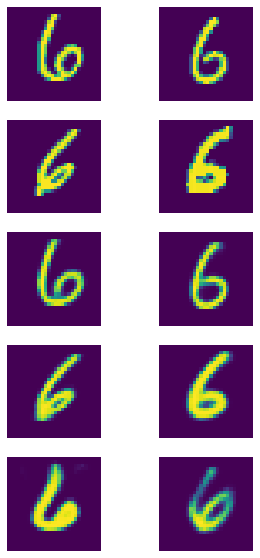

Epoch 34/50 Batch 0000/624, Loss   89.9497


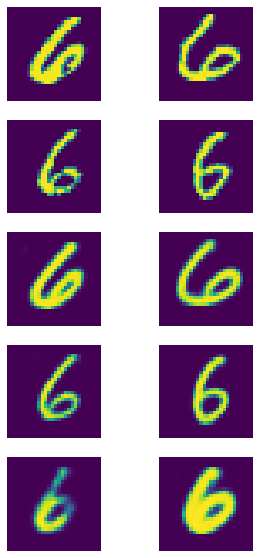

Epoch 35/50 Batch 0000/624, Loss   86.6565


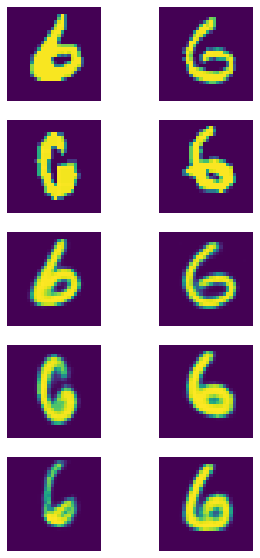

Epoch 36/50 Batch 0000/624, Loss   86.9660


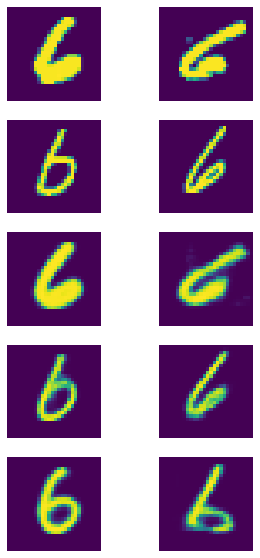

Epoch 37/50 Batch 0000/624, Loss   95.3135


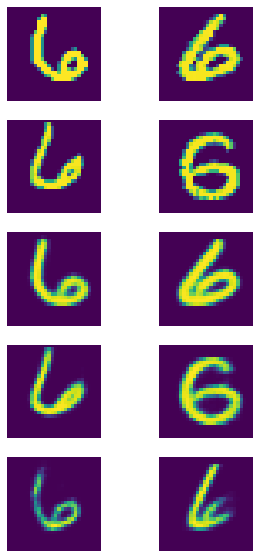

Epoch 38/50 Batch 0000/624, Loss   92.7361


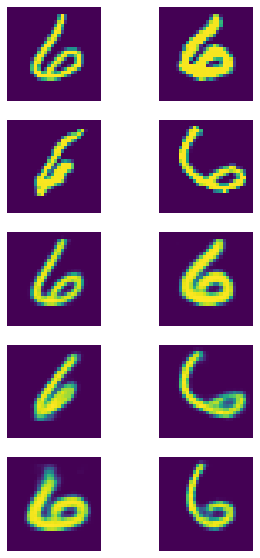

Epoch 39/50 Batch 0000/624, Loss   86.3478


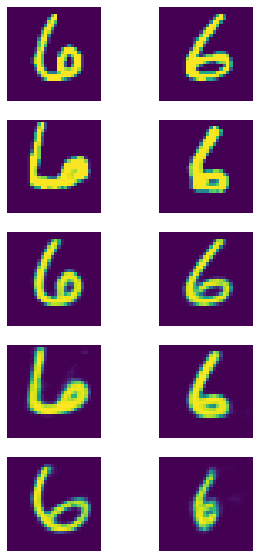

Epoch 40/50 Batch 0000/624, Loss   94.1252


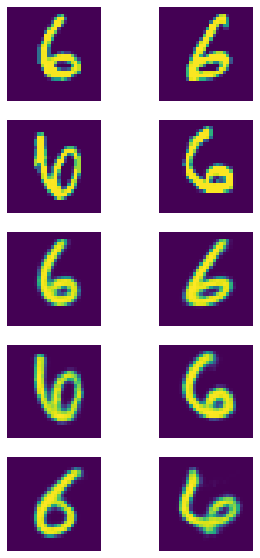

Epoch 41/50 Batch 0000/624, Loss   82.5638


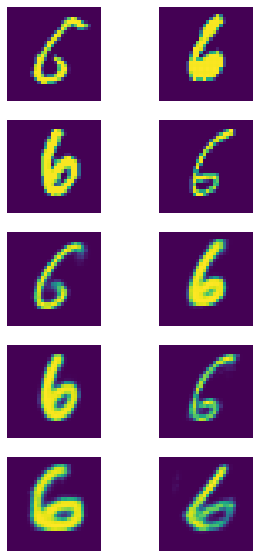

Epoch 42/50 Batch 0000/624, Loss   98.5224


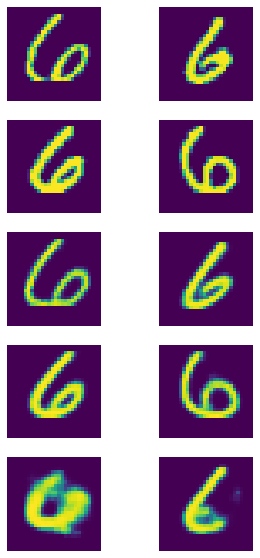

Epoch 43/50 Batch 0000/624, Loss   86.4646


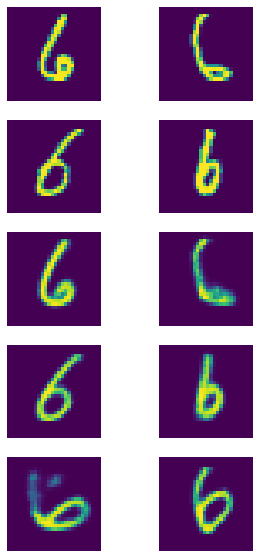

Epoch 44/50 Batch 0000/624, Loss   94.6031


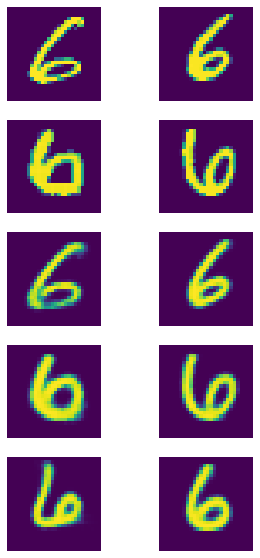

Epoch 45/50 Batch 0000/624, Loss   89.5408


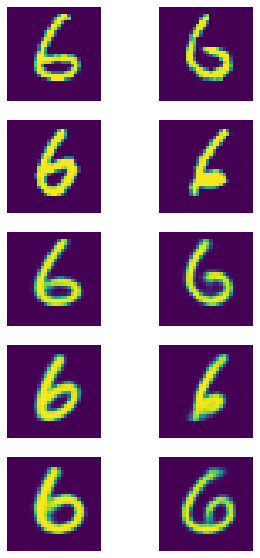

Epoch 46/50 Batch 0000/624, Loss   90.5597


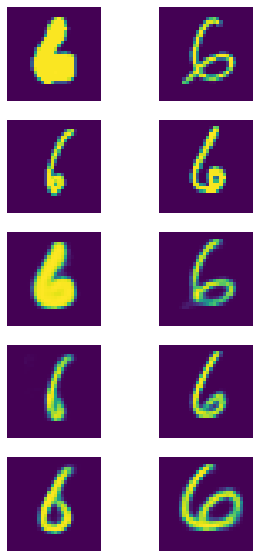

Epoch 47/50 Batch 0000/624, Loss   89.5438


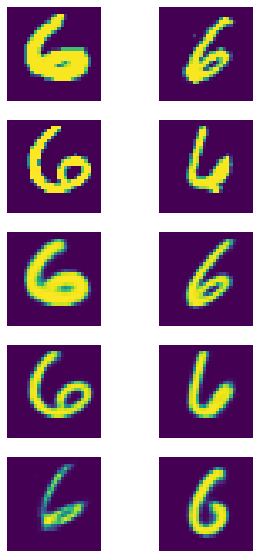

Epoch 48/50 Batch 0000/624, Loss   92.9236


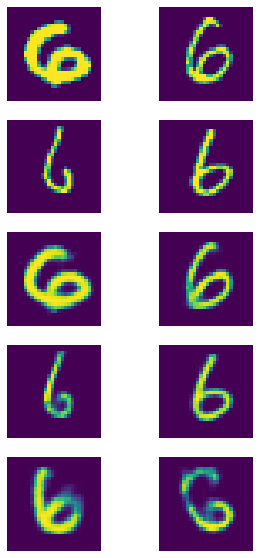

Epoch 49/50 Batch 0000/624, Loss   95.9701


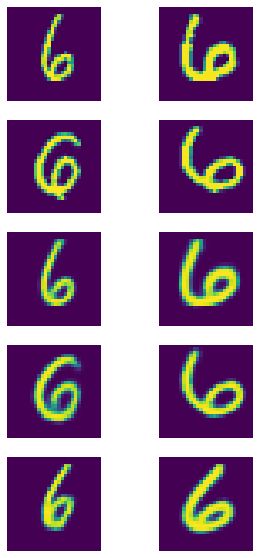

Epoch 00/50 Batch 0000/624, Loss  571.9891


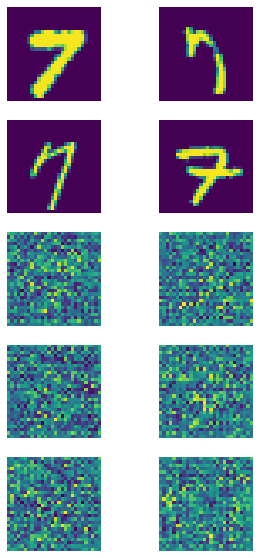

Epoch 01/50 Batch 0000/624, Loss  106.1259


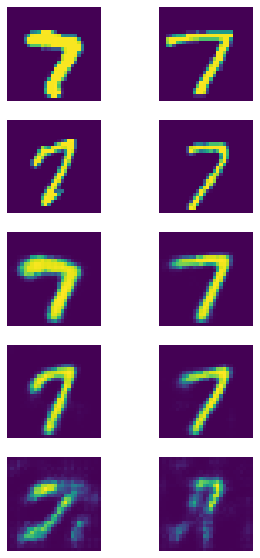

Epoch 02/50 Batch 0000/624, Loss   94.6331


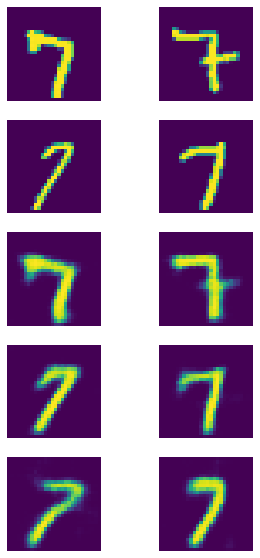

Epoch 03/50 Batch 0000/624, Loss  107.1874


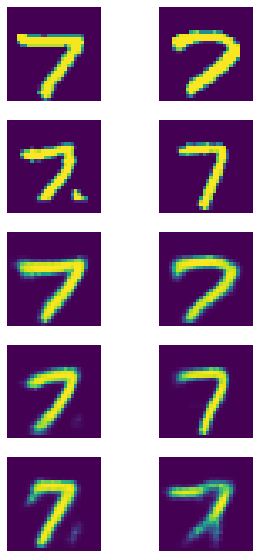

Epoch 04/50 Batch 0000/624, Loss   96.2135


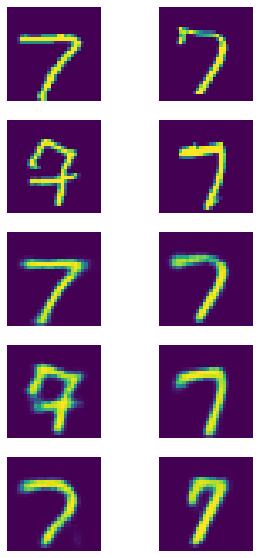

Epoch 05/50 Batch 0000/624, Loss   99.6131


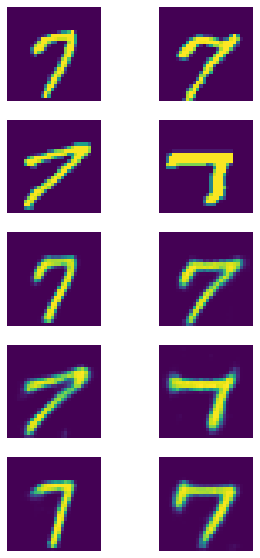

Epoch 06/50 Batch 0000/624, Loss   83.9427


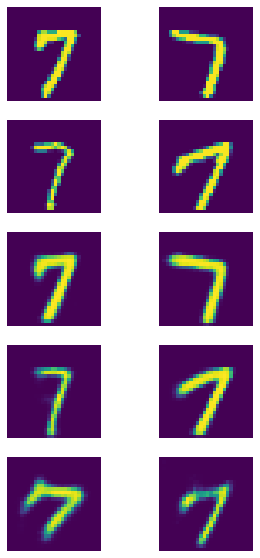

Epoch 07/50 Batch 0000/624, Loss   80.4451


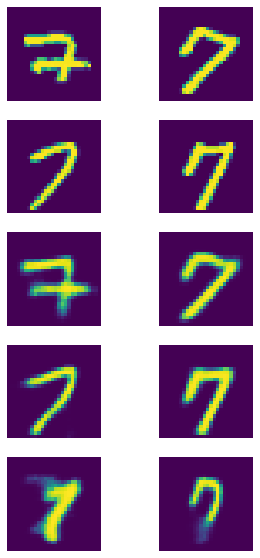

Epoch 08/50 Batch 0000/624, Loss   78.1831


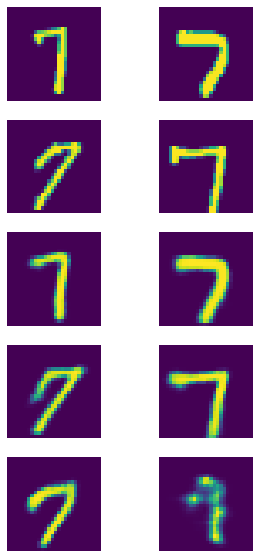

Epoch 09/50 Batch 0000/624, Loss   88.5660


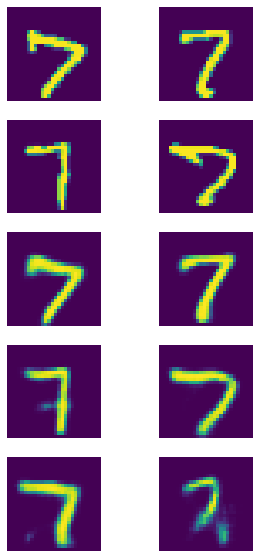

Epoch 10/50 Batch 0000/624, Loss   83.1925


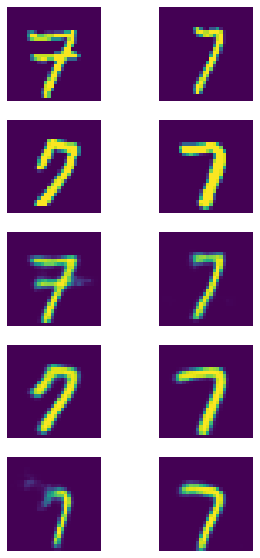

Epoch 11/50 Batch 0000/624, Loss   78.3744


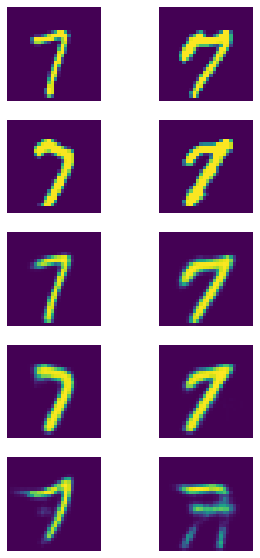

Epoch 12/50 Batch 0000/624, Loss   83.8819


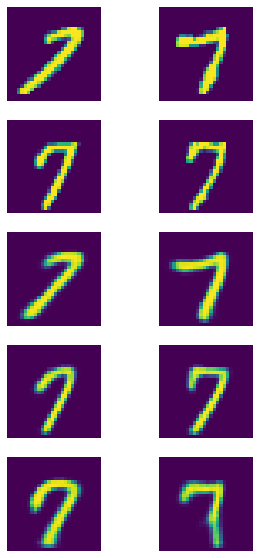

Epoch 13/50 Batch 0000/624, Loss   86.0341


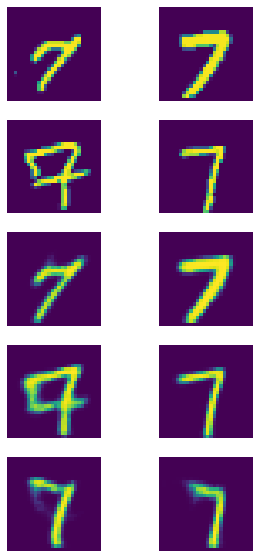

Epoch 14/50 Batch 0000/624, Loss   82.6327


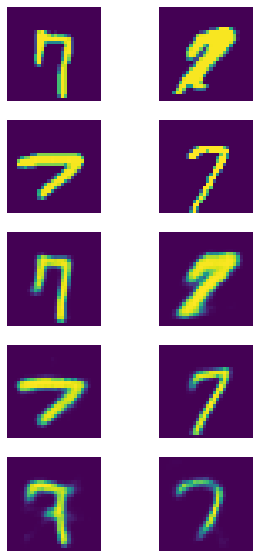

Epoch 15/50 Batch 0000/624, Loss   77.6181


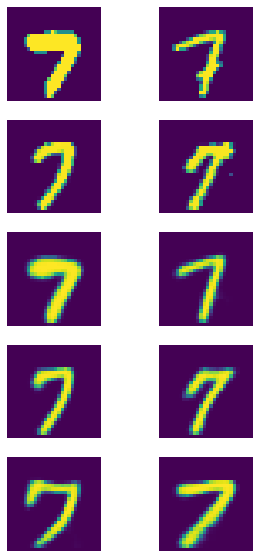

Epoch 16/50 Batch 0000/624, Loss   80.2387


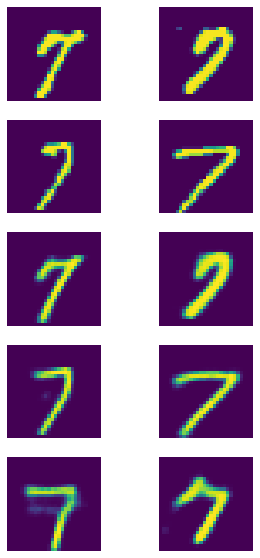

Epoch 17/50 Batch 0000/624, Loss   90.3276


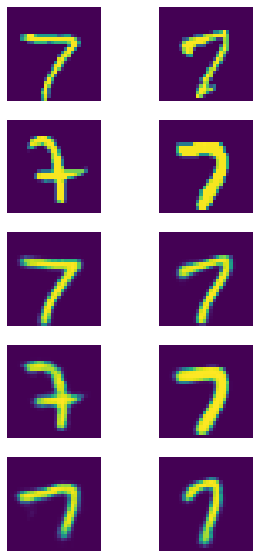

Epoch 18/50 Batch 0000/624, Loss   81.8948


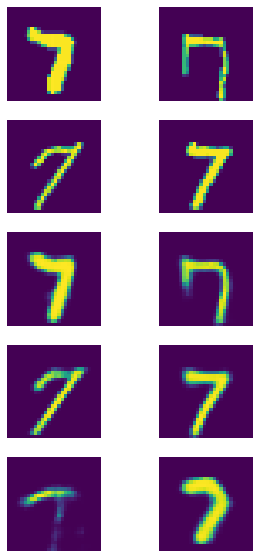

Epoch 19/50 Batch 0000/624, Loss   84.3117


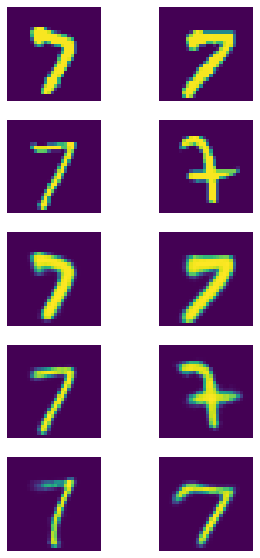

Epoch 20/50 Batch 0000/624, Loss   78.0056


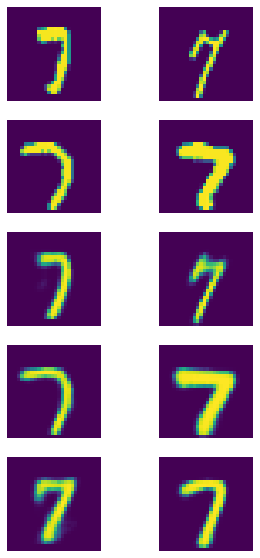

Epoch 21/50 Batch 0000/624, Loss   87.7984


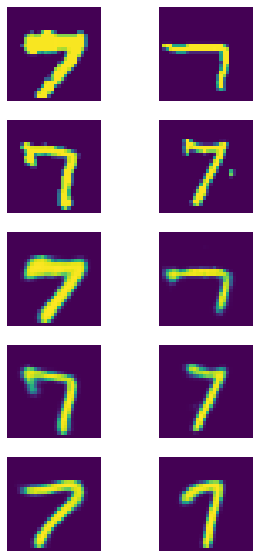

Epoch 22/50 Batch 0000/624, Loss   82.3907


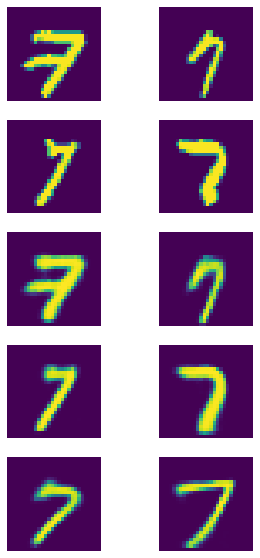

Epoch 23/50 Batch 0000/624, Loss   90.0795


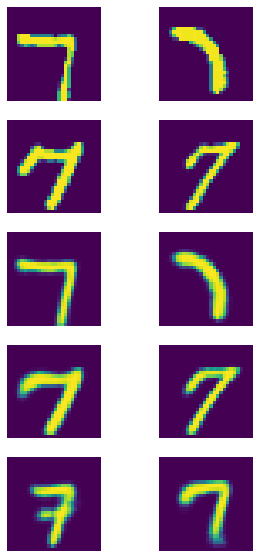

Epoch 24/50 Batch 0000/624, Loss   81.7396


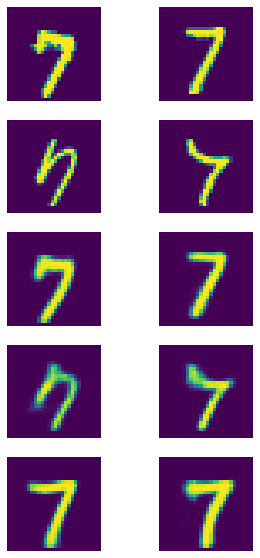

Epoch 25/50 Batch 0000/624, Loss   81.5977


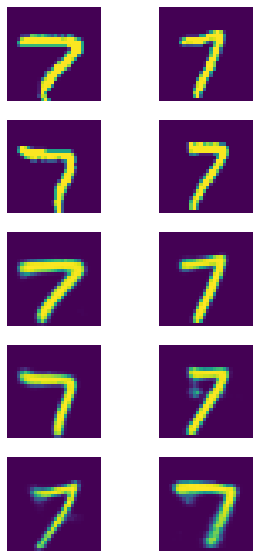

Epoch 26/50 Batch 0000/624, Loss   80.0796


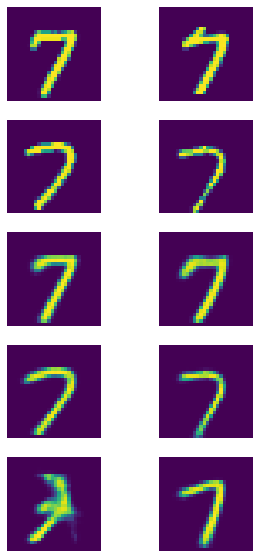

Epoch 27/50 Batch 0000/624, Loss   80.0772


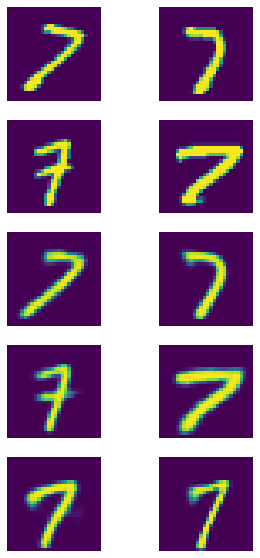

Epoch 28/50 Batch 0000/624, Loss   78.3746


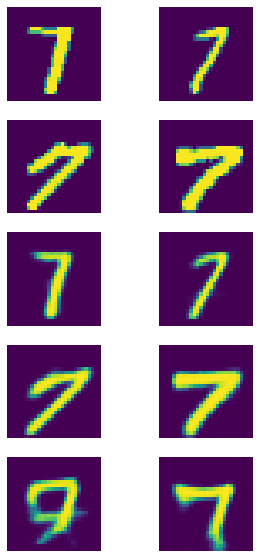

Epoch 29/50 Batch 0000/624, Loss   72.8674


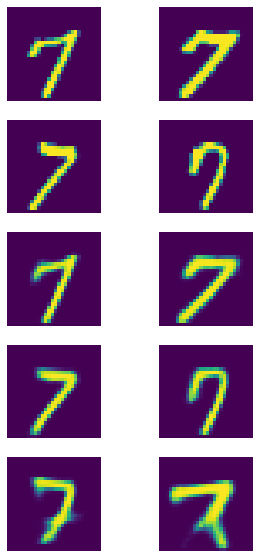

Epoch 30/50 Batch 0000/624, Loss   82.8338


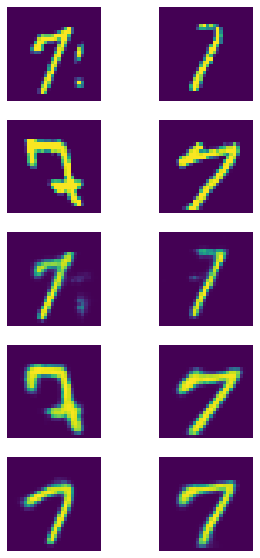

Epoch 31/50 Batch 0000/624, Loss   85.1158


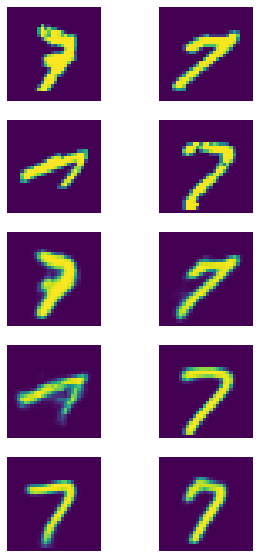

Epoch 32/50 Batch 0000/624, Loss   72.8109


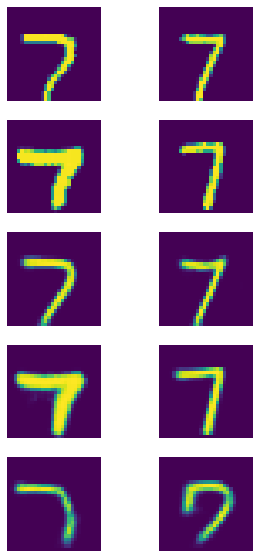

Epoch 33/50 Batch 0000/624, Loss   75.4312


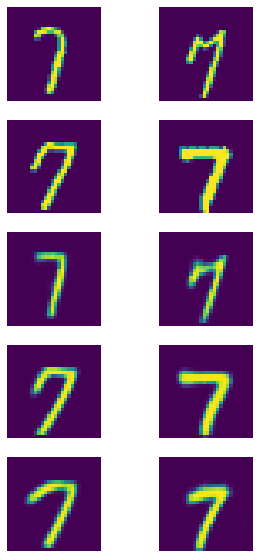

Epoch 34/50 Batch 0000/624, Loss   75.4492


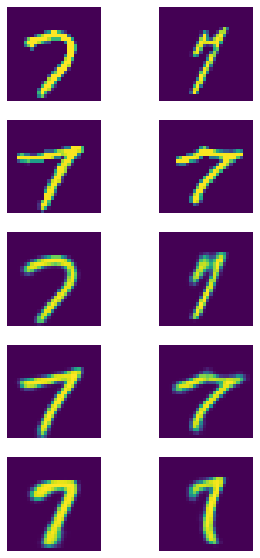

Epoch 35/50 Batch 0000/624, Loss   76.3633


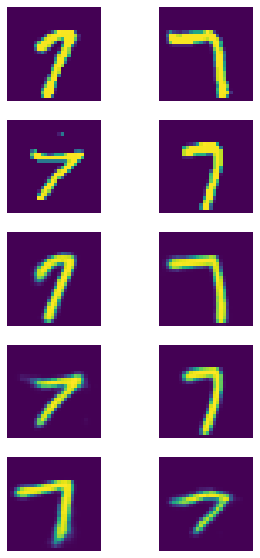

Epoch 36/50 Batch 0000/624, Loss   80.0542


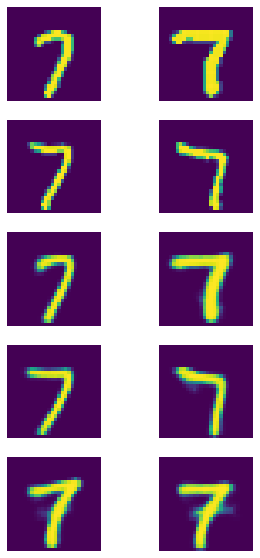

Epoch 37/50 Batch 0000/624, Loss   76.5383


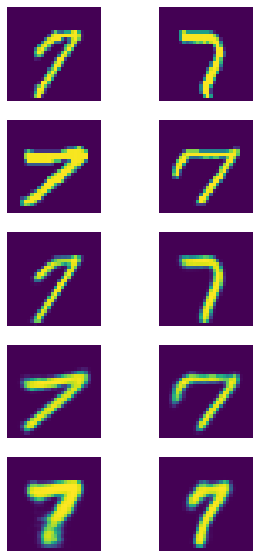

Epoch 38/50 Batch 0000/624, Loss   71.8505


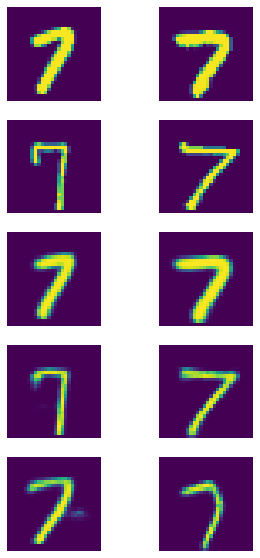

Epoch 39/50 Batch 0000/624, Loss   82.7149


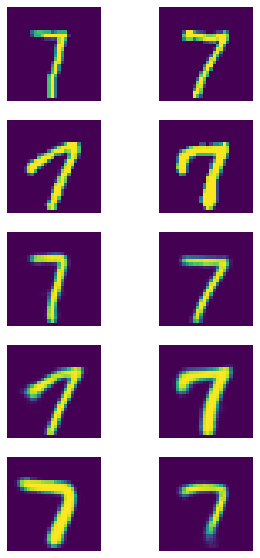

Epoch 40/50 Batch 0000/624, Loss   77.2438


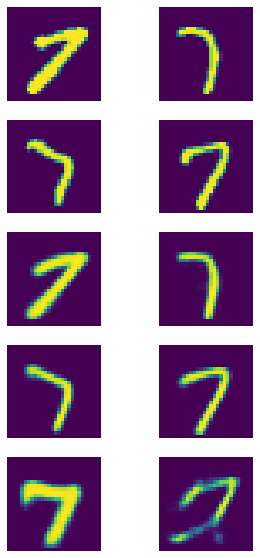

Epoch 41/50 Batch 0000/624, Loss   82.7392


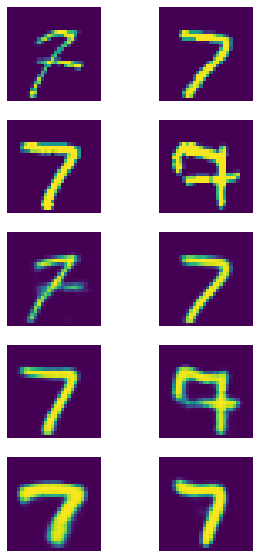

Epoch 42/50 Batch 0000/624, Loss   74.6576


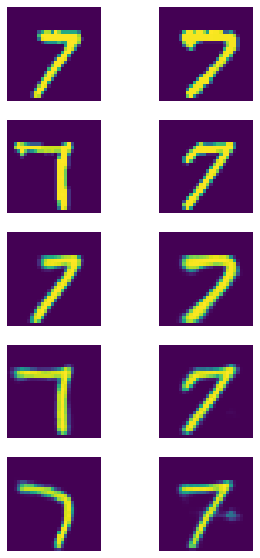

Epoch 43/50 Batch 0000/624, Loss   74.6142


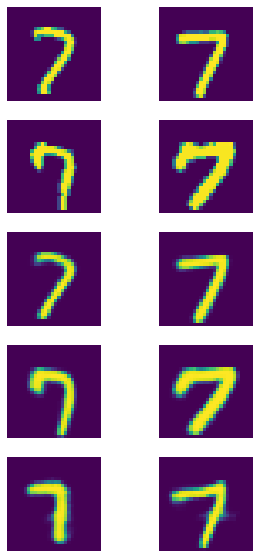

Epoch 44/50 Batch 0000/624, Loss   82.5548


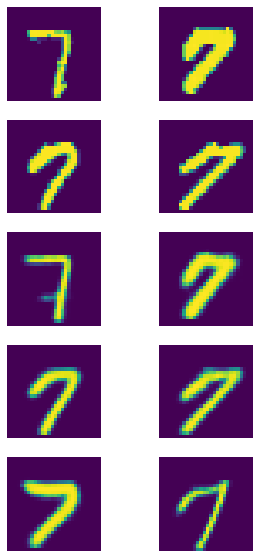

Epoch 45/50 Batch 0000/624, Loss   78.7227


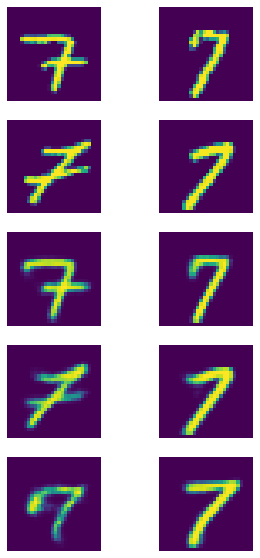

Epoch 46/50 Batch 0000/624, Loss   80.4540


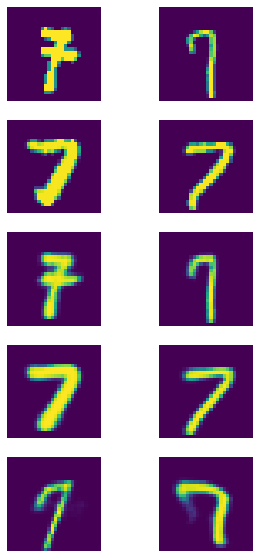

Epoch 47/50 Batch 0000/624, Loss   79.7188


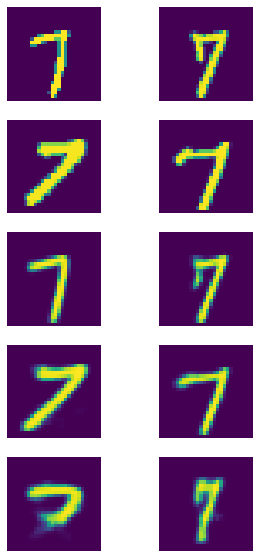

Epoch 48/50 Batch 0000/624, Loss   80.7344


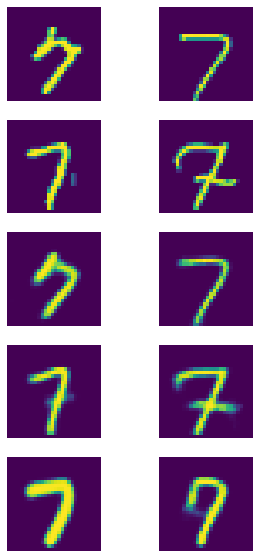

Epoch 49/50 Batch 0000/624, Loss   84.1114


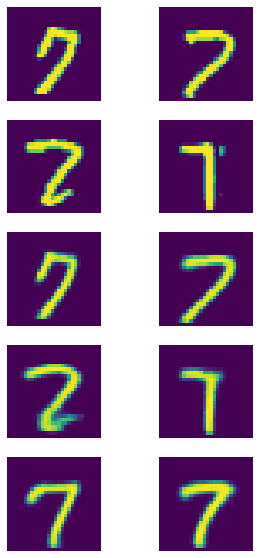

Epoch 00/50 Batch 0000/624, Loss  653.1311


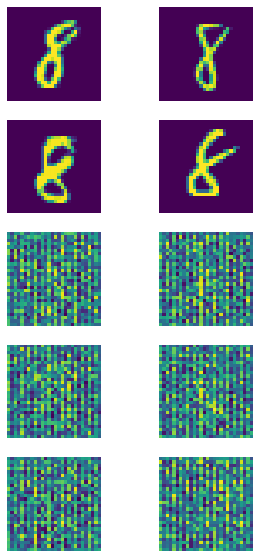

Epoch 01/50 Batch 0000/624, Loss  139.3312


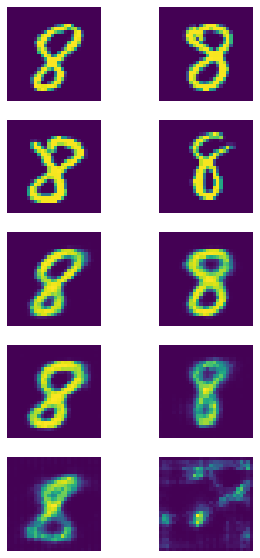

Epoch 02/50 Batch 0000/624, Loss  135.1630


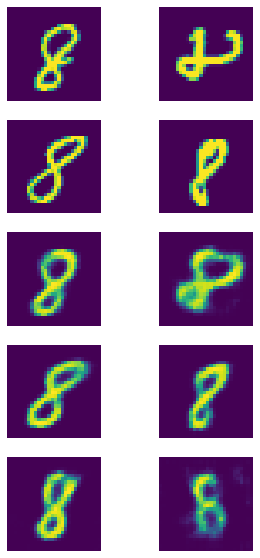

Epoch 03/50 Batch 0000/624, Loss  129.4282


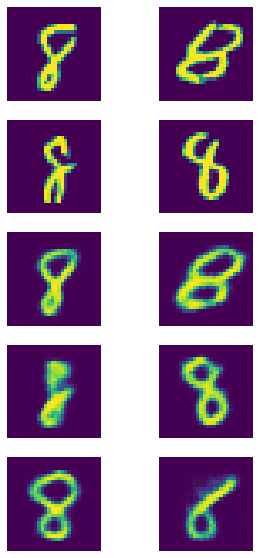

Epoch 04/50 Batch 0000/624, Loss  122.1728


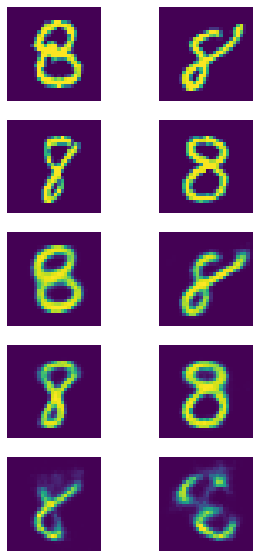

Epoch 05/50 Batch 0000/624, Loss  119.6039


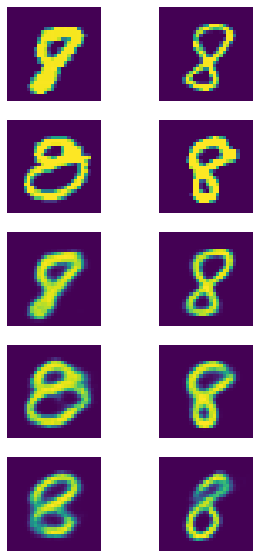

Epoch 06/50 Batch 0000/624, Loss  116.9375


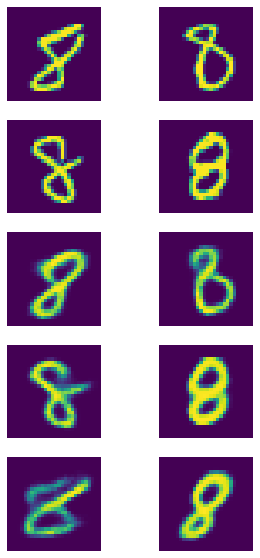

Epoch 07/50 Batch 0000/624, Loss  113.6043


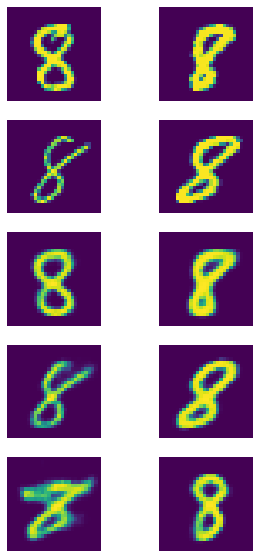

Epoch 08/50 Batch 0000/624, Loss  118.4315


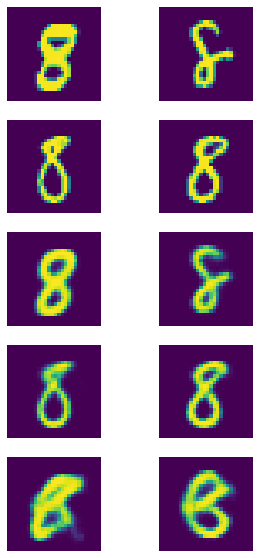

Epoch 09/50 Batch 0000/624, Loss  114.8220


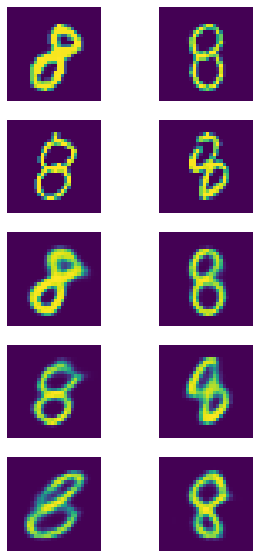

Epoch 10/50 Batch 0000/624, Loss  117.0010


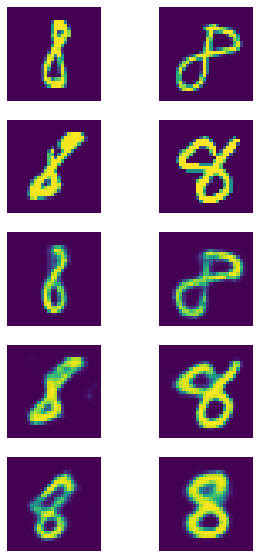

Epoch 11/50 Batch 0000/624, Loss  110.7278


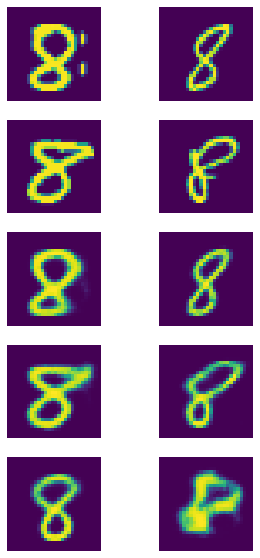

Epoch 12/50 Batch 0000/624, Loss  117.8761


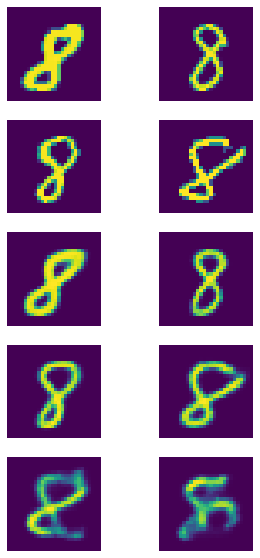

Epoch 13/50 Batch 0000/624, Loss  109.0384


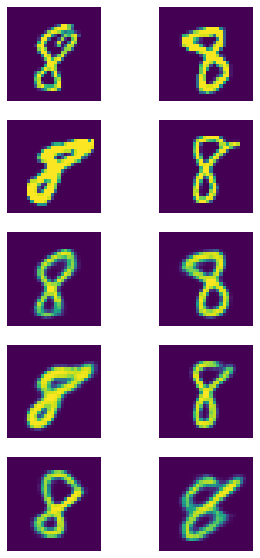

Epoch 14/50 Batch 0000/624, Loss  112.3177


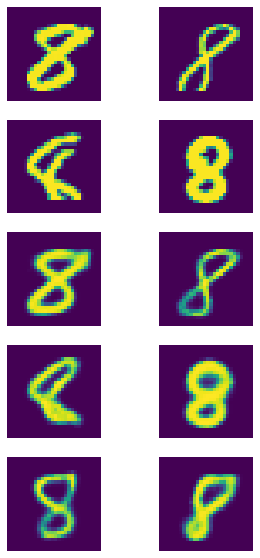

Epoch 15/50 Batch 0000/624, Loss  113.4530


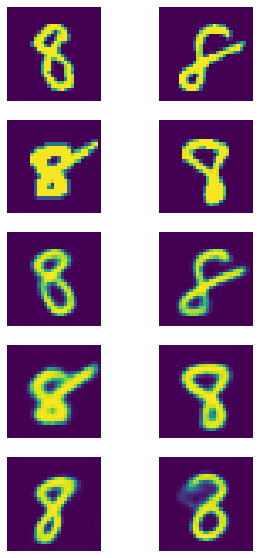

Epoch 16/50 Batch 0000/624, Loss  102.4166


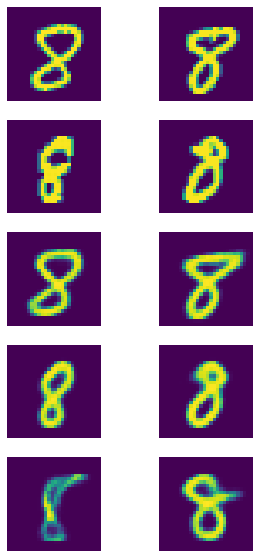

Epoch 17/50 Batch 0000/624, Loss  115.0785


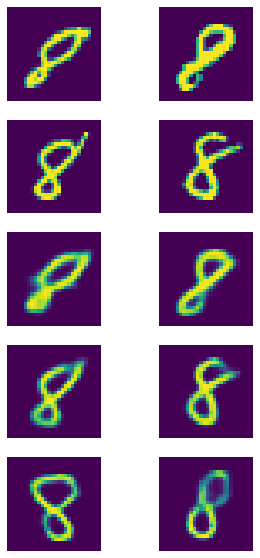

Epoch 18/50 Batch 0000/624, Loss  109.6279


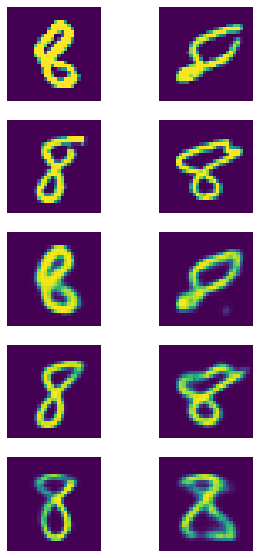

Epoch 19/50 Batch 0000/624, Loss  117.2070


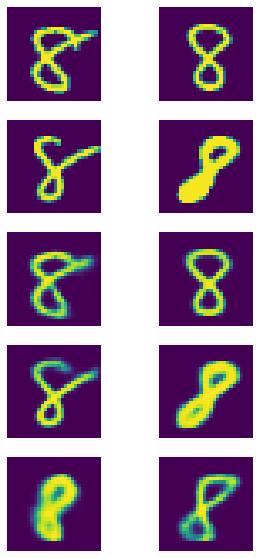

Epoch 20/50 Batch 0000/624, Loss  113.5033


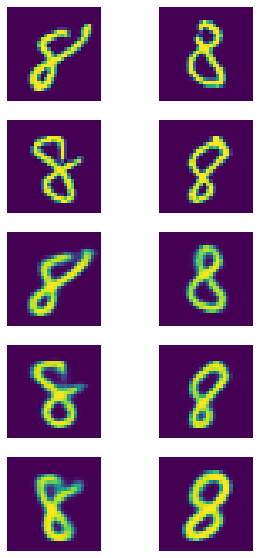

Epoch 21/50 Batch 0000/624, Loss  107.5311


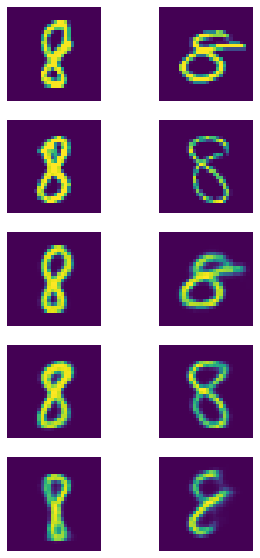

Epoch 22/50 Batch 0000/624, Loss  110.3121


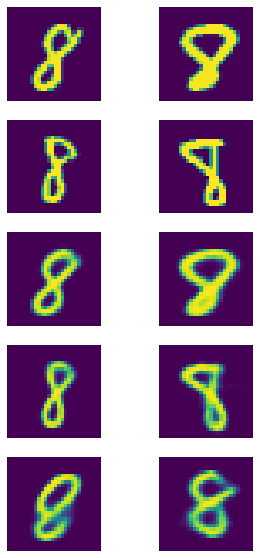

Epoch 23/50 Batch 0000/624, Loss  112.4109


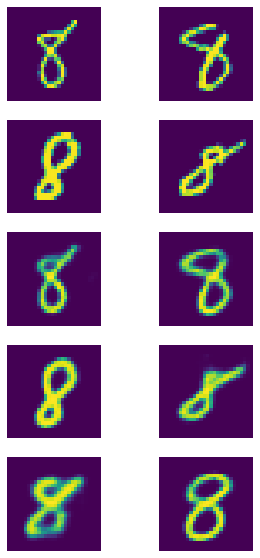

Epoch 24/50 Batch 0000/624, Loss  112.3999


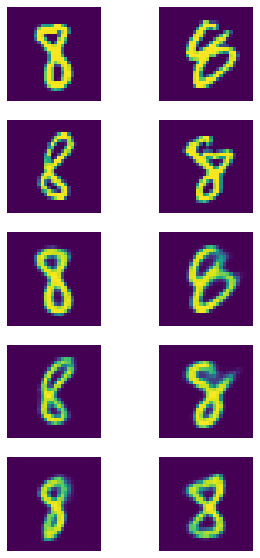

Epoch 25/50 Batch 0000/624, Loss  107.4737


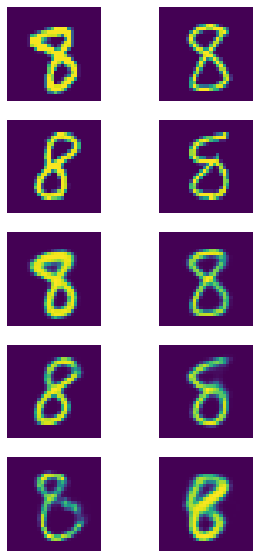

Epoch 26/50 Batch 0000/624, Loss  100.3748


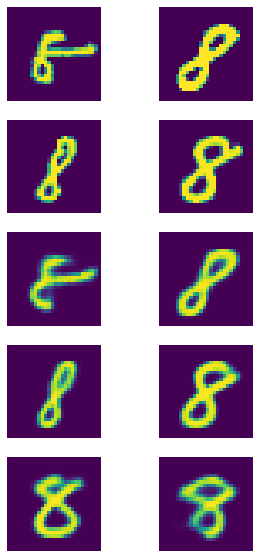

Epoch 27/50 Batch 0000/624, Loss  104.1169


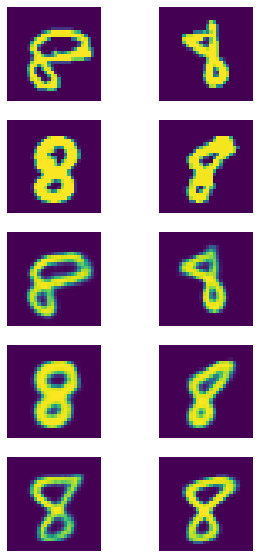

Epoch 28/50 Batch 0000/624, Loss  109.4115


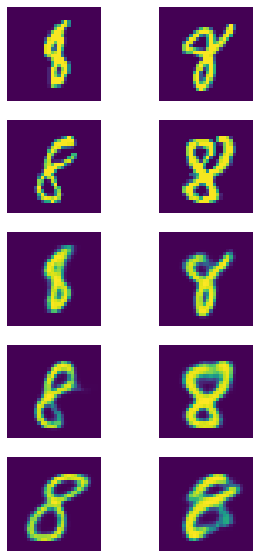

Epoch 29/50 Batch 0000/624, Loss  115.9264


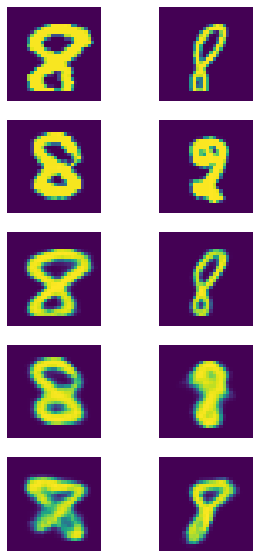

Epoch 30/50 Batch 0000/624, Loss  104.7113


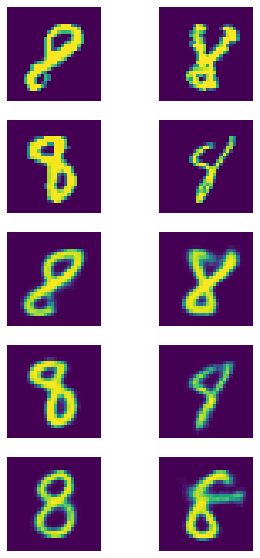

Epoch 31/50 Batch 0000/624, Loss  107.8082


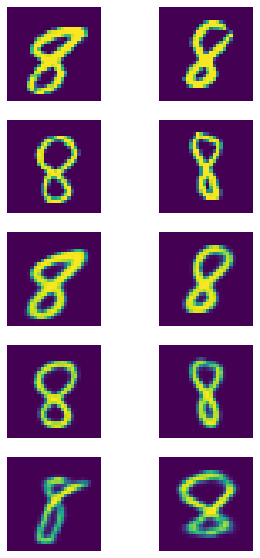

Epoch 32/50 Batch 0000/624, Loss  107.9693


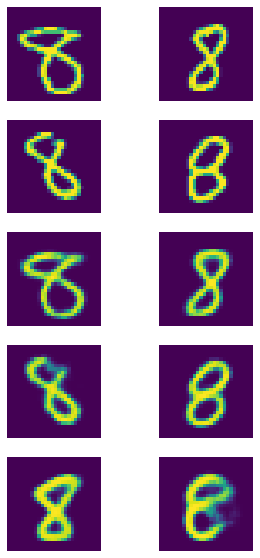

Epoch 33/50 Batch 0000/624, Loss  111.9115


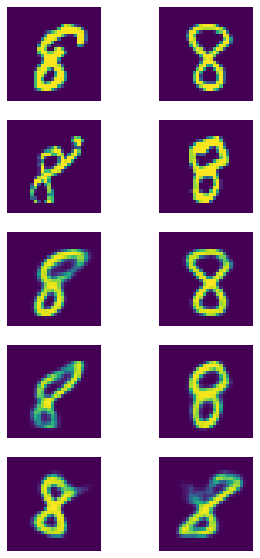

Epoch 34/50 Batch 0000/624, Loss   99.8102


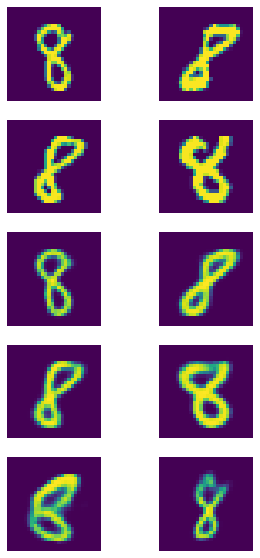

Epoch 35/50 Batch 0000/624, Loss  115.4416


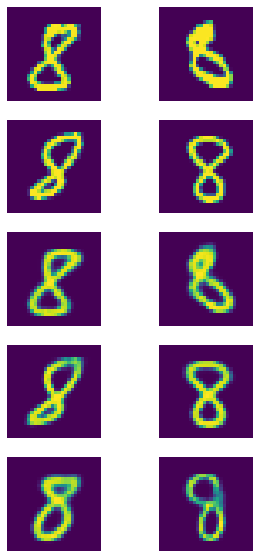

Epoch 36/50 Batch 0000/624, Loss  104.3177


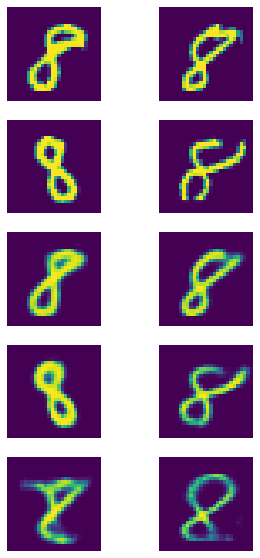

Epoch 37/50 Batch 0000/624, Loss  111.5433


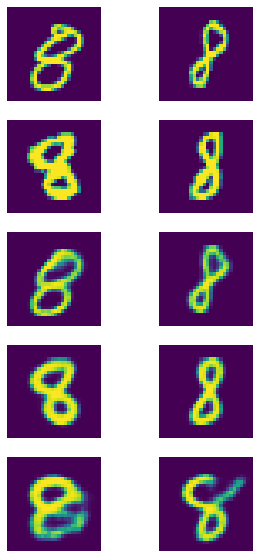

Epoch 38/50 Batch 0000/624, Loss  112.6875


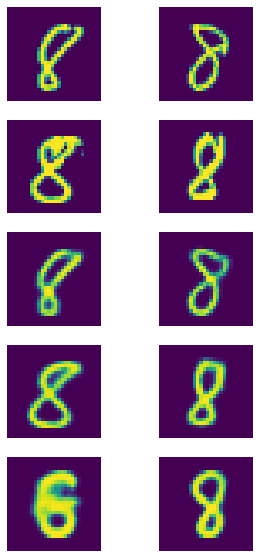

Epoch 39/50 Batch 0000/624, Loss  104.7984


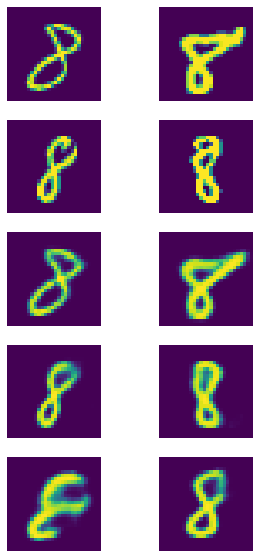

Epoch 40/50 Batch 0000/624, Loss  115.1578


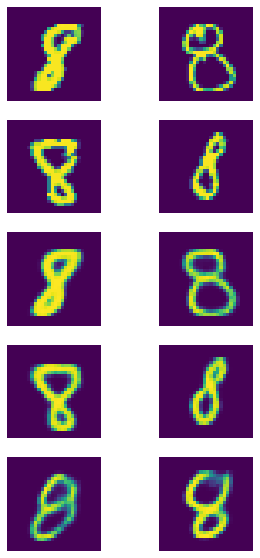

Epoch 41/50 Batch 0000/624, Loss  107.6485


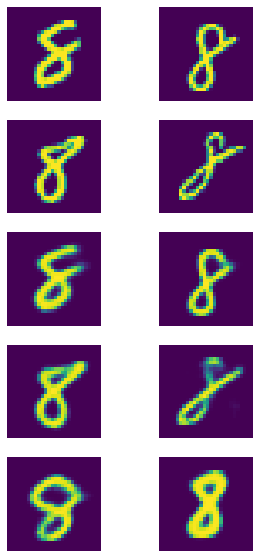

Epoch 42/50 Batch 0000/624, Loss   99.3797


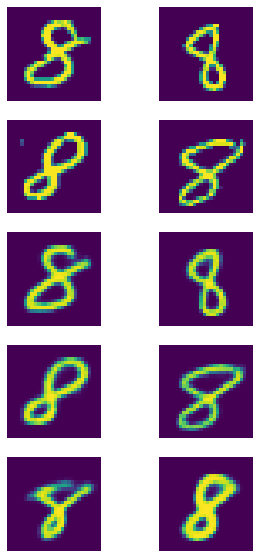

Epoch 43/50 Batch 0000/624, Loss  104.1131


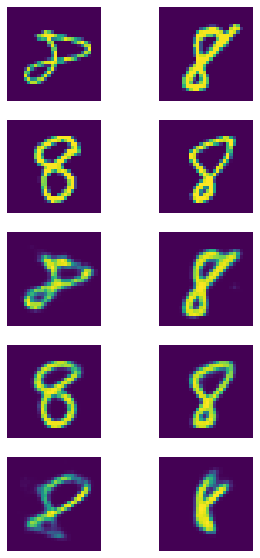

Epoch 44/50 Batch 0000/624, Loss  101.2554


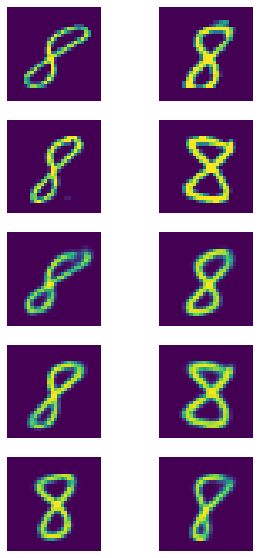

Epoch 45/50 Batch 0000/624, Loss   94.9435


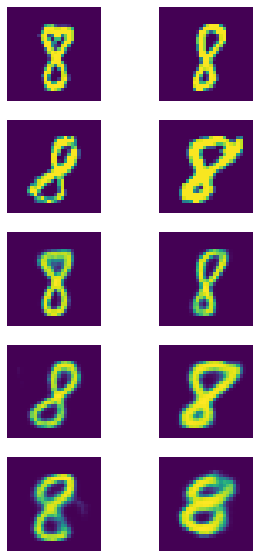

Epoch 46/50 Batch 0000/624, Loss  102.2271


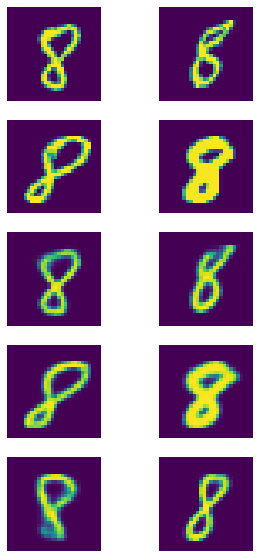

Epoch 47/50 Batch 0000/624, Loss  102.3275


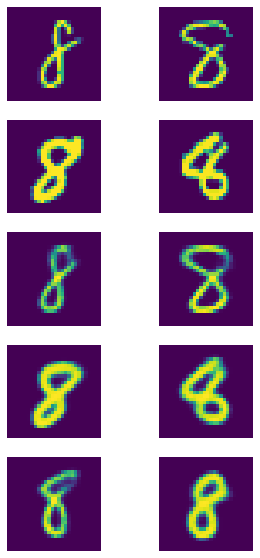

Epoch 48/50 Batch 0000/624, Loss  101.6726


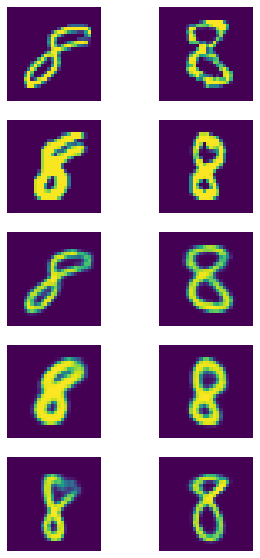

Epoch 49/50 Batch 0000/624, Loss  106.4639


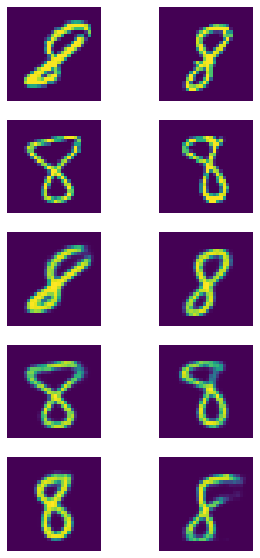

Epoch 00/50 Batch 0000/624, Loss  582.7780


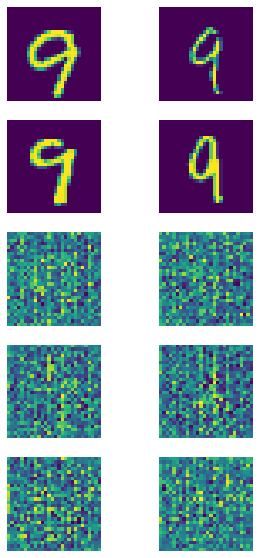

Epoch 01/50 Batch 0000/624, Loss  134.1144


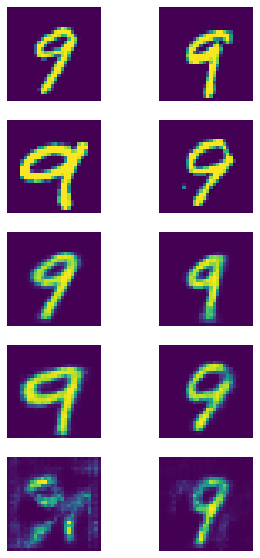

Epoch 02/50 Batch 0000/624, Loss  114.3296


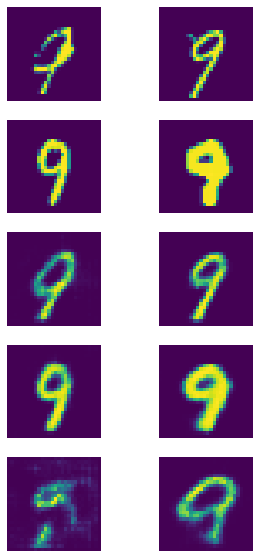

Epoch 03/50 Batch 0000/624, Loss  106.9477


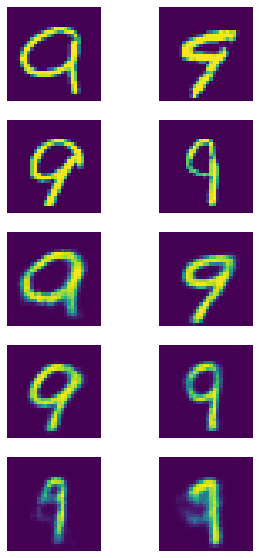

Epoch 04/50 Batch 0000/624, Loss   95.9845


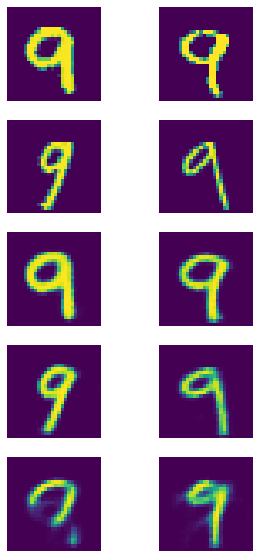

Epoch 05/50 Batch 0000/624, Loss  101.3548


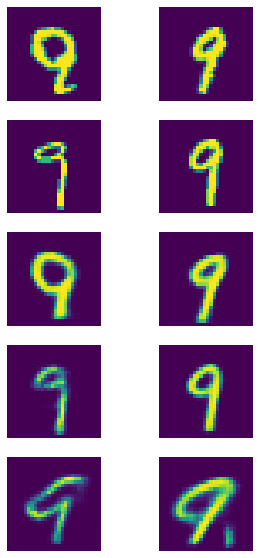

Epoch 06/50 Batch 0000/624, Loss   95.2775


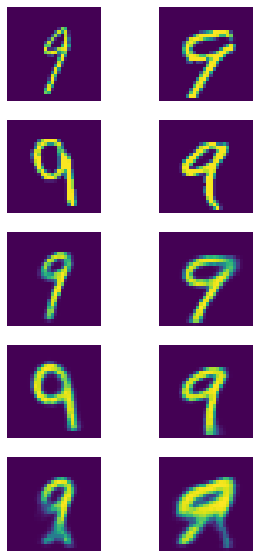

Epoch 07/50 Batch 0000/624, Loss   92.7535


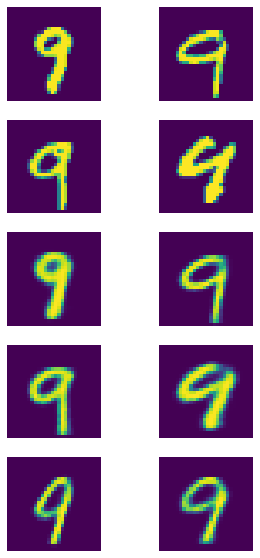

Epoch 08/50 Batch 0000/624, Loss   92.1610


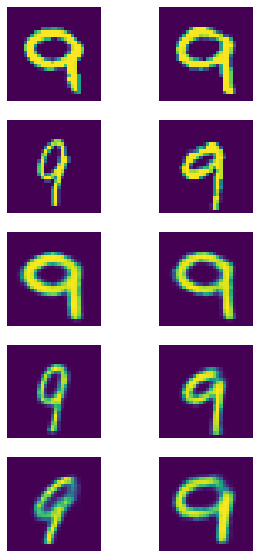

Epoch 09/50 Batch 0000/624, Loss   98.5461


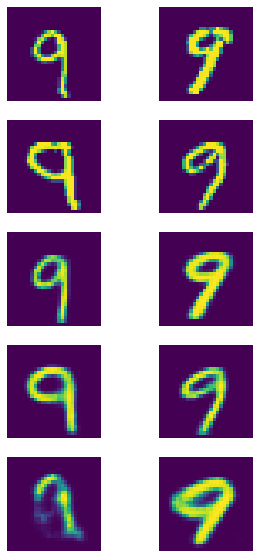

Epoch 10/50 Batch 0000/624, Loss   89.3232


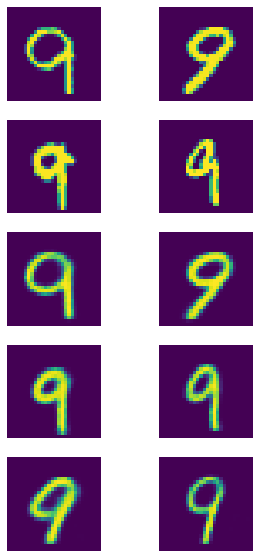

Epoch 11/50 Batch 0000/624, Loss   88.9704


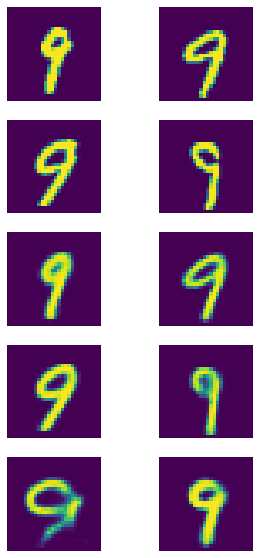

Epoch 12/50 Batch 0000/624, Loss   93.8023


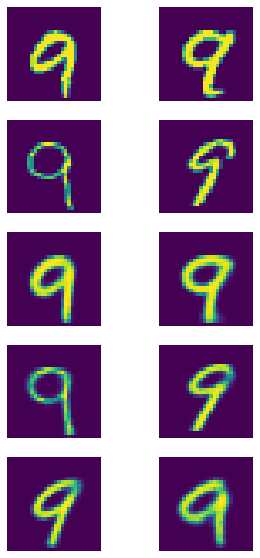

Epoch 13/50 Batch 0000/624, Loss   93.9811


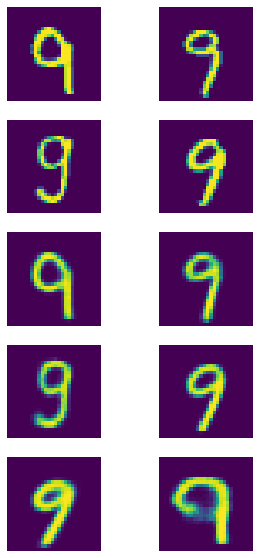

Epoch 14/50 Batch 0000/624, Loss   90.4508


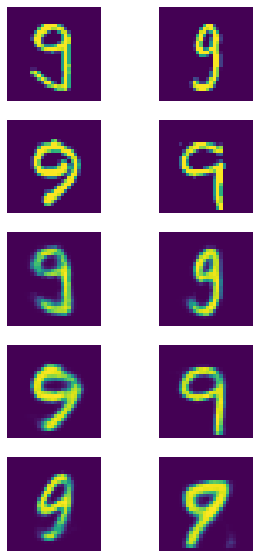

Epoch 15/50 Batch 0000/624, Loss   93.3697


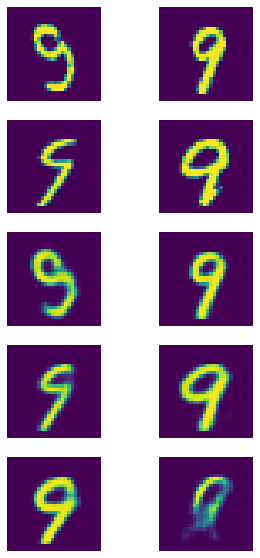

Epoch 16/50 Batch 0000/624, Loss   87.9912


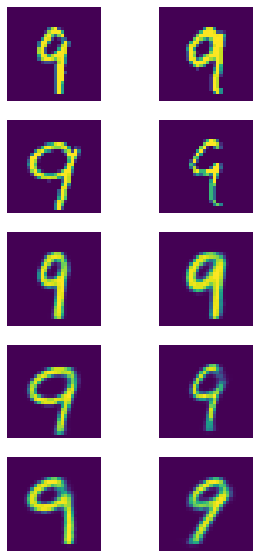

Epoch 17/50 Batch 0000/624, Loss   92.8973


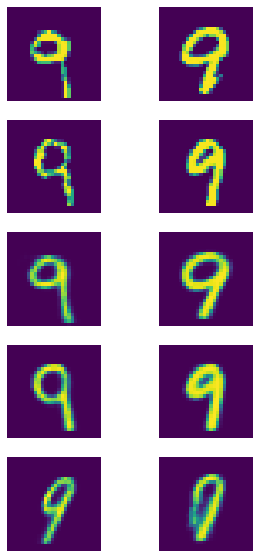

Epoch 18/50 Batch 0000/624, Loss   87.1910


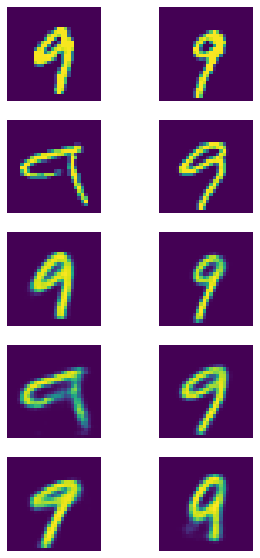

Epoch 19/50 Batch 0000/624, Loss   86.6031


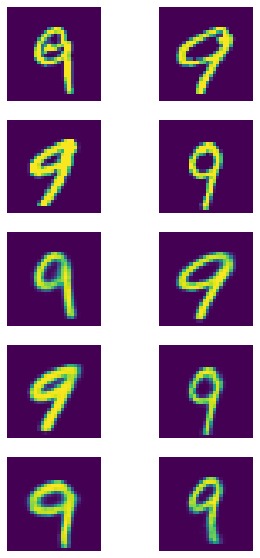

Epoch 20/50 Batch 0000/624, Loss   80.9920


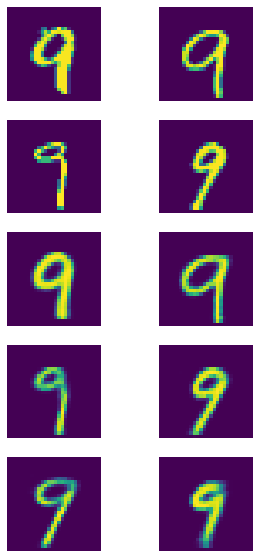

Epoch 21/50 Batch 0000/624, Loss   98.2989


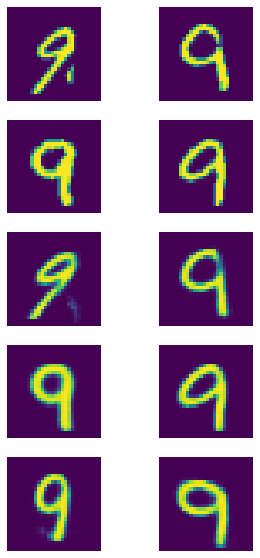

Epoch 22/50 Batch 0000/624, Loss   78.7336


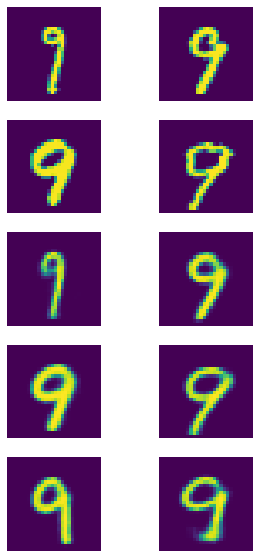

Epoch 23/50 Batch 0000/624, Loss   92.7760


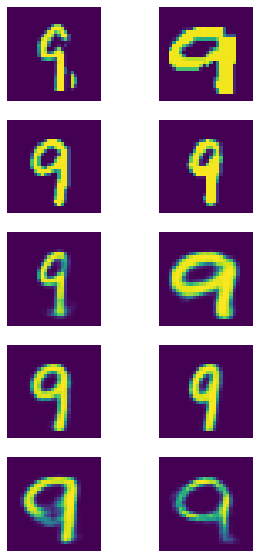

Epoch 24/50 Batch 0000/624, Loss   84.1486


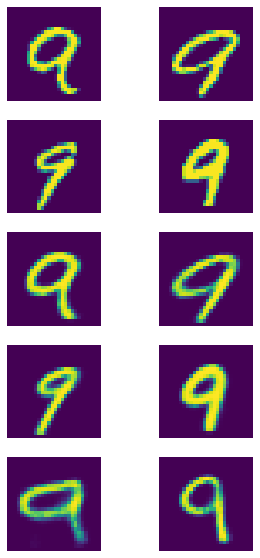

Epoch 25/50 Batch 0000/624, Loss   85.1370


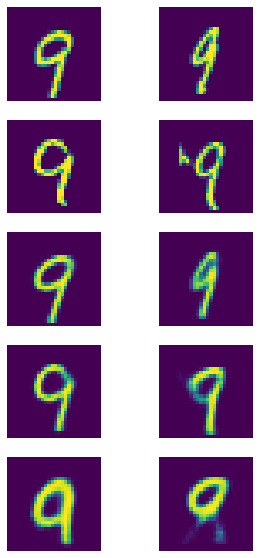

Epoch 26/50 Batch 0000/624, Loss   84.0484


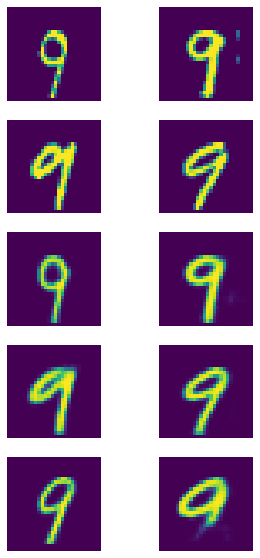

Epoch 27/50 Batch 0000/624, Loss   84.7279


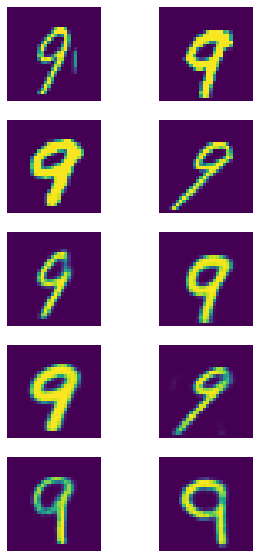

Epoch 28/50 Batch 0000/624, Loss   93.6775


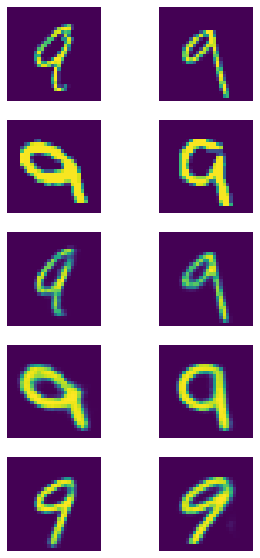

Epoch 29/50 Batch 0000/624, Loss   85.2407


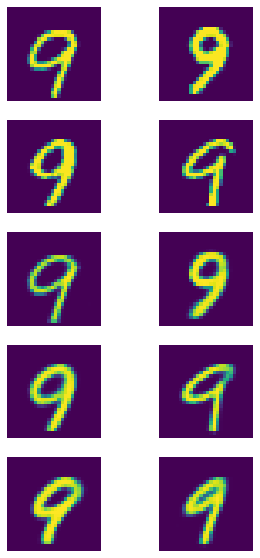

Epoch 30/50 Batch 0000/624, Loss   84.8331


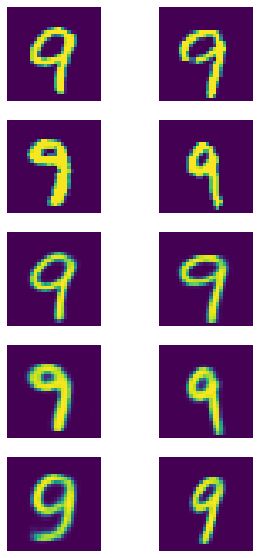

Epoch 31/50 Batch 0000/624, Loss   86.1702


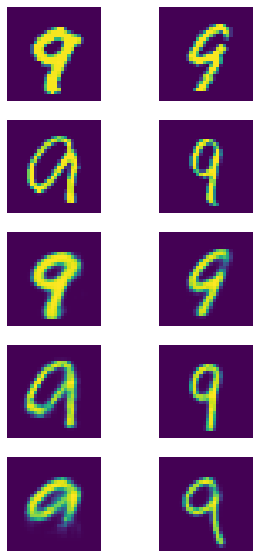

Epoch 32/50 Batch 0000/624, Loss   91.2362


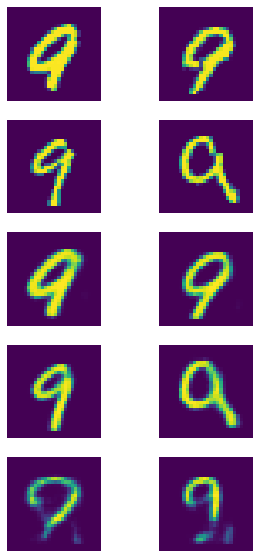

Epoch 33/50 Batch 0000/624, Loss   82.8636


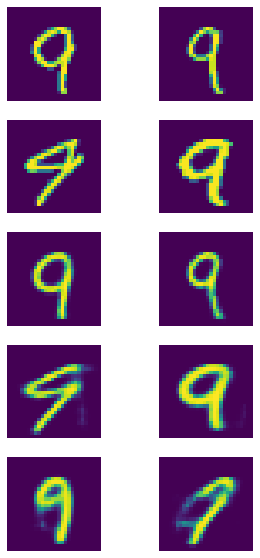

Epoch 34/50 Batch 0000/624, Loss   87.8652


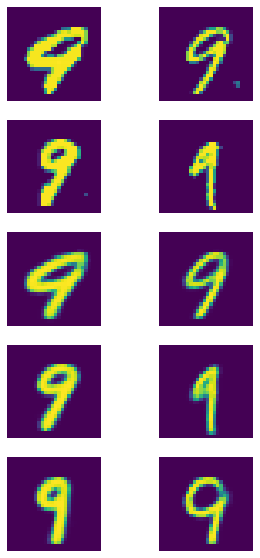

Epoch 35/50 Batch 0000/624, Loss   82.6521


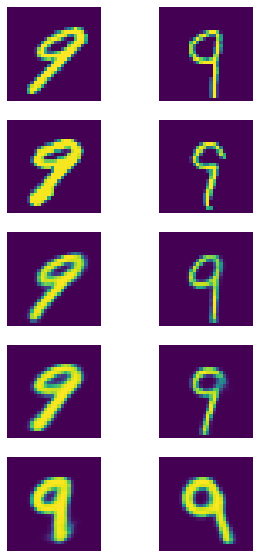

Epoch 36/50 Batch 0000/624, Loss   86.1584


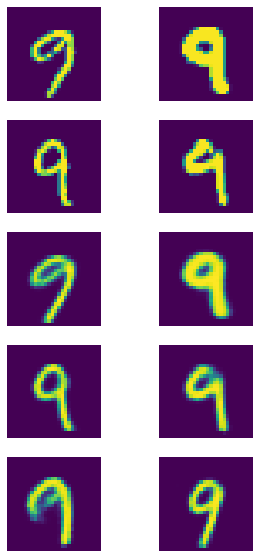

Epoch 37/50 Batch 0000/624, Loss   89.8358


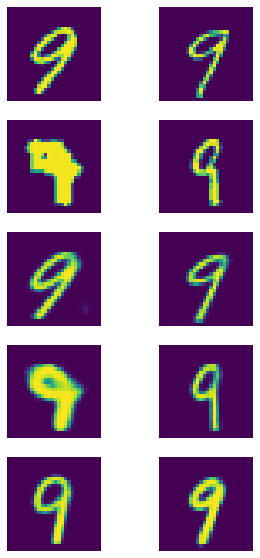

Epoch 38/50 Batch 0000/624, Loss   82.2238


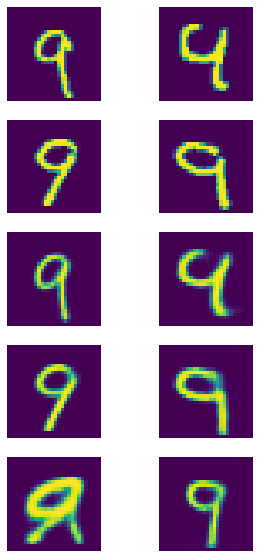

Epoch 39/50 Batch 0000/624, Loss   83.2365


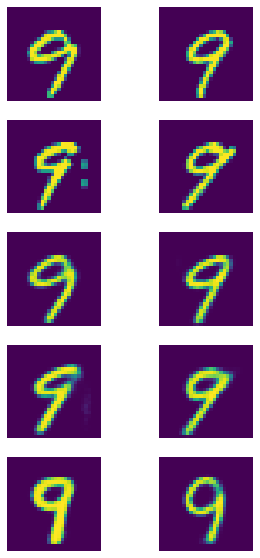

Epoch 40/50 Batch 0000/624, Loss   92.4482


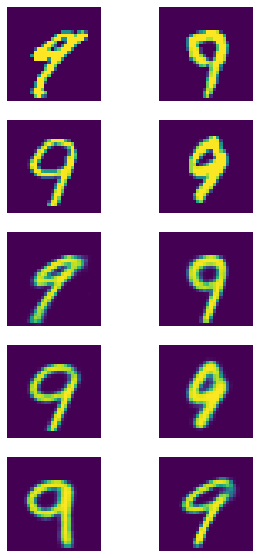

Epoch 41/50 Batch 0000/624, Loss   89.3528


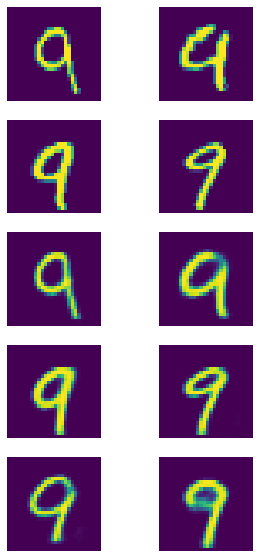

Epoch 42/50 Batch 0000/624, Loss   87.0828


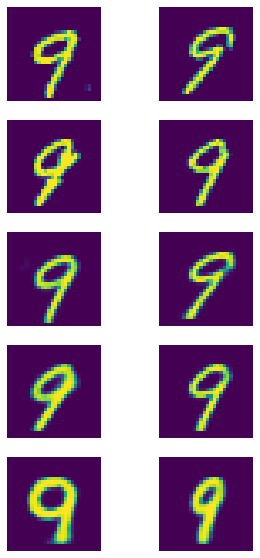

Epoch 43/50 Batch 0000/624, Loss   91.1940


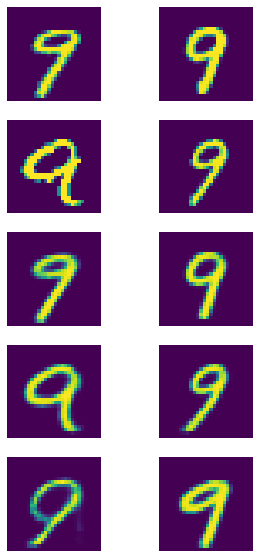

Epoch 44/50 Batch 0000/624, Loss   81.6454


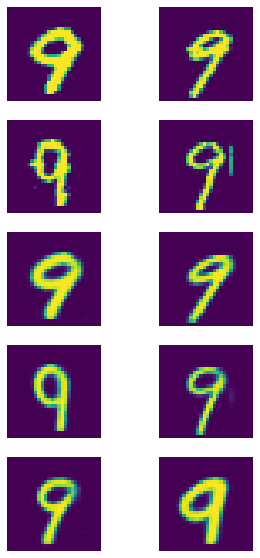

Epoch 45/50 Batch 0000/624, Loss   86.4247


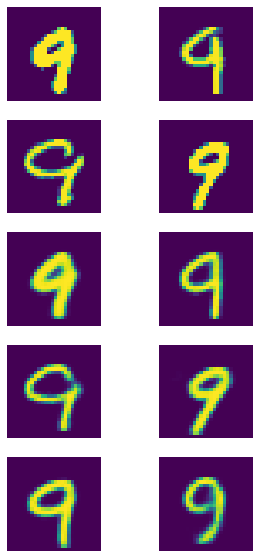

Epoch 46/50 Batch 0000/624, Loss   86.8880


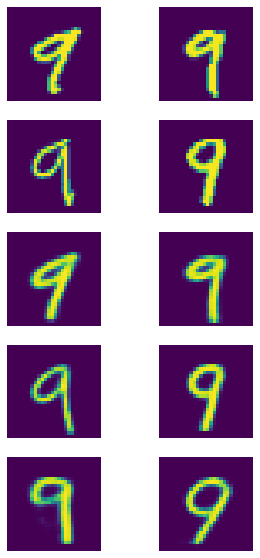

Epoch 47/50 Batch 0000/624, Loss   87.5336


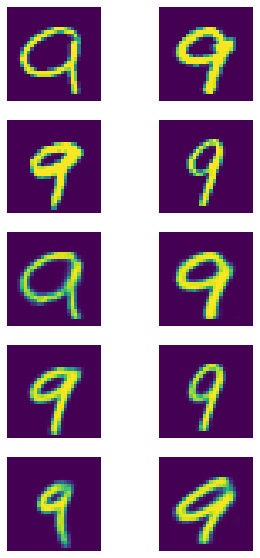

Epoch 48/50 Batch 0000/624, Loss   81.5618


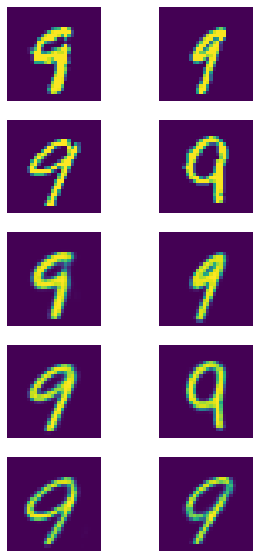

Epoch 49/50 Batch 0000/624, Loss   84.7609


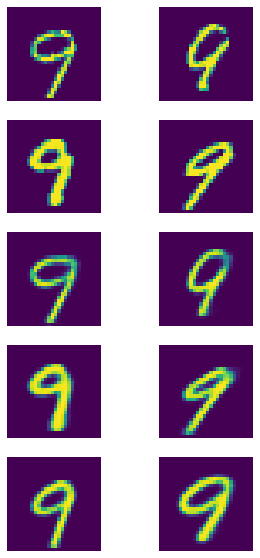

In [ ]:
%cd /content/drive/MyDrive
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict

def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 28*28*1), x.view(-1, 28*28*1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes,
#     conditional=conditional,
#     num_labels=n_labels if conditional else 0).to(device)

def get_recon(models,X,Y) :
    recons = []
    for k in range(X.shape[0]) :
        recon,_,_,_ = models[Y[k]](X[k:(k+1)])
        recons.append(recon)
    recons = torch.cat(recons)
    return recons

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


ts = time.time()

# dataset = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)
data_loader = DataLoader(
    dataset=test_dataset_raw, batch_size=batch_size, shuffle=True)

# data_loader = test_loader


logs = defaultdict(list)
for clas in range(10) :
    conditional = False
    model = VAE_conv(
            label='MNIST',
            image_size=28,
            channel_num=1,
            kernel_num=128,
            z_size=128,
            conditional=False,
            n_labels=10
        ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_indices = get_same_index(train_dataset_raw.targets, clas)
    bird_set = torch.utils.data.Subset(train_dataset_raw, train_indices)
    train_loader_dash = torch.utils.data.DataLoader(dataset=bird_set, shuffle=True,
                                           batch_size=batch_size, drop_last=True)
    for epoch in range(epochs):
        tracker_epoch = defaultdict(lambda: defaultdict(dict))
        for iteration, (x, y) in enumerate(train_loader_dash):
            x, y = x.to(device), y.to(device)
            # print(x.shape)
            if conditional:
                recon_x, mean, log_var, z = model(x, y)
            else:
                recon_x, mean, log_var, z = model(x)

            for i, yi in enumerate(y):
                id = len(tracker_epoch)
                tracker_epoch[id]['x'] = z[i, 0].item()
                tracker_epoch[id]['y'] = z[i, 1].item()
                tracker_epoch[id]['label'] = yi.item()
            # print(recon_x.shape)
            loss = loss_fn(recon_x, x, mean, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            logs['loss'].append(loss.item())

            if iteration % 600 == 0 or iteration == len(data_loader)-1:
                print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                    epoch, epochs, iteration, len(data_loader)-1, loss.item()))
                torch.save(model.state_dict(), 'curr_t'+str(clas)+'.pt')
                if conditional:
                    c = torch.arange(0, n_labels).long().unsqueeze(1).to(device)
                    z = torch.randn([c.size(0), 128]).to(device)
                    x = model.inference(z, c=c)
                else:
                    z_dash = torch.randn([10, 128]).to(device)
                    z_dash[4:8,:] = z[:4,:]
                    x_dash = model.inference(z_dash)
                    x_dash[:4,:,:,:] = x[:4,:,:,:]

                # plt.figure()
                plt.figure(figsize=(5, 10))
                for p in range(10):
                    plt.subplot(5, 2, p+1)
                    if conditional:
                        plt.text(
                            0, 0, "c={:d}".format(c[p].item()), color='black',
                            backgroundcolor='white', fontsize=8)
                    plt.imshow(x_dash[p].view(1,28,28).permute(1,2,0)[:,:,0].cpu().data.numpy())
                    plt.axis('off')
                plt.show()
                # plt.clf()
                # plt.close('all')

        df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
        # g = sns.lmplot(
        #     x='x', y='y', hue='label', data=df.groupby('label').head(100),
        #     fit_reg=False, legend=True)



# Load trained models

In [11]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, 28*28*1), x.view(-1, 28*28*1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes,
#     conditional=conditional,
#     num_labels=n_labels if conditional else 0).to(device)

def get_recon(models,X,Y) :
    recons = []
    for k in range(X.shape[0]) :
        recon,_,_,_ = models[Y[k]](X[k:(k+1)])
        recons.append(recon)
    recons = torch.cat(recons)
    return recons

models = []
avg_recon_error = []
for clas in range(10) :
    print(clas)
    model = VAE_conv(
            label='MNIST',
            image_size=28,
            channel_num=1,
            kernel_num=128,
            z_size=128,
            conditional=False,
            n_labels=10
        ).to(device)
    model.load_state_dict(torch.load('curr_t'+str(clas)+'.pt', map_location=torch.device('cpu')))
    models.append(model)
    train_indices = get_same_index(train_dataset_raw.targets, clas)
    bird_set = torch.utils.data.Subset(train_dataset_raw, train_indices)
    train_loader_dash = torch.utils.data.DataLoader(dataset=bird_set, shuffle=True,
                                           batch_size=128, drop_last=True)
    for iteration, (x, y) in enumerate(train_loader_dash):
        x, y = x.to(device), y.to(device)
        x_dash,_,_,_ = model(x)
        avg_recon_error.append(torch.nn.functional.binary_cross_entropy(
        x_dash.view(-1, 28*28*1), x.view(-1, 28*28*1),reduction='mean').detach().cpu().numpy())
        break
avg_recon_error = torch.tensor(np.array(avg_recon_error)).unsqueeze(1).to(device)
print(avg_recon_error)

/content/drive/My Drive
0
1
2
3
4
5
6
7
8
9
tensor([[0.1044],
        [0.0486],
        [0.0996],
        [0.0966],
        [0.0875],
        [0.0999],
        [0.0907],
        [0.0777],
        [0.1038],
        [0.0896]], device='cuda:0')


# Experiments (Convolution)

In [12]:
# Experiments

np.random.seed(1)
torch.random.manual_seed(1)
import matplotlib.pyplot as plt

types = ['normal','random','fgsm','fgsm-L2','R-fgsm','R-fgsm-L2','BIM','BIM-L2','CW','S-BIM']          
data_loader = DataLoader(
    dataset=test_dataset_raw, batch_size=16, shuffle=True)

recons_errors = {}
no_of_incorrects = {}
no_of_corrects = {}
curr_i = {}
for t in types :
  recons_errors[t] = np.zeros(16*len(data_loader))
  no_of_incorrects[t] = 0
  no_of_corrects[t] = 0
  curr_i[t] = 0

model.eval()
epsilon = 20/255
epsilon_step = 4/255

epsilon1 = 500/255
epsilon_step1 = 60/255
sigma = 0.5
no_of_iters = 12
no_of_iters1 = 12
epsilon_random = 4/255

for iteration, (x, y) in enumerate(tqdm(data_loader,position=0,leave=True)):
    x, y = x.to(device), y.to(device)
    for t in types :
        if t == 'normal' :
          x_type = x
        if t == 'random' :
          x_type = random(x,epsilon)
        if t == 'fgsm' :
          x_type = fgsm(model_raw,x,y,epsilon)
        if t == 'fgsm-L2' :
          x_type = fgsm_L2(model_raw,x,y,epsilon1)
        if t == 'R-fgsm' :
          x_type = R_fgsm(model_raw,x,y,epsilon,epsilon_random)
        if t == 'R-fgsm-L2' :
          x_type = R_fgsm_L2(model_raw,x,y,epsilon1,epsilon_random)
        if t == 'BIM' :
          x_type = BIM(model_raw,x,y,epsilon,epsilon_step,no_of_iters)
        if t == 'BIM-L2' :
          x_type = BIM_L2(model_raw,x,y,epsilon1,epsilon_step1,no_of_iters1)
        if t == 'CW' :
          rands = torch.randint(0,9,(x.shape[0],)).to(device)
          x_type = CW(model_raw,x,y,epsilon,3*epsilon_step,no_of_iters,2,(rands<y)*rands + (rands>=y)*(rands+1)) 
        if t == 'S-BIM' :
          rands = torch.randint(0,9,(x.shape[0],)).to(device)
          x_type = S_BIM(model_raw,models,x,(rands<y)*rands + (rands>=y)*(rands+1),epsilon,sigma,epsilon_step,no_of_iters)

        y_type = torch.argmax(model_raw(x_type),1)
        no_of_incorrects[t] += torch.sum((y_type!=y))
        no_of_corrects[t] += torch.sum((y_type==y))
        if t!='normal' and t!='random' :
            indexes = (y_type!=y).nonzero()
            x_type = x_type[indexes[:,0],:,:,:]
            y_type = y_type[indexes[:,0]]
        if x_type.shape[0]!=0:
            recon_x_type = get_recon(models,x_type, y_type)
            recons_errors[t][curr_i[t]:(curr_i[t]+x_type.shape[0])] = torch.mean((recon_x_type.detach().view(-1, 28*28*1)-x_type.detach().view(-1, 28*28*1))**2,dim=1).cpu().numpy()
            curr_i[t] += x_type.shape[0]
    # break

for t in types :
    recons_errors[t] = recons_errors[t][:curr_i[t]]

types =         ['normal','random','fgsm' ,'fgsm-L2','R-fgsm','R-fgsm-L2','BIM'   ,'BIM-L2','CW'  ,'S-BIM']          
type_colors_l = ['blue'  ,'red'   ,'brown','yellow' ,'green' ,'purple'   ,'orange','violet','grey','pink' ]
itr = 0
type_color = {}
for t in types :
  type_color[t] = type_colors_l[itr]
  itr += 1 

# np.savetxt('recons_errors.txt',recons_errors)
import pickle
geeky_file = open('recons_errors.txt', 'wb')
pickle.dump(recons_errors, geeky_file)
geeky_file.close()


100%|██████████| 625/625 [14:42<00:00,  1.41s/it]


In [13]:
import pickle

geeky_file = open('recons_errors.txt', 'rb')
# pickle.load()
recons_errors = pickle.load(geeky_file)
types =         ['normal','random','fgsm' ,'fgsm-L2','R-fgsm','R-fgsm-L2','BIM'   ,'BIM-L2','CW'  ,'S-BIM']          
type_colors_l = ['blue'  ,'red'   ,'brown','yellow' ,'green' ,'purple'   ,'orange','violet','grey','pink' ]
itr = 0
type_color = {}
for t in types :
  type_color[t] = type_colors_l[itr]
  itr += 1 


100%|██████████| 600/600 [02:19<00:00,  4.29it/s]


Ratio for normal :  tensor(0.0319, device='cuda:0')
No of corrects for normal :  tensor(9681, device='cuda:0')
Ratio for random :  tensor(0.0316, device='cuda:0')
No of corrects for random :  tensor(9684, device='cuda:0')
Ratio for fgsm :  tensor(0.7503, device='cuda:0')
No of corrects for fgsm :  tensor(2497, device='cuda:0')
Ratio for fgsm-L2 :  tensor(0.8614, device='cuda:0')
No of corrects for fgsm-L2 :  tensor(1386, device='cuda:0')
Ratio for R-fgsm :  tensor(0.7556, device='cuda:0')
No of corrects for R-fgsm :  tensor(2444, device='cuda:0')
Ratio for R-fgsm-L2 :  tensor(0.8687, device='cuda:0')
No of corrects for R-fgsm-L2 :  tensor(1313, device='cuda:0')
Ratio for BIM :  tensor(0.8735, device='cuda:0')
No of corrects for BIM :  tensor(1265, device='cuda:0')
Ratio for BIM-L2 :  tensor(0.5514, device='cuda:0')
No of corrects for BIM-L2 :  tensor(4486, device='cuda:0')
Ratio for CW :  tensor(0.4510, device='cuda:0')
No of corrects for CW :  tensor(5490, device='cuda:0')
Ratio for S

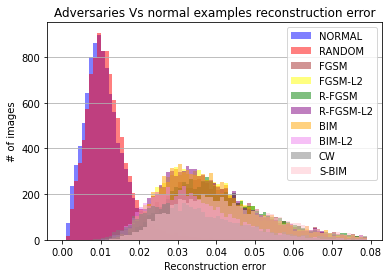

In [14]:
# types = ['normal','S-BIM'] 
import matplotlib.pyplot as plt
ref = []

for iteration, (x, y) in enumerate(tqdm(train_loader,position=0,leave=True)):
    x_type, y = x.to(device), y.to(device)
    y_type = torch.argmax(model_raw(x_type),1)
    recon_x_type = get_recon(models,x_type, y_type)
    ref.append((torch.mean((recon_x_type.detach().view(-1, 28*28*1)-x_type.detach().view(-1, 28*28*1))**2,dim=1)))

ref = torch.cat(ref,dim=0).cpu().numpy()
# n, bins, patches = plt.hist(x=ref, bins = np.arange(0.0,0.08,0.001) , color='brown',
#                               alpha=0.5,label='train images')
types =         ['normal','random','fgsm' ,'fgsm-L2','R-fgsm','R-fgsm-L2','BIM'   ,'BIM-L2','CW'  ,'S-BIM']          

for t in types :
  n, bins, patches = plt.hist(x=recons_errors[t], bins = np.arange(0.0,0.08,0.001) , color=type_color[t],
                              alpha=0.5,label=t.upper())
  print("Ratio for " + t + " : ", no_of_incorrects[t]/(no_of_incorrects[t] + no_of_corrects[t]))
  print("No of corrects for " + t + " : ", no_of_corrects[t])

plt.grid(axis='y')
# size = plt.get_size_inches()*plt.dpi
# print(size)
plt.xlabel('Reconstruction error')
plt.ylabel('# of images')
plt.legend()
plt.title('Adversaries Vs normal examples reconstruction error')
plt.savefig('recons-errors.png')
maxfreq = n.max()
plt.show()

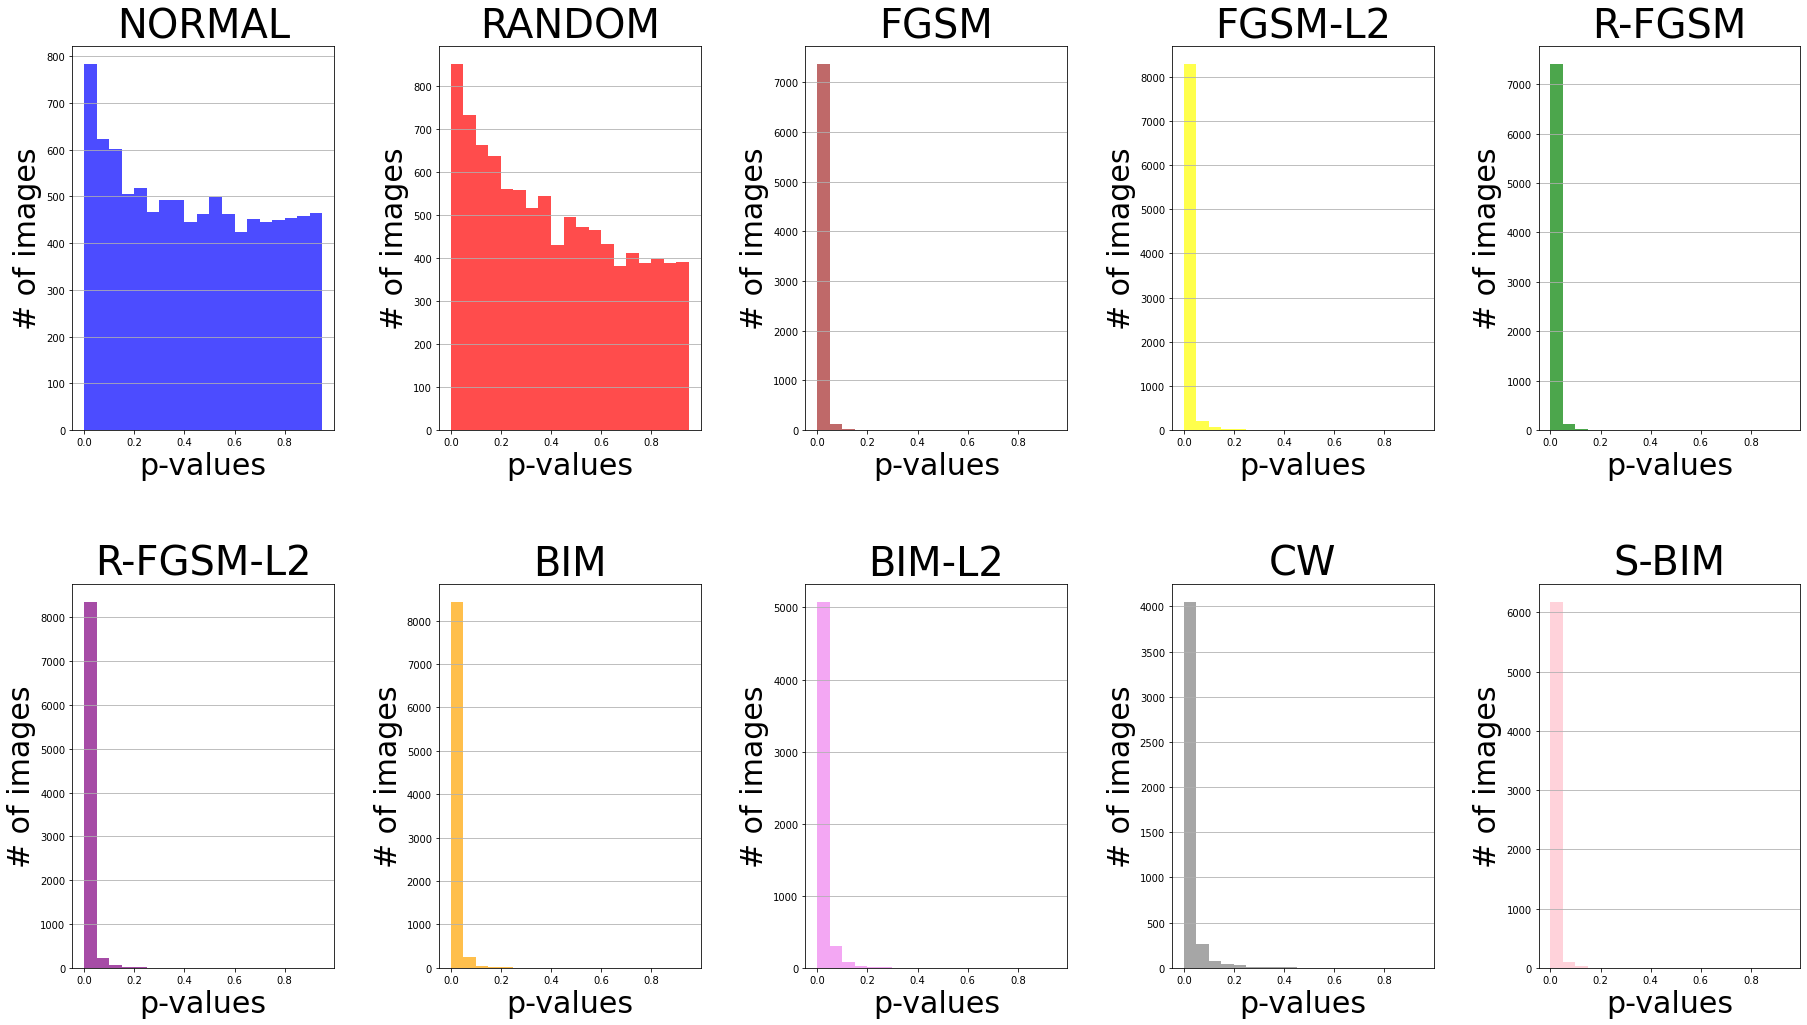

In [15]:
# ref = []
# for iteration, (x, y) in enumerate(tqdm(train_loader,position=0,leave=True)):
#     x_type, y = x.to(device), y.to(device)
#     y_type = torch.argmax(model_raw(x_type),1)
#     recon_x_type = get_recon(models,x_type, y_type)
#     ref.append((torch.mean((recon_x_type.detach().view(-1, 28*28*1)-x_type.detach().view(-1, 28*28*1))**2)).cpu().numpy())

pvals = {}
# ref = np.array(recons_errors['normal'])
# types = ['normal','random','fgsm','fgsm','fgsmR','fgsmR','BIM','fgsmI','CW','CW']          
for t in types :
  pvals[t] = []
  for error in recons_errors[t] :
    val = np.sum(ref>error)/len(ref)#.shape[0]
    pvals[t].append(val)

plt.figure(figsize=(30, 16))
plt.tight_layout()
p = 0
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for t in types :
  p += 1
  plt.subplot(2, 5, p)
  n, bins, patches = plt.hist(x=pvals[t], bins=np.arange(0.,1.,0.05), color=type_color[t],
                              alpha=0.7)
  plt.title(t.upper(),fontsize = 40)
  plt.grid(axis='y')
  plt.xlabel('p-values',fontsize = 30)
  plt.ylabel('# of images',fontsize = 30)

plt.savefig('p-values.png')
plt.show()  
# plt.show()

# p = 0
# for t in types :
#   p += 1
#   n, bins, patches = plt.hist(x=pvals[t], bins=np.arange(0.,1.,0.05), color=type_color[t],
#                               alpha=0.7)
#   plt.grid(axis='y')
#   plt.xlabel('p-values')
#   plt.ylabel('# of images')
#   plt.title(t)
#   plt.savefig('p-values-mnist-' + t + '.png')
#   plt.show()

AUC for normal:  0.49999999999999994
AUC for random:  0.5378328100000002
AUC for fgsm:  0.984091956550713
AUC for fgsm-L2:  0.9790924483399118
AUC for R-fgsm:  0.9840594097406035
AUC for R-fgsm-L2:  0.9790254288016577
AUC for BIM:  0.9804746136233543
AUC for BIM-L2:  0.9712179089590135
AUC for CW:  0.965755620842572
AUC for S-BIM:  0.9839416745880861


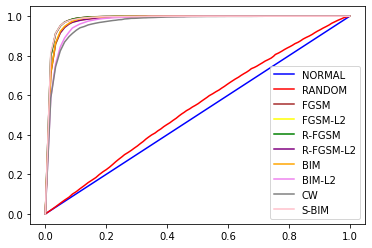

In [16]:
from sklearn import metrics
tpr = {}
for t in types :
  tpr[t] = []
  pvals[t] = np.array(pvals[t])
  # auc = 0
  fpr = []
  for pval in np.arange(0,1.01,0.01) :
    tpr[t].append(np.sum(pvals[t]<pval)/pvals[t].shape[0])
    # auc += np.sum(pvals[t]<pval)/pvals[t].shape[0]*0.01

  
  auc = metrics.auc(tpr['normal'], tpr[t])#auc - 0.5*(np.sum(pvals[t]<0)/pvals[t].shape[0]-np.sum(pvals[t]<1)/pvals[t].shape[0])*0.01
  plt.plot(tpr['normal'],tpr[t],color=type_color[t],label=t.upper())
  print("AUC for " + t + ": ", str(auc))

plt.legend()
plt.savefig('linear_comparison.png')
plt.show()

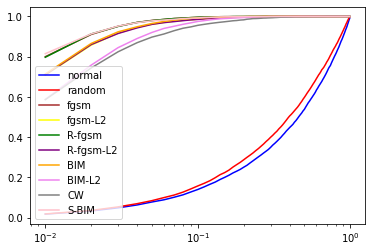

In [17]:
tpr = {}
for t in types :
  tpr[t] = []
  pvals[t] = np.array(pvals[t])
  for fpr in np.arange(0.01,1,0.01) :
    tpr[t].append(np.sum(pvals[t]<fpr)/pvals[t].shape[0])
  plt.plot(np.arange(0.01,1,0.01),tpr[t],color=type_color[t],label=t)

types = ['normal','random','fgsm','fgsm-L2','R-fgsm','R-fgsm-L2','BIM','BIM-L2','CW','target_CW2']          

plt.legend()
plt.xscale('log')
plt.savefig('log_comparison.png')
plt.show()

# Test cases

  0%|          | 0/100 [00:00<?, ?it/s]

normal 9 - nine
random 9 - nine
fgsm 3 - three
fgsm-L2 3 - three
R-fgsm 3 - three
R-fgsm-L2 3 - three
BIM 3 - three
BIM-L2 3 - three
CW 3 - three


  0%|          | 0/100 [00:09<?, ?it/s]

S-BIM 5 - five


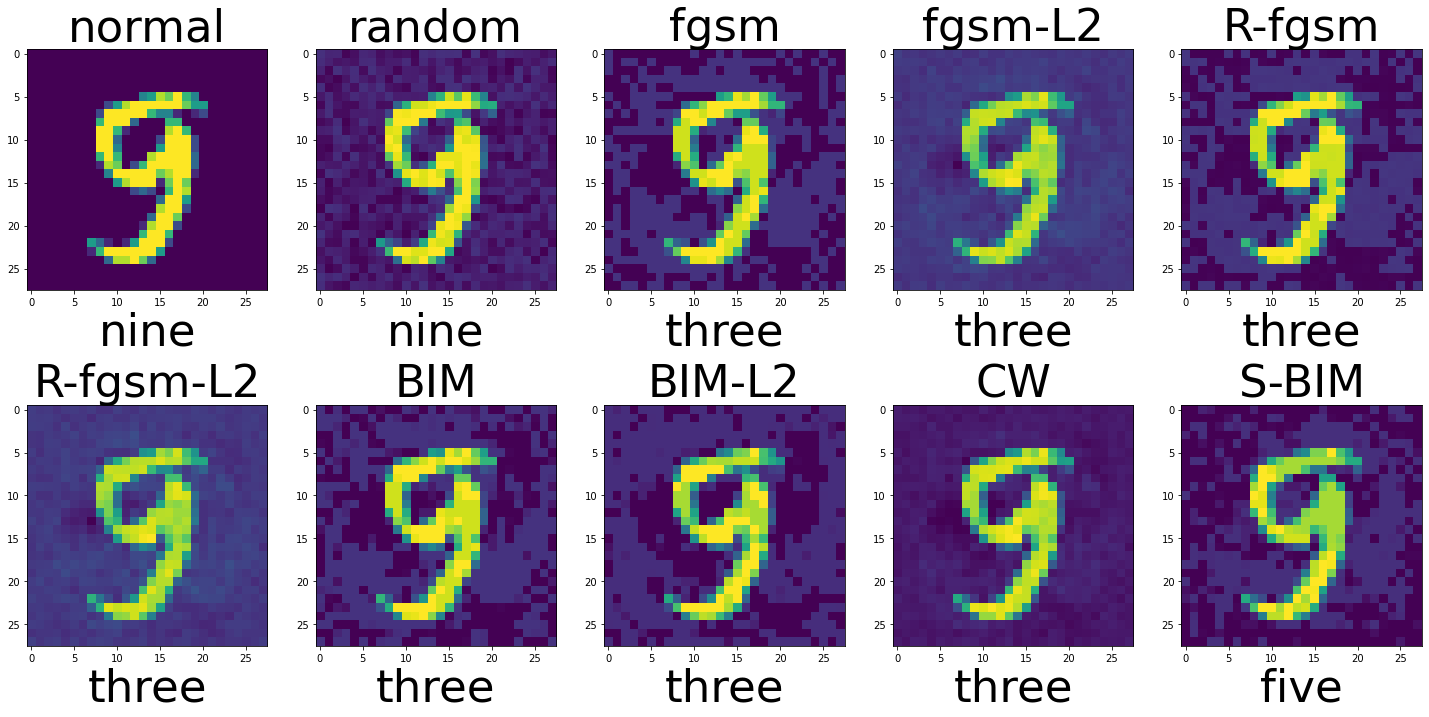

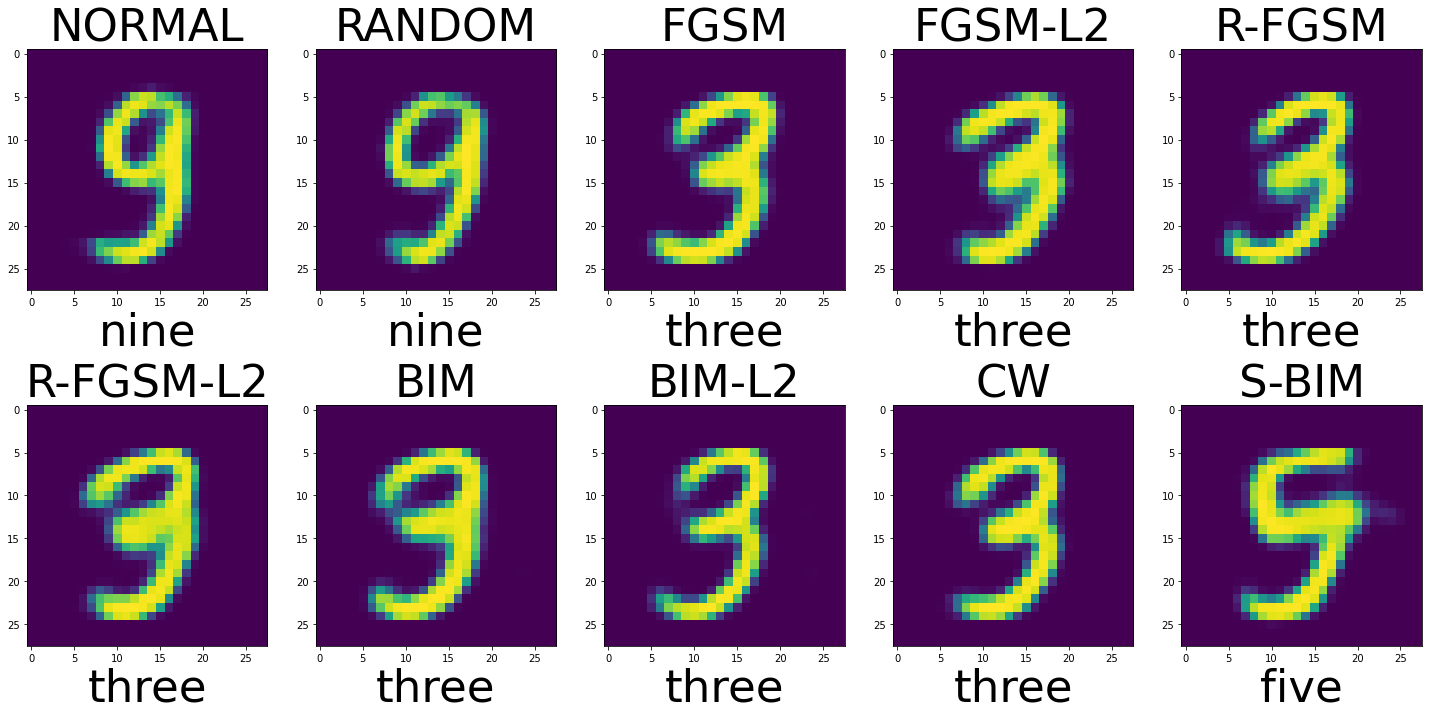

In [ ]:
types = ['normal','random','fgsm','fgsm-L2','R-fgsm','R-fgsm-L2','BIM','BIM-L2','CW','S-BIM']          
# epsilon= 0.03
reconstructeds = []
ys = []
epsilon = 20/255
epsilon_step = 4/255
sigma = 0.7
no_of_iters = 10
epsilon_random = 4/255

torch.random.manual_seed(5)
plt.figure(figsize=(25, 12))
# torch.set_seed()
plt.tight_layout()
titles = []
titles2 = []
for iteration, (x, y) in enumerate(tqdm(test_loader1,position=0,leave=True)):
    # print("yes")
    x, y = x.to(device), y.to(device)
    p = 0
    for t in types :
        p += 1
        if t == 'normal' :
          x_type = x
        if t == 'random' :
          x_type = random(x,epsilon)
        if t == 'fgsm' :
          x_type = fgsm(model_raw,x,y,epsilon)
        if t == 'fgsm-L2' :
          x_type = fgsm_L2(model_raw,x,y,15*epsilon)
        if t == 'R-fgsm' :
          x_type = R_fgsm(model_raw,x,y,epsilon,epsilon_random)
        if t == 'R-fgsm-L2' :
          x_type = R_fgsm_L2(model_raw,x,y,15*epsilon,epsilon_random)
        if t == 'BIM' :
          x_type = BIM(model_raw,x,y,epsilon,epsilon_step,no_of_iters)
        if t == 'BIM-L2' :
          x_type = BIM_L2(model_raw,x,y,25*epsilon,15*epsilon_step,no_of_iters)
        if t == 'CW' :
          rands = torch.randint(0,9,(x.shape[0],)).to(device)
          rands[0] = 3
          x_type = CW(model_raw,x,y,epsilon,3*epsilon_step,no_of_iters*2,2,(rands<y)*rands + (rands>=y)*(rands+1)) 
        if t == 'S-BIM' :
          rands = torch.randint(0,9,(x.shape[0],)).to(device)
          x_type = S_BIM(model_raw,models,x,(rands<y)*rands + (rands>=y)*(rands+1),epsilon,sigma,epsilon_step,no_of_iters)
        plt.subplot(2, 5, p)
        plt.imshow(x_type[0].permute(1,2,0)[:,:,0].cpu().data.numpy())
        y_type = torch.argmax(model_raw(x_type),1)
        titles.append(t.upper())
        titles2.append(train_dataset_raw.classes[y_type[0]][4:])
        plt.title(t,fontsize=45)
        # plt.axis('off')
        plt.xlabel(train_dataset_raw.classes[y_type[0]][4:],fontsize=45)
        # if t!='normal' and t!='random':
        #     y_type = 
        recon_x_type = get_recon(models,x_type, y_type)
        print(t, train_dataset_raw.classes[y_type[0]])
        reconstructeds.append(recon_x_type[0].permute(1,2,0).cpu().data.numpy())
        # plt.savefig('orig_'+t+'.png')
        # plt.show()
    break
plt.savefig('orig_eg.png')
plt.show()

plt.figure(figsize=(25, 12))
for i in range(len(reconstructeds)) :
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstructeds[i][:,:,0])
    plt.title(titles[i].upper(),fontsize=45)
    # plt.axis('off')
    plt.xlabel(titles2[i],fontsize=45)
# print('recon_eg.png')
plt.savefig('recon_eg.png')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([3, 7, 1, 2, 6, 1, 1, 3, 8, 8, 0, 6, 6, 6, 5, 4, 3, 6, 6, 0, 8, 7, 1, 3,
        2, 3, 0, 5, 8, 3, 7, 0, 4, 5, 5, 4, 1, 5, 0, 2, 5, 7, 2, 5, 7, 1, 3, 8,
        8, 8, 5, 8, 7, 2, 8, 7, 3, 3, 7, 8, 5, 5, 7, 6, 3, 3, 7, 1, 1, 1, 6, 8,
        6, 1, 5, 6, 2, 5, 6, 0, 1, 1, 5, 0, 6, 1, 8, 4, 3, 4, 2, 6, 6, 2, 8, 8,
        3, 3, 1, 7], device='cuda:0')
reconstruction error :  tensor(0.0170, device='cuda:0')
Pred class :  tensor(9, device='cuda:0')
L2 diff :  tensor(0., device='cuda:0')
reconstruction error :  tensor(0.0249, device='cuda:0')
Pred class :  tensor(3, device='cuda:0')
L2 diff :  tensor(0.6119, device='cuda:0')
reconstruction error :  tensor(0.0236, device='cuda:0')
Pred class :  tensor(3, device='cuda:0')
L2 diff :  tensor(0.6115, device='cuda:0')
reconstruction error :  tensor(0.0221, device='cuda:0')
Pred class :  tensor(3, device='cuda:0')
L2 diff :  tensor(0.6100, device='cuda:0')
reconstruction error :  tensor(0.0202, device='cuda:0')
Pred class :  tensor(3, device

  0%|          | 0/100 [00:33<?, ?it/s]

reconstruction error :  tensor(0.0191, device='cuda:0')
Pred class :  tensor(3, device='cuda:0')
L2 diff :  tensor(1.0513, device='cuda:0')


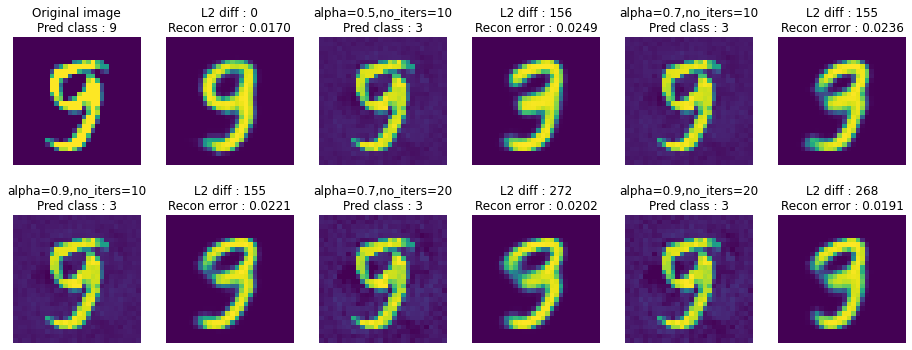

In [ ]:
import matplotlib.pyplot as plt

torch.random.manual_seed(5)
plt.figure(figsize=(16, 6))
epsilon = 800/255 # Huge
epsilon_step = 4/255
epsilon_random = 2/255
alphas = [0,0.5,0.7,0.9,0.7,0.9]
no_iters = [0,10,10,10,20,20]

for iteration, (x, y) in enumerate(tqdm(test_loader1,position=0,leave=True)):
    # print("yes")
    x, y = x.to(device), y.to(device)
    rands = torch.randint(0,9,(x.shape[0],)).to(device)
    # rands = torch.randint(0,9,(x.shape[0],)).to(device)
    rands[0] = 3
    print(rands)
    for i in range(6) :
        # plt.subplot(2, 5, i+1)
        x_type = S_BIM(model_raw,models,x,(rands<y)*rands,epsilon,alphas[i],epsilon_step,no_iters[i])
        # x_type = CW(model_raw,x,y,epsilon,epsilon_step,no_iters[i],-1,(rands<y)*rands)
        y_type = torch.argmax(model_raw(x_type),1)
        recon_x_type = get_recon(models,x_type, y_type)
        rec_error = torch.mean((recon_x_type.detach().view(-1, 28*28*1)-x_type.detach().view(-1, 28*28*1))**2,dim=1)[0]
        print("reconstruction error : ", rec_error)
        print("Pred class : ", y_type[0])
        print("L2 diff : ", torch.linalg.norm(x[0]-x_type[0]))
        plt.subplot(2, 6, 2*i + 1)
        plt.imshow(x_type[0].permute(1,2,0)[:,:,0].cpu().data.numpy())
        plt.title("alpha="+str(alphas[i])+",no_iters="+str(no_iters[i])+"\nPred class : "+str(int(y_type[0].detach())),fontsize=12)
        if i==0 :
          plt.title("Original image\nPred class : "+str(int(y_type[0].detach())),fontsize=12)
      
        plt.axis('off')
        plt.subplot(2, 6, 2*i + 2)
        plt.imshow(recon_x_type[0].permute(1,2,0)[:,:,0].cpu().data.numpy())
        plt.title("L2 diff : " + str(int(torch.linalg.norm(x[0]-x_type[0]).detach()*255)) +"\nRecon error : "+ str("{0:.4f}".format(rec_error.detach())),fontsize=12)
        plt.axis('off')
    break

plt.savefig('special_attack.png')
plt.show()

In [ ]:
%ls

cifar/                 p-values-mnist-BIM-L2.png     recon_fgsm.png
data/                  p-values-mnist-BIM.png        recon_normal.png
imagenet/              p-values-mnist-CW.png         recon_random.png
LICENSE                p-values-mnist-fgsm-L2.png    recon_R-fgsm-L2.png
linear_comparison.png  p-values-mnist-fgsm.png       recon_R-fgsm.png
log_comparison.png     p-values-mnist-normal.png     recon_S-BIM.png
mnist/                 p-values-mnist-random.png     recons-errors.png
orig_BIM-L2.png        p-values-mnist-R-fgsm-L2.png  recons_errors.txt
orig_BIM.png           p-values-mnist-R-fgsm.png     requirements.txt
orig_CW.png            p-values-mnist-S-BIM.png      roadmap_zh.md
orig_fgsm-L2.png       pytorch_playground.egg-info/  script/
orig_fgsm.png          quantize.py                   setup.py
orig_normal.png        README.md                     stl10/
orig_random.png        recon_BIM-L2.png              svhn/
orig_R-fgsm-L2.png     recon_BIM.png                 utee/
